<h2>Store 3266 OGP Associate Metric Analysis 12/20/2024 - 4/24/2025</h2>
<p>Saturday is set as start of a new week</p>
<p>Accounts for old style format from O.G. Report 3.0 and new style from new dashboard. Trains on market 178 data starting 3/17/2025.</p>

In [1259]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-learn
!pip install xgboost
!pip install lightgbm
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install keras-tuner
!pip install psutil


In [1260]:
import warnings
warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import seaborn as sns
from datetime import datetime, timedelta, date 
import glob
import os
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb
import platform

notebook_start_time = time.time()
%matplotlib inline
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Check if MPS is available
print("Is MPS available?", torch.backends.mps.is_available())

# Check if MPS is built into your PyTorch installation
print("Is MPS built?", torch.backends.mps.is_built())

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(device)
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
#prevents text wrapping from output
pd.set_option('display.width', 1000)

Is CUDA available? False
Is MPS available? True
Is MPS built? True
mps
tensor([1.], device='mps:0')


In [1261]:
print(f'Platform: {platform.platform()}')
print(f'Platform processor: {platform.processor()}')
def cpu_info(): 
    if platform.system() == 'Windows': 
        return platform.processor() 
    elif platform.system() == 'Darwin': 
        command = '/usr/sbin/sysctl -n machdep.cpu.brand_string' 
        return os.popen(command).read().strip() 
    elif platform.system() == 'Linux': 
        command = 'cat /proc/cpuinfo' 
        return os.popen(command).read().strip() 
    return 'platform not identified' 
 
print(cpu_info()) 

Platform: macOS-15.5-arm64-arm-64bit
Platform processor: arm
Apple M4 Max
Apple M4 Max


In [1262]:
print(xgb.__version__)  # Ensure it shows the version with GPU support

from xgboost import XGBRegressor
model = XGBRegressor(tree_method="gpu_hist")
print(model.get_params())  # Check if tree_method is set to gpu_hist


2.1.3
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


<h1>Select Store</h1>

In [1263]:
selected_store = 3266

In [1264]:
file = "Data/ByAssociateView_12-20-2024_1-19-2025.csv"
file2 = "Data/ByAssociateView_1-20-2025_1-22-2025.csv"
files = [file, file2]
'''with open(file, "rb") as file:
        result = chardet.detect(file_name.read(10000))
        print(f"File: {file_name}")
        print(f"Detected Encoding: {result['encoding']}, Confidence: {result['confidence']}\n")'''
#df = pd.read_csv(file, encoding="utf-16", sep="\t", engine="python")
#df2 = pd.read_csv(file2, encoding="utf-16", sep="\t", engine="python")

test = False #flag for text files to csv 
delim_same = False #flag for same delimiter across files
market = False
# Specify the directory where your CSV files are located
csv_dir = "Data/"  # Update this to your folder path
if test == True:
    csv_dir = "Data/TestTextInput/"  # Update this to your folder path
if market == True:
    csv_dir = "Data/MarketData/"  # Update this to your folder path
# Use glob to get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(csv_dir, "ByAssociateView_*.csv"))
# Create an empty list to store DataFrames
dataframes = []
# Loop through each file, read it into a DataFrame, and append it to the list
# Process each file
for file_path in csv_files:
    print(f"File being processed: {file_path}") 
    # Detect encoding
    with open(file_path, "rb") as f:
        result = chardet.detect(f.read(10000))   
    encoding = result['encoding']
    print(f"Detected Encoding: {encoding}, Confidence: {result['confidence']}\n")   
    # Read the file into a DataFrame
    if test == True and delim_same == False:
        print("test == True and delim_same == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if test == True and delim_same == True:
        print("test == True and delim_same == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    if market == True:
        print("market == True")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
            df.head()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
    else:
        print("test == False")
        try:
            df = pd.read_csv(file_path, encoding=encoding, sep="\t", engine="python")
            dataframes.append(df)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")

if len(dataframes) > 0:
    dataframes[0].head()
    # Combine the DataFrames row-wise
    combined_df = pd.concat(dataframes, ignore_index=True)
    #print(combined_df)
    print(f'df shape: {df.shape}\ncombined_df shape: {combined_df.shape}')
    df = combined_df
    if 'Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate' in df.columns:
        df = df.drop('Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate', axis=1)
    
    if "Associate ID" in df.columns:
        df = df.sort_values(by=["Associate ID", "Day of Pick Date"], ascending=[True,False])
    elif "Associate" in df.columns:
        df = df.sort_values(by=["Associate", "Day of Pick Date"], ascending=[True,False])
    else:
        print("No 'Associate ID' or 'Associate' column found for sorting.")
    #df.drop_duplicates(subset=["Associate ID", "Day of Pick Date"], keep='first', inplace=True)
    df.reset_index(drop=True)
    print(f'Columns in df: {df.columns.unique()}')
    print(f'Before dropping duplicates: {df.shape}')
    df_unique = df.drop_duplicates()
    print(f'After dropping duplicates: {df_unique.shape}')
    df = df_unique
else:
    print("No DataFrames to combine.")



File being processed: Data/ByAssociateView_3-25_3-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-1-_TO_3-12-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-4_3-5-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_2-24_2-26-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_4-7_4-11-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-27-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_1-28-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_1-29-2025.csv
Detected Encoding: UTF-16, Confidence: 1.0

test == False
File being processed: Data/ByAssociateView_3-19-2025.cs

In [1265]:
#print(df.shape)
df.head(10)
df.sample(50)

,Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,...,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,SFS Pack Hours,SFS Packed Qty,SFS Pack Rate,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate ID
1511,5142.0,NYRAH SIMMONS,Total,89.15%,470,419,70.0,6.38,429,17,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2854,1977.0,ERICKA ESCALONA,3/18/25,94.59%,74,70,180.2,0.41,70,4,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7440,5012.0,ALICIA TATAREK,Total,92.44%,"12,579","11,628",119.1,100.15,"11,647",284,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,1844.0,PATRICIA BROWN,3/25/25,98.03%,152,149,81.2,1.84,149,0,...,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4356,2195.0,MARIANO CUEVAS SIERRA,3/27/25,92.22%,360,332,109.7,3.13,334,9,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9146,5142.0,MARJORIE JOSEPH,4/8/25,83.95%,299,251,57.1,4.73,251,19,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,3266.0,MARIA SANCHEZ,2/25/25,93.07%,NaN,NaN,51.0,4.43,217,9,...,0,4,0,NaN,NaN,NaN,NaN,NaN,231,NaN
6858,3830.0,DANIELLE KOSOWSKI,3/31/25,92.78%,360,334,101.0,3.38,335,6,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10625,3266.0,ARPANA SILUMALA,2/7/25,96.64%,NaN,NaN,49.0,2.4,115,2,...,0,0,0,NaN,NaN,NaN,NaN,NaN,119,NaN
15769,3830.0,STEVEN SCHOPPAUL,Total,91.97%,249,229,84.2,2.83,232,6,...,4,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1266]:
def convert_weekday_number_to_day(date):
    switch = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return switch.get(date.weekday(), "Invalid weekday number")

In [1267]:
'''df = df.drop(df.columns[15], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[14], axis=1)
df = df.drop(df.columns[0], axis=1)
#df = df.set_index("Associate ID")'''
df = df.drop(['SFS Pack Hours', 'SFS Packed Qty', 'SFS Pack Rate'], axis=1)

In [1268]:
df.head()
df.loc[df['Store #'] == 1977, :].head()

,Store #,Associate,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate ID
528,1977.0,ANDREW SCHWARTZ,Total,87.76%,735,645,93.5,7.29,664,18,0.0,40,0,0,0,0,NaN,NaN,NaN,NaN
531,1977.0,ANTHONY JUAREZ,Total,95.83%,24,23,26.2,0.88,23,0,0.0,0,29,13,5,11,NaN,NaN,NaN,NaN
534,1977.0,BICHARE LOUIS,Total,89.65%,976,875,139.2,6.59,884,33,0.0,22,0,0,0,0,NaN,NaN,NaN,NaN
537,1977.0,BRITTANI RUSH,Total,93.71%,143,134,74.7,1.85,136,2,0.0,2,0,0,0,0,NaN,NaN,NaN,NaN
541,1977.0,BRYANNA SANCHEZ,Total,87.25%,659,575,109.7,5.49,577,25,0.0,54,76,34,20,16,NaN,NaN,NaN,NaN


In [1269]:
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}
if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

In [1270]:

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}
names_to_ids = {v: k for k, v in ids_to_names.items()}  # lowercase keys

# IDs to exclude if needed
ids_to_drop = {"csp", "total", "nsm"}

# Separate 3266 and other stores
df_selected_store = df[df['Store #'] == 3266].copy()
df_other = df[df['Store #'] != 3266].copy()

# Ensure Associate ID column exists
if "Associate ID" not in df_selected_store.columns:
    df_selected_store["Associate ID"] = None

# Fill missing Associate IDs for 3266
df_selected_store["Associate ID"] = df_selected_store.apply(
    lambda row: ids_to_names.get(str(row.get("Associate", "")).upper().strip(), row["Associate ID"])
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Remove dropped IDs from 3266
df_selected_store = df_selected_store[~df_selected_store["Associate ID"].str.lower().isin(ids_to_drop)]

# Add readable names
df_selected_store["Associate Name"] = df_selected_store["Associate ID"].map(names_to_ids).fillna("NA")

# Remove old Associate column from 3266
df_selected_store.drop(columns=["Associate"], inplace=True, errors="ignore")

# Reorder 3266 columns
for col in ["Associate ID", "Associate Name"]:
    vals = df_selected_store[col]
    df_selected_store.drop(columns=[col], inplace=True)
    df_selected_store.insert(0 if col == "Associate ID" else 1, col, vals)

# Combine 3266 and other stores back together
df = pd.concat([df_selected_store, df_other], ignore_index=True)

# Optional: Combine names cleanly into `Associate` if needed
def merge_names(row):
    name = row.get("Associate Name", "")
    original = row.get("Associate", "")

    if pd.isna(name) or name == "NA":
        return original
    elif pd.isna(original) or name.strip().lower() == original.strip().lower():
        return name
    else:
        return f"{name} ({original})"

if "Associate Name" in df.columns:
    df["Associate"] = df.apply(merge_names, axis=1)
else:
    df["Associate"] = df["Associate"]

# Final cleanup
df.dropna(subset=['Associate'], inplace=True)
df['Store #'] = df['Store #'].astype(int)
print("Stores after filtering:", df["Store #"].unique())
print(df[df['Store #'] == selected_store][['Associate ID', 'Associate']].drop_duplicates())



Stores after filtering: [3266 1844 1921 1977 2195 2518 3236 3830 5012 5142 5414]
     Associate ID                  Associate
0         a0b0ad9              ANGELA BAIORI
37        a0c02mv             AURORA COMPRES
53        a0f0grp            ANDREA FIGUEROA
89        a0p0fc6               ANDREW PLAZA
110       a0s1jgx            ARPANA SILUMALA
143       azi0001                AMMAD IQBAL
145       c0c116s          CHRISTINA CUCITRO
155       c0p07a7               CHETNA PATEL
157       c0r0k4h                 CIANA RIPA
180       d0c0as3           DANIELLE CASIANO
212       d0r0khi               DANIEL RUSSO
231       dapanal             DANILO PANALES
252       e0e04sh              ERIK ENRIQUEZ
284       e0m0abw            ESTHER MARTINEZ
325       e0s0frj                ERICKA SUIN
341       g0n018d             GABRIEL NYDICK
369       h0p01q8                HEENA PATEL
381       hkmanga           HARMINDER MANGAT
383       j0a0f5h         JESSICA AMEGAVLUIE
401       j0p0vpl  

In [1271]:
#df.sample(50)

In [1272]:
df_temp = df.loc[df['Store #'] == 3266, :]
print(df_temp['Associate'].unique())
associate_list_3266 = ['ANGELA BAIORI', 'AURORA COMPRES', 'ANDREA FIGUEROA', 'ANDREW PLAZA',
 'ARPANA SILUMALA','CIANA RIPA', 'DANIEL RUSSO',
 'ERIK ENRIQUEZ', 'ESTHER MARTINEZ', 'ERICKA SUIN',
 'HEENA PATEL', 'JESSICA AMEGAVLUIE', 'JESICA PUGO',
 'JULIA SIGUENCIA', 'LUCILLE LAWSON', 'MAGDALENA GRIJALVA',
 'MIROLLA SAID', 'MARIA SANCHEZ', 'NATHANIEL VENTURA',
 'NOELIA VENTURA DE SANTANA', 'NICOLE WEAVER',
 'SHAMIMA HAQUE MITU', 'SHUBHADA MENGLE', 'SIDDH PANDYA', 'SHARON TUFANO',
 'TIERRA BROWN', 'VICTORIA MORALES']
management_list_3266 = ['CHRISTINA CUCITRO', 'DANIELLE CASIANO', 'DANILO PANALES', 
                        'GABRIEL NYDICK', 'HARMINDER MANGAT', 'RENU SINGH', 'MATTHEW BEDNARCZUK', 
                        'RASHEED WALLACE', 'STEPHANIE MORABITO']

['ANGELA BAIORI' 'AURORA COMPRES' 'ANDREA FIGUEROA' 'ANDREW PLAZA'
 'ARPANA SILUMALA' 'AMMAD IQBAL' 'CHRISTINA CUCITRO' 'CHETNA PATEL'
 'CIANA RIPA' 'DANIELLE CASIANO' 'DANIEL RUSSO' 'DANILO PANALES'
 'ERIK ENRIQUEZ' 'ESTHER MARTINEZ' 'ERICKA SUIN' 'GABRIEL NYDICK'
 'HEENA PATEL' 'HARMINDER MANGAT' 'JESSICA AMEGAVLUIE' 'JESICA PUGO'
 'JOHN MCKENNA' 'JULIA SIGUENCIA' 'KISHOR KHETIA' 'LUCILLE LAWSON'
 'MAGDALENA GRIJALVA' 'MIROLLA SAID' 'MARIA SANCHEZ' 'NATHANIEL VENTURA'
 'NOELIA VENTURA DE SANTANA' 'NICOLE WEAVER' 'RENU SINGH'
 'SHAMIMA HAQUE MITU' 'SHUBHADA MENGLE' 'SIDDH PANDYA' 'SHARON TUFANO'
 'TIERRA BROWN' 'WIJESIRI DESILVA' 'MATTHEW BEDNARCZUK' 'VICTORIA MORALES'
 'IVET SAQUICELA' 'RASHEED WALLACE' 'STEPHANIE MORABITO' 'MILTON TORRES']


<H1>Cell below works for store 3266. Will filter out all other stores.</h1>

In [1273]:
#df.loc[df['Associate Name'] == 0, :].head()

In [1274]:
'''

print("Stores before filtering:", df["Store #"].unique())

#df = df[df["Associate ID"] != "csp"]
ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chetna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}


if "Associate ID" not in df.columns:
    # If Associate ID is missing but Associate Name exists, fill ID using the reverse of names_to_ids
    df['Associate ID'] = None

ids_to_names = {v.upper(): k for k, v in names_to_ids.items()}  # Reverse dictionary
ids_to_names["csp"] = "csp"
ids_to_names["Total"] = "Total"
print(ids_to_names)
# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)
#df = df[~df["Associate ID"].isin(ids_to_drop)]
df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")
#df = df.reset_index()
df['Associate ID'].unique()
#df = df.drop(['Associate'], axis=1)

if "Associate ID" in df.columns:
    print("True")
    df = df[~df["Associate ID"].isin(ids_to_drop)]
    df['Associate Name'] = df['Associate ID'].map(names_to_ids).fillna("NA")

df["Associate ID"] = df["Associate ID"].replace({None: pd.NA})
df = df.dropna(subset=["Associate ID"])

col_to_move = "Associate ID"
col_vals = df["Associate ID"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(0, col_to_move, col_vals)

col_to_move = "Associate Name"
col_vals = df["Associate Name"]
df.drop(col_to_move, axis=1, inplace=True)
df.insert(1, col_to_move, col_vals)
print(f'\nAssociate Name: {df['Associate Name'].unique()}\n')
print(f'\nAssociate: {df['Associate'].unique()}\n')
df_selected_store = df.loc[df['Store #'] == selected_store, :]
print("Stores after filtering:", df["Store #"].unique())


'''

'\n\nprint("Stores before filtering:", df["Store #"].unique())\n\n#df = df[df["Associate ID"] != "csp"]\nids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica Amegavluie\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucil

In [1275]:
'''ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]
ids_to_drop = ["csp", "Total", "nsm"]
#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]
# Dictionary mapping IDs to Names
names_to_ids = {
    'a0b0ad9': 'Angela Baiori', 'a0c02mv': 'Aurora Compres', 'a0f0grp': 'Andrea Figueroa',
    'a0p0fc6': 'Andrew Plaza', 'a0s1jgx': 'Arpana Silumala', 'c0r0k4h': 'Ciana Ripa',
    'd0r0khi': 'Daniel Russo', 'e0e04sh': 'Erik Enriquez', 'e0m0abw': 'Esther Martinez',
    'e0s0frj': 'Ericka Suin', 'h0p01q8': 'Heena Patel', 'j0a0f5h': 'Jessica Amegavluie',
    'j0p0vpl': 'Jesica Pugo', 'jrsigue': 'Julia Siguencia', 'l0l064x': 'Lucille Lawson',
    'm0g065v': 'Magdalena Grijalva', 'm0s0q17': 'Mirolla Said', 'mgs004k': 'Maria Sanchez',
    'n0v0359': 'Nathaniel Ventura', 'n0v03hh': 'Noelia Ventura de Santana',
    'n0w044f': 'Nicole Weaver', 's0m0uve': 'Shamima Haque Mitu', 's0p0hsd': 'Siddh Pandya',
    'stufano': 'Sharon Tufano', 't0b0hm5': 'Tierra Brown', 'g0n018d': 'Gabriel Nydick',
    'd0c0as3': 'Danielle Casiano', 'azi0001': 'Ammad Iqbal', 'm0t03tx': 'Milton Torres',
    'p0c096p': 'Pablo Chavez', 'i0s01rf': 'Ivet Saquicela', 's0m11qg': 'Shubhada Mengle',
    'mdb00c8': 'Matthew Bednarczuk', 'v0m07r6': 'Victoria Morales', 'jfmcken' : 'John Mckenna',
    'kdkheti' : 'Kishor Khetia', 'c0c116s' : 'Christina Cucitro', 'w0d03du' : 'Wijesiri Desilva',
    'hkmanga' : 'Harminder Mangat', 'dapanal' : 'Danilo Panales', 'c0p07a7' : 'Chatna Patel',
    'rsw000v' : 'Rasheed Wallace', 'r0s087j' : 'Renu Singh', 'slmorab' : 'Stephanie Morabito', 'Total': 'Total'
}

# Convert all dictionary keys to lowercase (for IDs) and uppercase (for Names)
names_to_ids = {k.lower().strip(): v.upper().strip() for k, v in names_to_ids.items()}
ids_to_names = {v.upper().strip(): k.lower().strip() for k, v in names_to_ids.items()}

# Ensure "Associate ID" and "Associate Name" columns exist
if "Associate ID" not in df.columns:
    df["Associate ID"] = None
if "Associate Name" not in df.columns:
    df["Associate Name"] = None

# Convert columns to string, strip spaces, and normalize case
df["Associate ID"] = df["Associate ID"].astype(str).str.lower().str.strip().replace("none", None)
df["Associate Name"] = df["Associate Name"].astype(str).str.upper().str.strip().replace("NONE", None)

# Preserve original columns
original_columns = df.columns.tolist()

# Fill missing Associate ID using Associate Name
df["Associate ID"] = df.apply(
    lambda row: ids_to_names.get(row["Associate Name"], row["Associate ID"]) 
    if pd.isna(row["Associate ID"]) or row["Associate ID"] is None else row["Associate ID"],
    axis=1
)

# Fill missing Associate Name using Associate ID
df["Associate Name"] = df.apply(
    lambda row: names_to_ids.get(row["Associate ID"], row["Associate Name"]) 
    if pd.isna(row["Associate Name"]) or row["Associate Name"] is None else row["Associate Name"],
    axis=1
)

# Ensure we are not accidentally dropping other columns
df = df[original_columns]

# Debugging: Print final columns to verify
print("Final columns in DataFrame:", df.columns.tolist())

# Print a preview of the DataFrame to check
print(df.head())
'''



'ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "g0n018d", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "mdb00c8", "Total"]\nids_to_drop = ["csp", "Total", "nsm"]\n#ids_to_drop = ["csp", "d0c0as3", "hkmanga", "dapanal", "nsm", "w0d03du", "jfmcken", "kdkheti", "c0c116s", "azi0001", "r0s087j", "c0p07a7", "m0t03tx", "Total"]\n# Dictionary mapping IDs to Names\nnames_to_ids = {\n    \'a0b0ad9\': \'Angela Baiori\', \'a0c02mv\': \'Aurora Compres\', \'a0f0grp\': \'Andrea Figueroa\',\n    \'a0p0fc6\': \'Andrew Plaza\', \'a0s1jgx\': \'Arpana Silumala\', \'c0r0k4h\': \'Ciana Ripa\',\n    \'d0r0khi\': \'Daniel Russo\', \'e0e04sh\': \'Erik Enriquez\', \'e0m0abw\': \'Esther Martinez\',\n    \'e0s0frj\': \'Ericka Suin\', \'h0p01q8\': \'Heena Patel\', \'j0a0f5h\': \'Jessica Amegavluie\',\n    \'j0p0vpl\': \'Jesica Pugo\', \'jrsigue\': \'Julia Siguencia\', \'l0l064x\': \'Lucille Lawson\',\n    \'m0g065v\': \'Magdalena Grijalva\', \'m0s0q17\': \

In [1276]:
df.head(75)
#df.set_index('Associate', inplace=True)
df.loc[df['Associate Name'] == 'NA', :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate


In [1277]:
df.loc[df['Associate ID'] == "NA", :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate


In [1278]:
df = df.loc[df["Day of Pick Date"] != "Total"] # market data starting from 3/17/2025
df['Store #'] = df['Store #'].astype(int)
#df.head(10)

In [1279]:
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')
df['Day of Week #'] = df['Day of Pick Date'].dt.dayofweek.astype(int)
df['Day of Week'] = df['Day of Pick Date'].apply(convert_weekday_number_to_day)

In [1280]:
df.loc[df['Associate ID'] == 0, :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate,Day of Week #,Day of Week


In [1281]:
# Replace NaN values with 0
#df['Qty Req to Pick'] = df['Qty Req to Pick'].fillna(0)
# Ensure both columns are cleaned and converted to numeric
if 'Qty Req to Pick' in df.columns:
    df['Qty Req to Pick'] = df['Qty Req to Pick'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['Qty Req to Pick'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
if 'FTP Expected' in df.columns:
    df['FTP Expected'] = df['FTP Expected'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['FTP Expected'].fillna(0, inplace=True).astype(int)
if 'Picked As Req Qty' in df.columns:    
    df['Picked As Req Qty'] = df['Picked As Req Qty'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['Picked As Req Qty'].fillna(0, inplace=True).astype(int)
if 'FTP Actual' in df.columns:
    df['FTP Actual'] = df['FTP Actual'].replace(',', '', regex=True).fillna(0).astype(int)
else:
    df['FTP Actual'].fillna(0, inplace=True).astype(int)
# Replace 0 values in 'Qty Req to Pick' with corresponding values from 'FTP Expected'
#df.loc[df['Qty Req to Pick'] == 0, 'Qty Req to Pick'] = df.loc[df['Qty Req to Pick'] == 0, 'FTP Expected']
df['Qty Req to Pick'] = df['Qty Req to Pick'].mask(df['Qty Req to Pick'] == 0, df['FTP Expected'])
df['FTP Expected'] = df['FTP Expected'].mask(df['FTP Expected'] == 0, df['Qty Req to Pick'])
df['Picked As Req Qty'] = df['Picked As Req Qty'].mask(df['Picked As Req Qty'] == 0, df['FTP Actual'])
df['FTP Actual'] = df['FTP Actual'].mask(df['FTP Actual'] == 0, df['Picked As Req Qty'])
df = df.loc[:,:].fillna(0)

# Ensure 'Qty Req to Pick' is numeric
df['Qty Req to Pick'] = pd.to_numeric(df['Qty Req to Pick'], errors='coerce')
df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)
df = df.dropna()
df.head()
df.loc[df['Store #'] == 1844, :].head(20)

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate,Day of Week #,Day of Week
7312,0,0,1844,2025-05-01,91.85,184,169,55.4,3.05,169,...,0,0,0,0,0,0,184,DIANE MAHONEY,3,Thursday
7313,0,0,1844,2025-05-01,50.00,14,7,10.1,0.69,7,...,0,0,0,0,0,0,14,DONNA MORRIS,3,Thursday
7314,0,0,1844,2025-05-01,96.83,126,122,75.2,1.66,123,...,0,0,0,0,0,0,126,ETHAN PAWLING,3,Thursday
7315,0,0,1844,2025-05-01,100.00,19,19,67.0,0.28,19,...,0,0,0,0,0,0,19,IMAN OWENS,3,Thursday
7316,0,0,1844,2025-05-01,79.68,502,400,39.4,10.66,420,...,72,2,0,70,0,0,502,JOHNATHON OTTO,3,Thursday
7317,0,0,1844,2025-05-01,93.78,241,226,50.8,4.55,231,...,0,0,0,0,0,0,241,MARINA MILLARES,3,Thursday
7318,0,0,1844,2025-05-01,93.24,148,138,43.6,3.3,144,...,0,0,0,0,0,0,148,NAKIA MONTGOMERY,3,Thursday
7319,0,0,1844,2025-05-01,96.15,234,225,76.3,2.96,225,...,8,0,0,8,0,0,234,PATRICIA BROWN,3,Thursday
7320,0,0,1844,2025-05-01,81.10,164,133,38.0,3.76,139,...,0,0,0,0,0,0,164,STEPHEN CHILLEMI,3,Thursday
7562,0,0,1844,2025-04-09,92.96,71,66,43.9,1.50,66,...,3,0,1,0,0,0,71,ETHAN PAWLING,2,Wednesday


In [1282]:
#df.loc["a0b0ad9", :]
#df = df.loc[df["Day of Pick Date"] != "Total"]
df.loc[df["Associate ID"] == "a0b0ad9" ,:]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate,Day of Week #,Day of Week
10,a0b0ad9,ANGELA BAIORI,3266,2025-02-05,97.01,233,227,60.0,3.86,227,...,0,0,0,0,0,0,233,ANGELA BAIORI,2,Wednesday
12,a0b0ad9,ANGELA BAIORI,3266,2025-02-02,97.03,268,254,59.0,4.36,254,...,0,0,0,0,0,0,268,ANGELA BAIORI,6,Sunday
13,a0b0ad9,ANGELA BAIORI,3266,2024-12-29,92.92,214,199,42.0,4.88,199,...,0,0,0,0,0,0,214,ANGELA BAIORI,6,Sunday
14,a0b0ad9,ANGELA BAIORI,3266,2024-12-27,100.00,47,47,79.0,0.6,47,...,0,0,0,0,0,0,47,ANGELA BAIORI,4,Friday
15,a0b0ad9,ANGELA BAIORI,3266,2024-12-26,92.66,223,212,51.0,4.18,212,...,2,0,0,2,0,0,223,ANGELA BAIORI,3,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3174,a0b0ad9,ANGELA BAIORI,3266,2025-02-23,96.77,279,271,72.0,3.81,271,...,0,0,0,0,0,0,279,ANGELA BAIORI,6,Sunday
3199,a0b0ad9,ANGELA BAIORI,3266,2025-02-21,96.84,258,245,44.0,5.71,245,...,0,0,0,0,0,0,258,ANGELA BAIORI,4,Friday
3214,a0b0ad9,ANGELA BAIORI,3266,2025-02-20,95.69,235,227,54.0,4.29,227,...,0,0,0,0,0,0,235,ANGELA BAIORI,3,Thursday
3241,a0b0ad9,ANGELA BAIORI,3266,2025-02-18,99.35,154,153,50.0,3.1,153,...,0,0,0,0,0,0,154,ANGELA BAIORI,1,Tuesday


In [1283]:
df.loc[df['Associate ID'] == "rsw000v" , :]
#df.loc[df['Associate Name'] == "Victoria Morales", :]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,First Pick Assgn Qty,First Disp Pick Qty,Qty Req to Pick,Associate,Day of Week #,Day of Week
1896,rsw000v,RASHEED WALLACE,3266,2025-04-04,84.62,39,33,53.7,0.62,33,...,0,0,0,0,0,0,39,RASHEED WALLACE,4,Friday
1912,rsw000v,RASHEED WALLACE,3266,2025-04-04,84.62,39,33,53.7,0.62,33,...,0,0,0,0,0,0,39,RASHEED WALLACE,4,Friday
2477,rsw000v,RASHEED WALLACE,3266,2025-03-05,83.04,0,94,110.0,0.97,94,...,2,1,1,0,112,93,0,RASHEED WALLACE,2,Wednesday
2846,rsw000v,RASHEED WALLACE,3266,2025-03-20,100.00,2,2,300.0,0.01,2,...,0,0,0,0,0,0,2,RASHEED WALLACE,3,Thursday
2862,rsw000v,RASHEED WALLACE,3266,2025-03-20,100.00,2,2,300.0,0.01,2,...,0,0,0,0,0,0,2,RASHEED WALLACE,3,Thursday
3340,rsw000v,RASHEED WALLACE,3266,2025-02-11,91.18,34,31,63.0,0.5,31,...,0,0,0,0,0,0,34,RASHEED WALLACE,1,Tuesday


In [1284]:
# Convert "Day of Pick Date" to datetime
df["Day of Pick Date"] = pd.to_datetime(df["Day of Pick Date"], format="%m/%d/%y")

# Adjust dates to align with Saturday as the start of the week
df["Custom Week Start"] = df["Day of Pick Date"] - pd.to_timedelta((df["Day of Pick Date"].dt.dayofweek + 2) % 7, unit="d")

# Calculate the end of the week (Friday)
df["Custom Week End"] = df["Custom Week Start"] + pd.Timedelta(days=6)

# Combine start and end dates into a single "Week" column as a range
df['Week'] = df["Custom Week Start"].dt.strftime('%Y-%m-%d') + " to " + df["Custom Week End"].dt.strftime('%Y-%m-%d')

oldest_pick_date = df["Day of Pick Date"].min()
last_pick_date = df["Day of Pick Date"].max()
oldest_pick_date = pd.to_datetime(oldest_pick_date).date()
last_pick_date = pd.to_datetime(last_pick_date).date()
print(f"start date: {oldest_pick_date}")
print(f"end date: {last_pick_date}")
def combine_data_to_csv():
    # Create the directory
    try:
        os.mkdir("Data/Combined/")
        print(f"Directory '{"Data/Combined/"}' created successfully.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except FileExistsError:
        print(f"Directory '{"Data/Comnined/"}' already exists.")
        df.to_csv(f"Data/Combined/ByAssociateView_{oldest_pick_date}_{last_pick_date}.csv", index=False)
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
#combine_data_to_csv()
#df.loc[df["Associate ID"] == "a0b0ad9", :]

start date: 2024-12-20
end date: 2025-05-01


In [1285]:
def cols_to_convert_to_float(df):
    cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty'
]

    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [1286]:
print(df.info())
# Group by Associate ID and Week and apply aggregations
# Convert problematic columns to numeric, coercing errors to NaN
#df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')
#df['Nil Pick Qty'] = pd.to_numeric(df['Nil Pick Qty'], errors='coerce')
cols_to_convert = [
    'Picked As Req Qty',
    'Nil Pick Qty',
    'Qty Req to Pick',
    'Substitution Qty',
    'Exception Qty Req to Pick',
    'Exception Picked As Req Qty',
    'Exception Substitution Qty',
    'Exception Nil Pick Qty'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_selected_store = df.loc[df['Store #'] == selected_store, :].copy()
# Check for NaN values introduced after conversion
print("Null values after conversion:")
print(df_selected_store[['Picked As Req Qty', 'Nil Pick Qty']].isna().sum())
weekly_data = df_selected_store.groupby(['Week', 'Associate', "Associate Name"]).agg(
    total_qty_req_to_pick=('Qty Req to Pick', 'sum'),  # Ensure correct column name here
    total_picked_qty=('Picked As Req Qty', 'sum'),  # Added for reference
    avg_pick_rate=('Pick Rate', 'mean'),
    total_substitution_qty=('Substitution Qty', 'sum'),
    total_nil_pick_qty=('Nil Pick Qty', 'sum'),
    total_exception_qty_req=('Exception Qty Req to Pick', 'sum'),
    total_exception_picked_qty=('Exception Picked As Req Qty', 'sum'),
    total_exception_substitution_qty=('Exception Substitution Qty', 'sum'),
    total_exception_nil_pick_qty=('Exception Nil Pick Qty', 'sum')
).reset_index()
weekly_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 12889 entries, 10 to 18996
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Associate ID                 12889 non-null  object        
 1   Associate Name               12889 non-null  object        
 2   Store #                      12889 non-null  int64         
 3   Day of Pick Date             12889 non-null  datetime64[ns]
 4   FTPR                         12889 non-null  float64       
 5   FTP Expected                 12889 non-null  int64         
 6   FTP Actual                   12889 non-null  int64         
 7   Pick Rate                    12889 non-null  float64       
 8   Pick Hours                   12889 non-null  object        
 9   Picked As Req Qty            12889 non-null  int64         
 10  Substitution Qty             12889 non-null  object        
 11  Ovrd Qty                     12889 non-null  

,Week,Associate,Associate Name,total_qty_req_to_pick,total_picked_qty,avg_pick_rate,total_substitution_qty,total_nil_pick_qty,total_exception_qty_req,total_exception_picked_qty,total_exception_substitution_qty,total_exception_nil_pick_qty
0,2024-12-14 to 2024-12-20,ANDREA FIGUEROA,ANDREA FIGUEROA,147,144,55.0,1,2,1,1,0,0
1,2024-12-14 to 2024-12-20,ANDREW PLAZA,ANDREW PLAZA,50,49,36.0,0,0,0,0,0,0
2,2024-12-14 to 2024-12-20,CHRISTINA CUCITRO,CHRISTINA CUCITRO,4,4,46.0,0,0,0,0,0,0
3,2024-12-14 to 2024-12-20,DANIEL RUSSO,DANIEL RUSSO,34,32,81.0,2,0,0,0,0,0
4,2024-12-14 to 2024-12-20,ERICKA SUIN,ERICKA SUIN,55,50,45.0,0,5,0,0,0,0


In [1287]:
if selected_store == 3266:
    weekly_data.loc[weekly_data['Associate'] == 'ANDREW PLAZA', :]

In [1288]:
#df.loc[df['Associate ID'] == 'a0p0fc6']

In [1289]:
unique_ids = df["Associate"].unique()
unique_ids_list = unique_ids.tolist()
#for a in unique_ids_list:
#    print(a)

In [1290]:
#for a in unique_ids_list:
#    print(df.loc[df["Associate ID"] == a, : "Pick Hours"])

In [1291]:
#df["FTPR"] = df["FTPR"].str.replace("%", "").astype(float)

In [1292]:
avdf = df_selected_store.groupby(["Associate ID", "Associate"]).mean(numeric_only=True)

In [1293]:
avdf.head()

,,Store #,FTPR,FTP Expected,FTP Actual,Pick Rate,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,Qty Req to Pick,Day of Week #
Associate ID,Associate,,,,,,,,,,,,,,,
a0b0ad9,ANGELA BAIORI,3266.0,95.969651,162.616279,178.069767,53.937209,179.046512,3.383721,0.0,4.860465,0.779070,0.267442,0.069767,0.441860,162.616279,3.220930
a0c02mv,AURORA COMPRES,3266.0,93.281071,74.464286,78.071429,42.764286,78.214286,2.285714,0.0,4.892857,0.357143,0.000000,0.357143,0.000000,74.464286,4.714286
a0f0grp,ANDREA FIGUEROA,3266.0,96.162167,102.616667,102.816667,54.753333,102.850000,2.200000,0.0,2.200000,0.283333,0.150000,0.116667,0.016667,102.616667,3.100000
a0p0fc6,ANDREW PLAZA,3266.0,90.586222,58.311111,57.822222,45.248889,59.466667,1.577778,0.0,2.377778,0.822222,0.111111,0.022222,0.688889,58.311111,3.511111
a0s1jgx,ARPANA SILUMALA,3266.0,94.498197,138.934426,144.967213,42.708197,145.229508,2.606557,0.0,6.049180,0.245902,0.180328,0.016393,0.049180,138.934426,2.540984


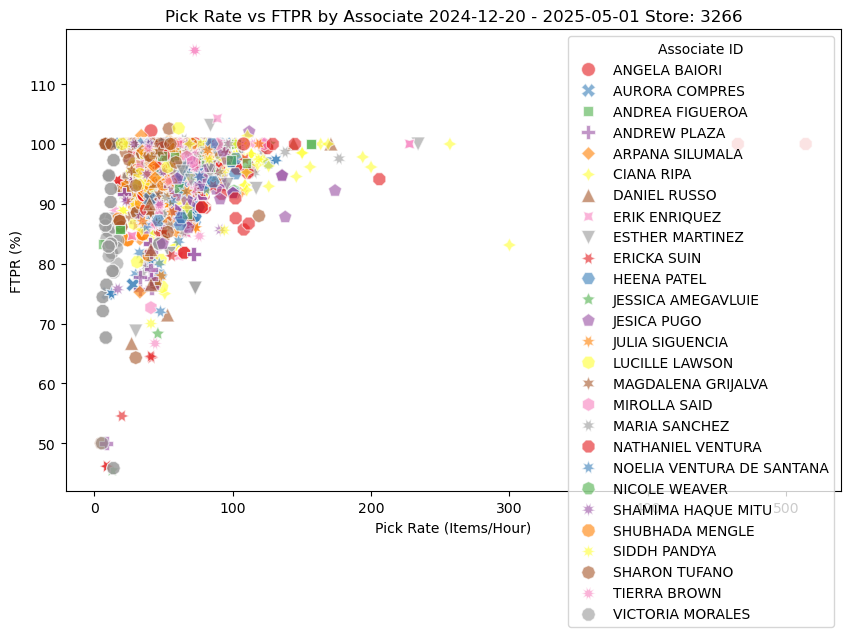

In [1294]:
# Scatter plot with Pick Rate vs FTPR
#selected_store = 3266
df_selected_store = df[df['Store #'] == selected_store]

# Apply associate filter only for store 3266
if selected_store == 3266:
    df_selected_store = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_selected_store,  # use the correctly filtered DataFrame
    x='Pick Rate', y='FTPR',
    hue='Associate', palette='Set1',
    style='Associate', s=100, alpha=0.6
)
plt.title(f'Pick Rate vs FTPR by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Pick Rate (Items/Hour)')
plt.ylabel('FTPR (%)')
plt.legend(title='Associate ID')
plt.show()

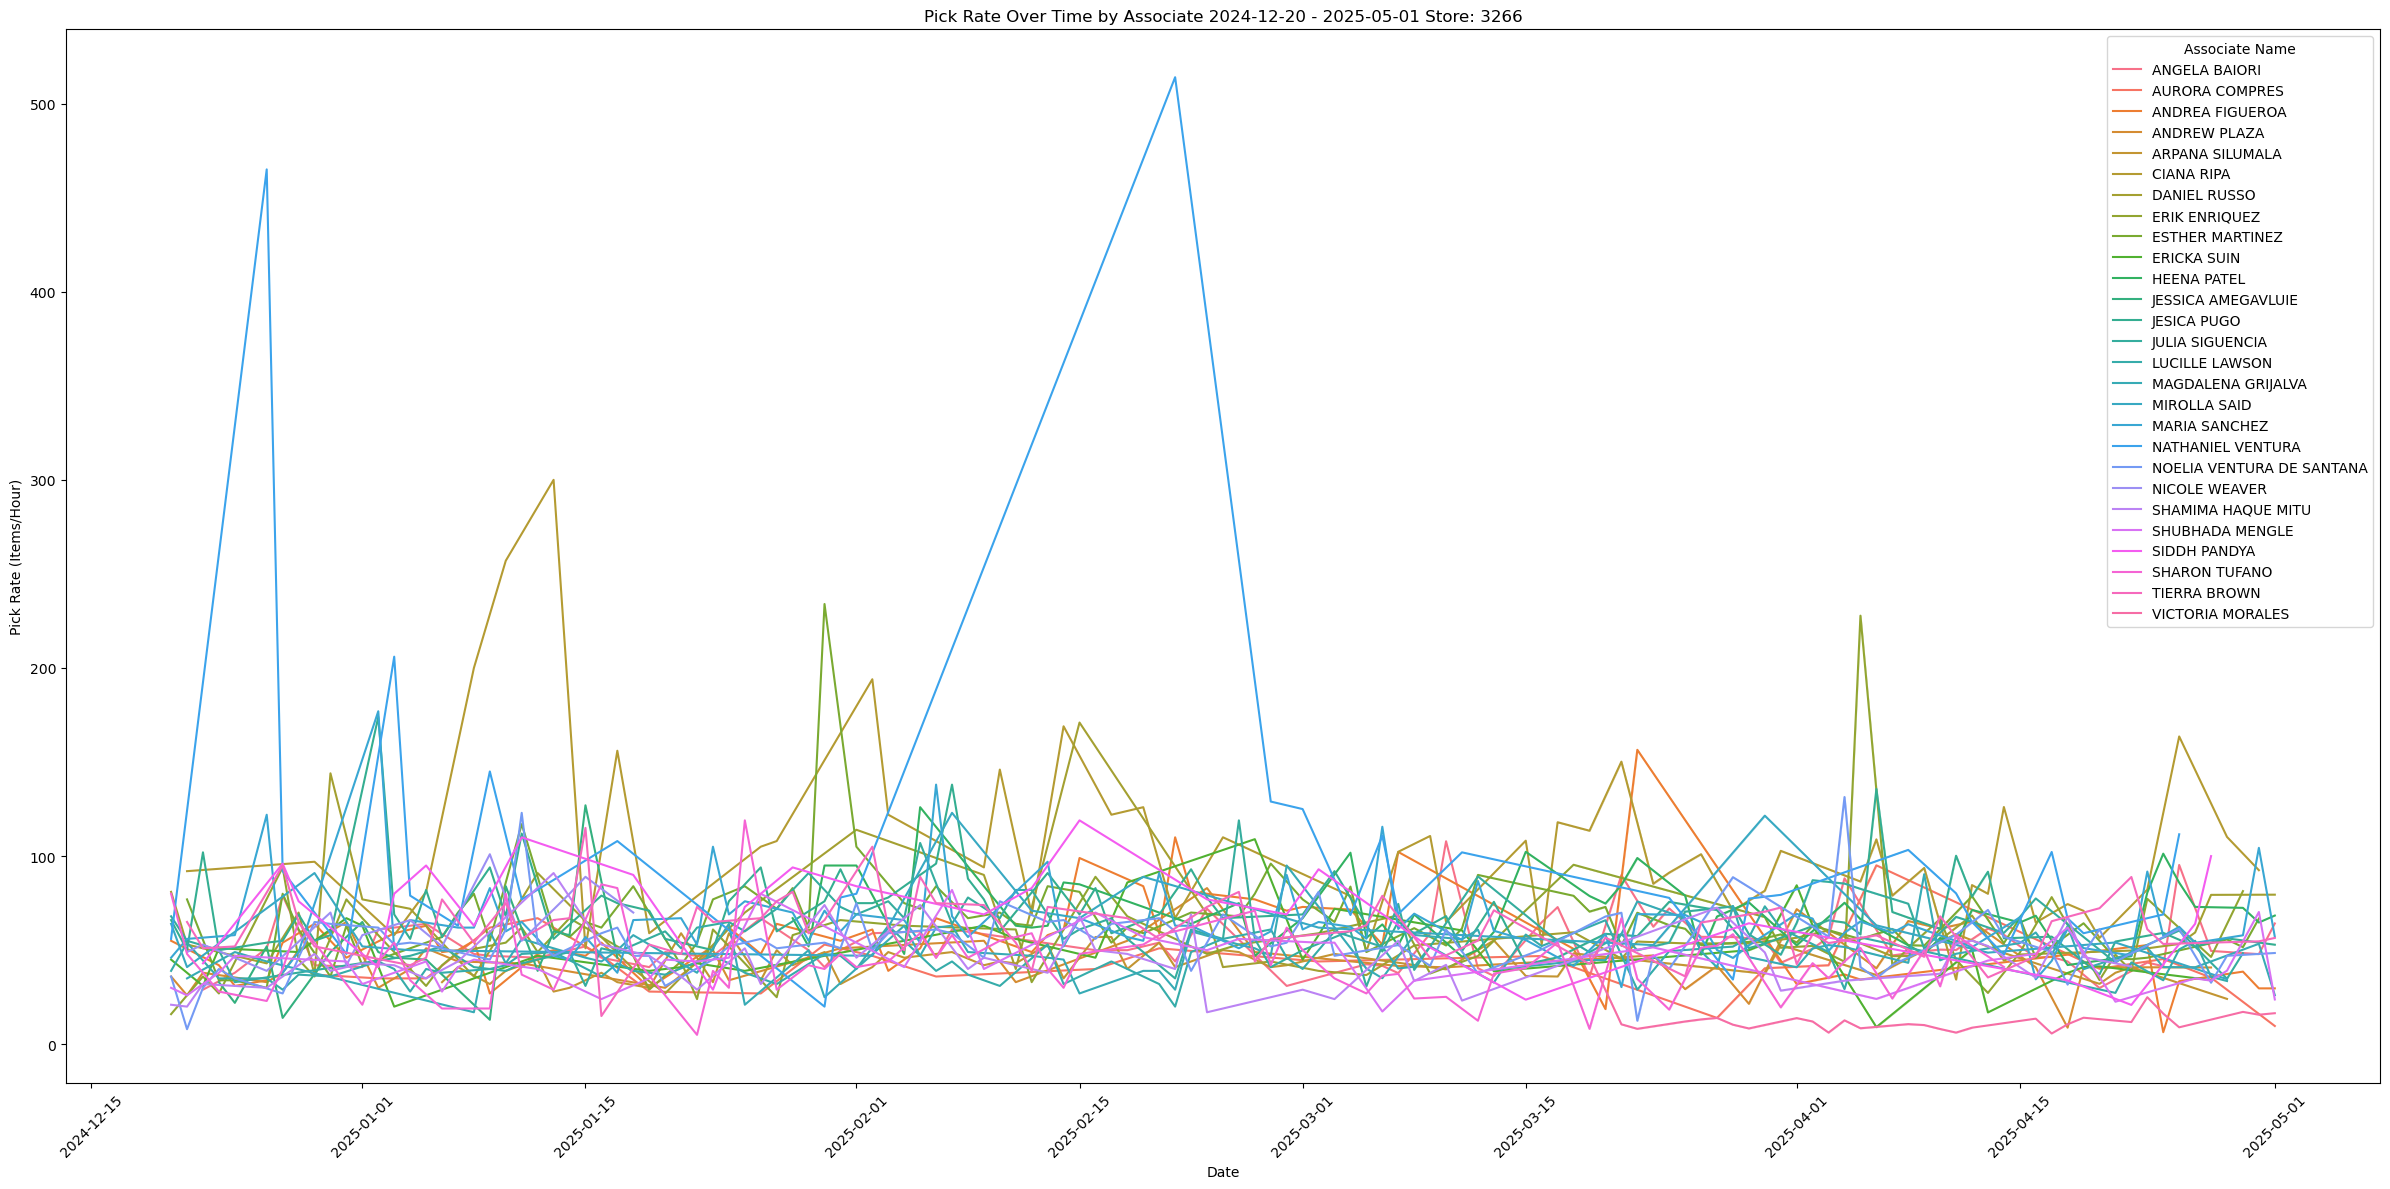

In [1295]:
# Convert 'Day of Pick Date' to datetime format for time-based analysis
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'], format='%m/%d/%y')
df_selected_store['Day of Pick Date'] = pd.to_datetime(df_selected_store['Day of Pick Date'], format='%m/%d/%y')
df_selected_store = df_selected_store.drop_duplicates()

# Filter associates appropriately
if selected_store == 3266:
    df_selected_store_associates_only = df_selected_store[df_selected_store['Associate'].isin(associate_list_3266)]
else:
    df_selected_store_associates_only = df_selected_store

# Line plot of Pick Rate over time for each Associate
plt.figure(figsize=(24, 12))
sns.lineplot(
    data=df_selected_store_associates_only,
    x='Day of Pick Date', y='Pick Rate',
    hue='Associate', markers=True
)
plt.title(f'Pick Rate Over Time by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Date')
plt.ylabel('Pick Rate (Items/Hour)')
plt.xticks(rotation=45)
plt.legend(title='Associate Name')
plt.tight_layout()
plt.show()

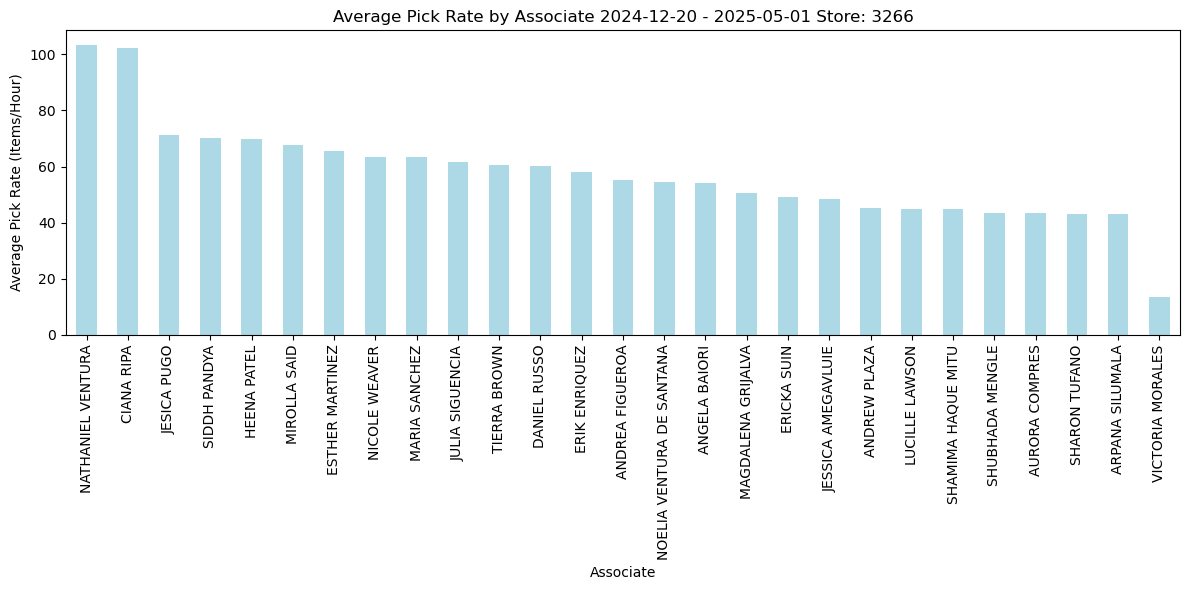

Associate
NATHANIEL VENTURA            103.380488
CIANA RIPA                   102.373239
JESICA PUGO                   71.290323
SIDDH PANDYA                  70.016667
HEENA PATEL                   69.789394
MIROLLA SAID                  67.519048
ESTHER MARTINEZ               65.593939
NICOLE WEAVER                 63.384615
MARIA SANCHEZ                 63.372381
JULIA SIGUENCIA               61.456522
TIERRA BROWN                  60.425610
DANIEL RUSSO                  60.054717
ERIK ENRIQUEZ                 58.221875
ANDREA FIGUEROA               55.172881
NOELIA VENTURA DE SANTANA     54.529213
ANGELA BAIORI                 54.089412
MAGDALENA GRIJALVA            50.449412
ERICKA SUIN                   49.248780
JESSICA AMEGAVLUIE            48.411765
ANDREW PLAZA                  45.248889
LUCILLE LAWSON                45.036585
SHAMIMA HAQUE MITU            44.816364
SHUBHADA MENGLE               43.311905
AURORA COMPRES                43.311111
SHARON TUFANO                 

In [1296]:
# Grouping by Associate ID and calculating average Pick Rate
avg_pick_rate = df_selected_store.groupby('Associate')['Pick Rate'].mean().sort_values(ascending=False)
if selected_store == 3266:
    avg_pick_rate = avg_pick_rate[avg_pick_rate.index.isin(associate_list_3266)]

# Bar plot for average Pick Rate per Associate ID
plt.figure(figsize=(12, 6))
avg_pick_rate.plot(kind='bar', color='lightblue')
plt.title(f'Average Pick Rate by Associate {oldest_pick_date} - {last_pick_date} Store: {selected_store}')
plt.xlabel('Associate')
plt.ylabel('Average Pick Rate (Items/Hour)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

avg_pick_rate

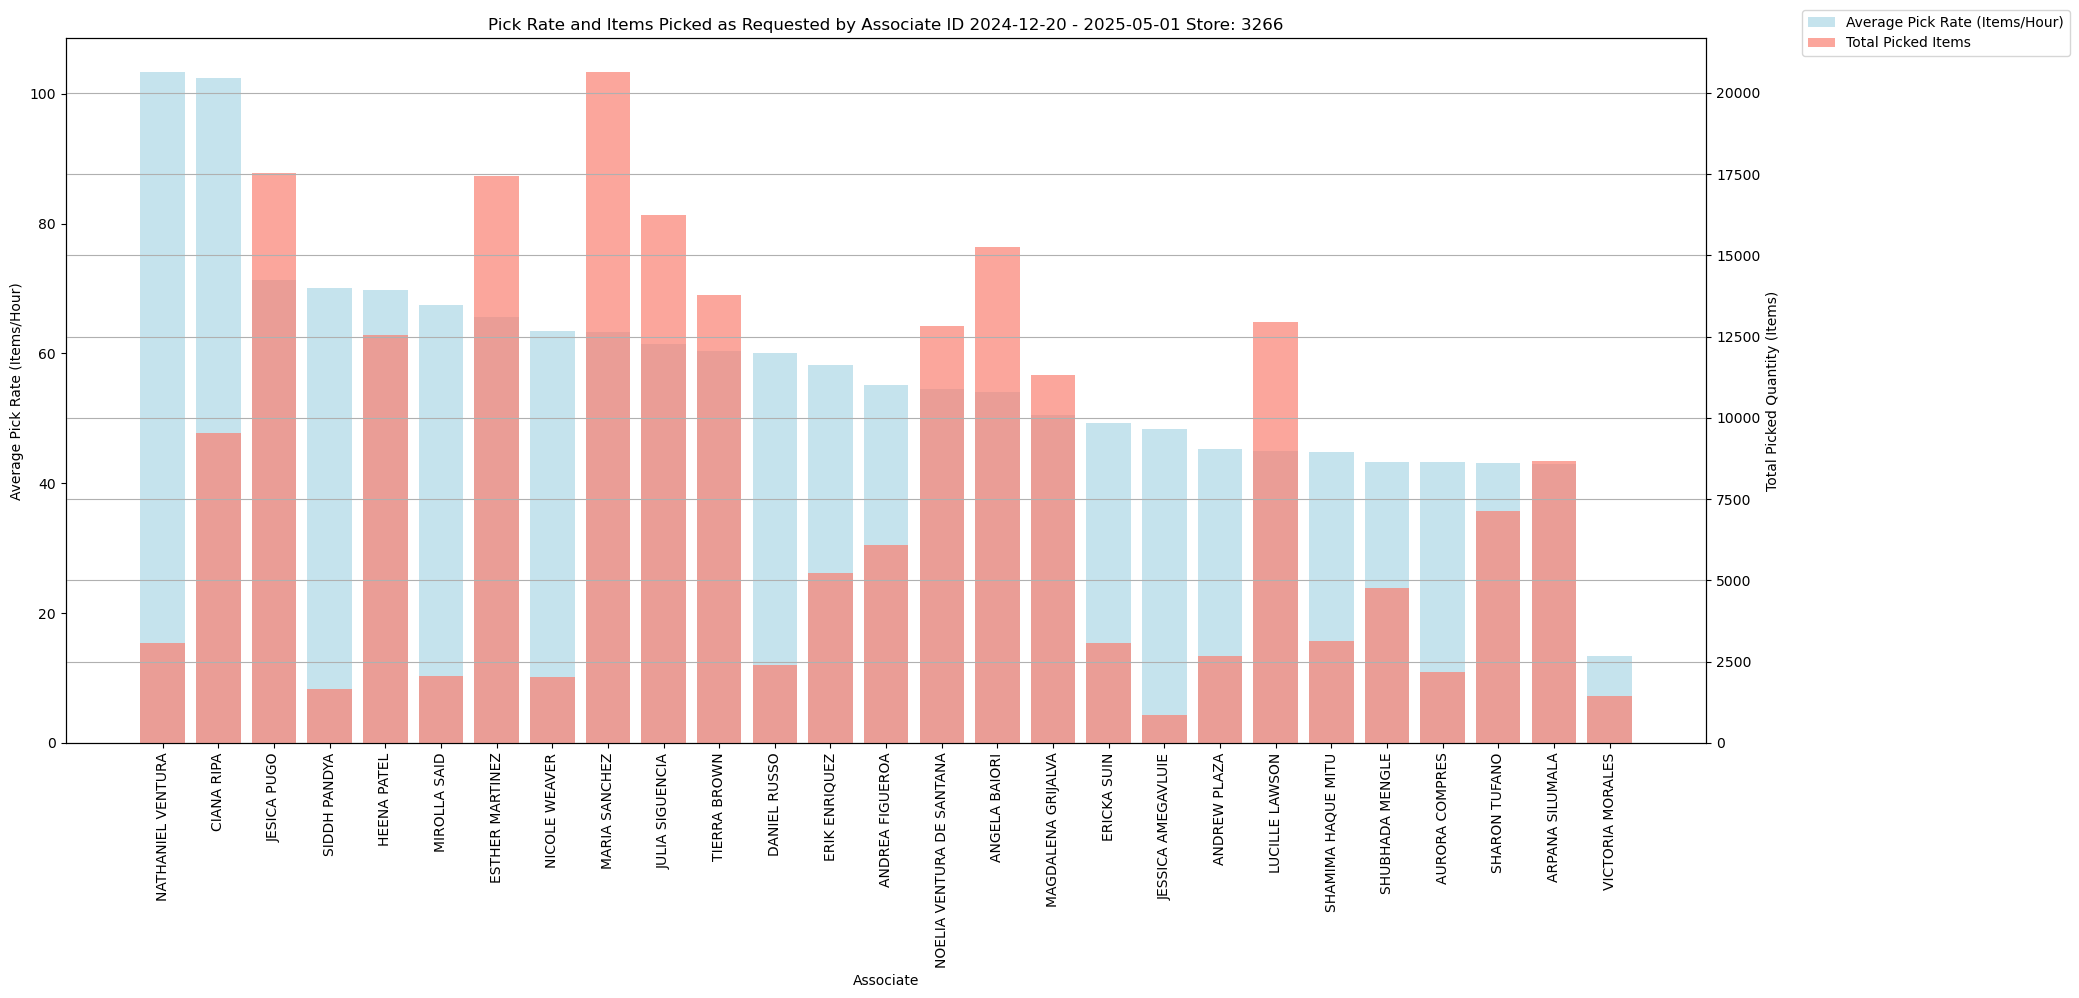

In [1297]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Pick Rate'] = pd.to_numeric(df_selected_store['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

df_selected_store = df_selected_store.loc[df_selected_store['Store #'] == selected_store, :]

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_pick_rate = df_clean.groupby('Associate')['Pick Rate'].mean().sort_values(ascending=False)
if selected_store == 3266:
    avg_pick_rate = avg_pick_rate[avg_pick_rate.index.isin(associate_list_3266)]
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()
if selected_store == 3266:
    total_picked_qty = total_picked_qty[total_picked_qty.index.isin(associate_list_3266)]

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))
avg_pick_rate.index = avg_pick_rate.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_pick_rate.index, avg_pick_rate, color='lightblue', alpha=0.7, label='Average Pick Rate (Items/Hour)')
ax1.set_xlabel('Associate')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate ID {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


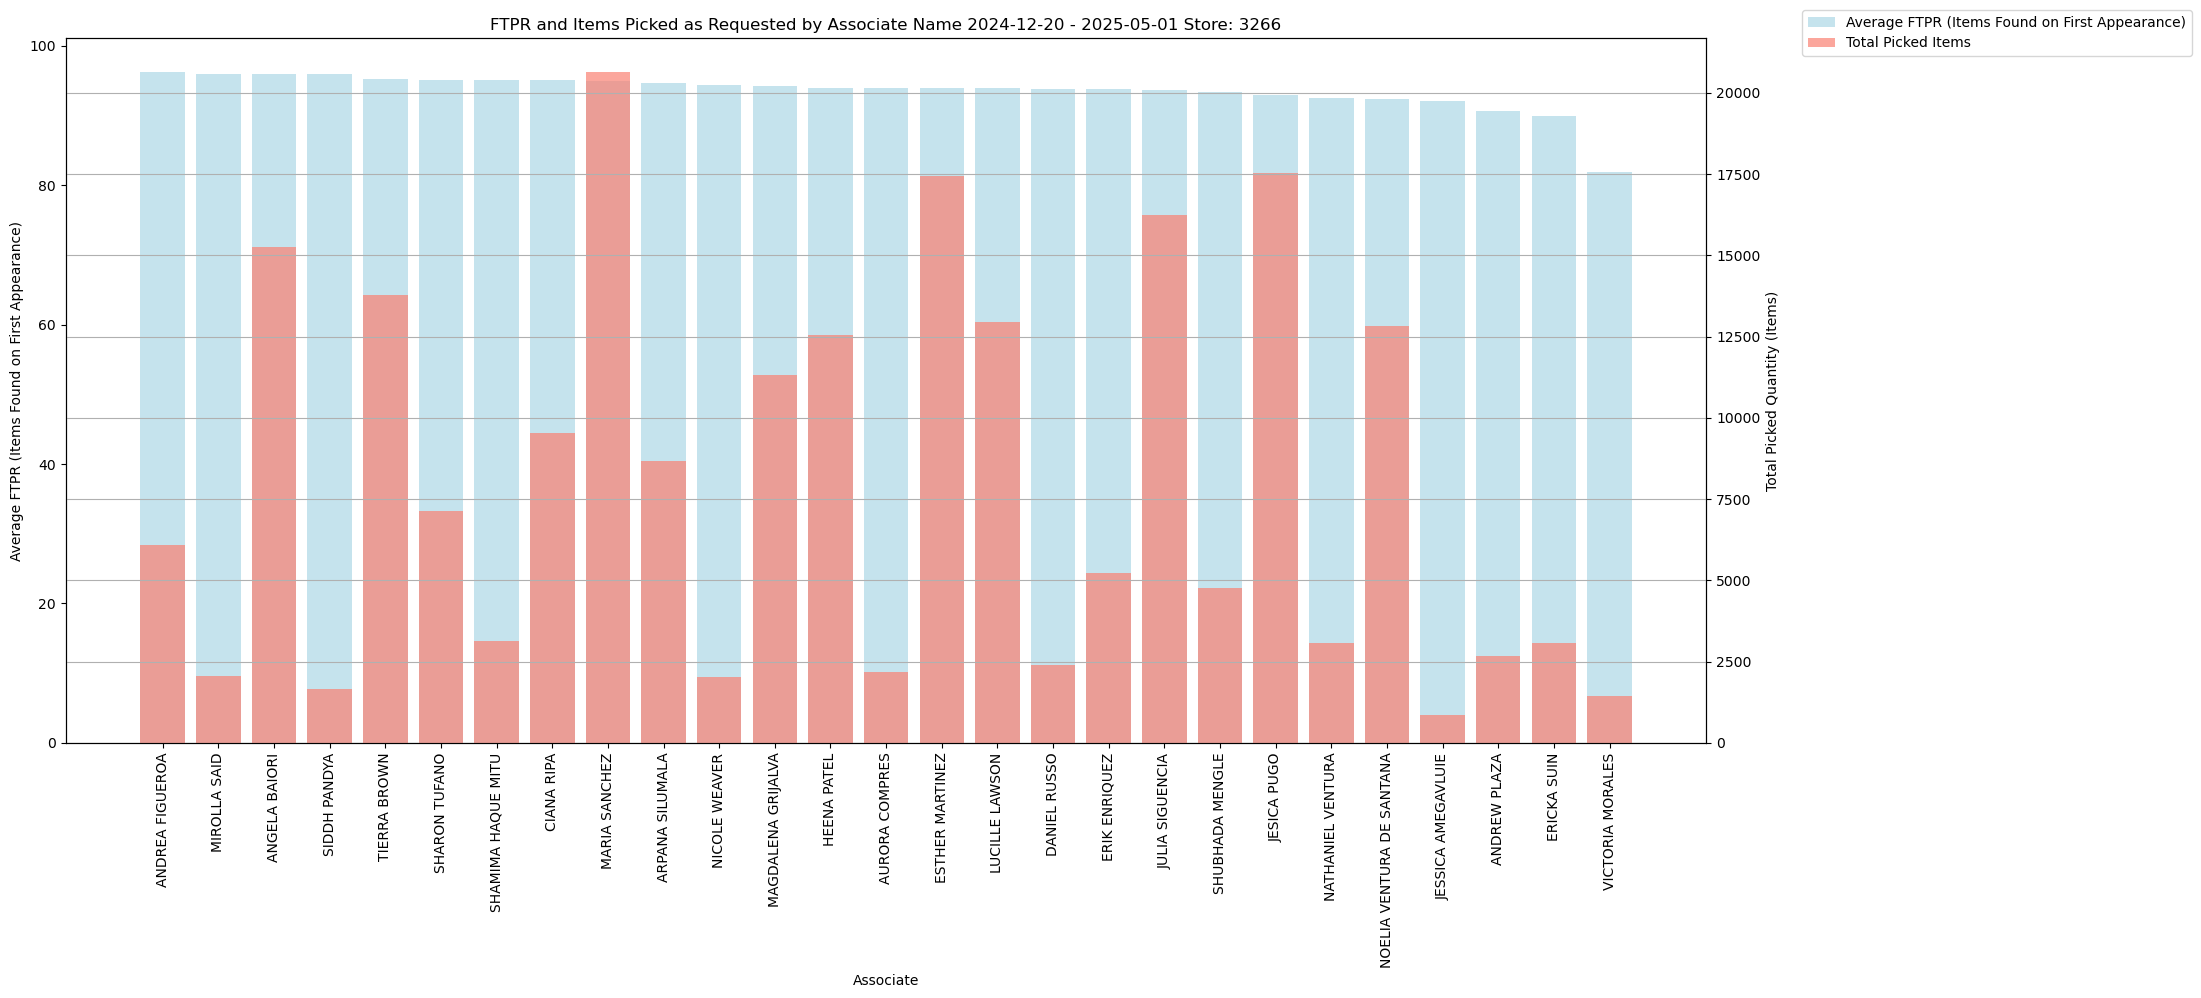

In [1298]:
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['FTPR'] = pd.to_numeric(df['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['FTPR'] = pd.to_numeric(df_selected_store['FTPR'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'FTPR'])

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_ftpr = df_clean.groupby('Associate')['FTPR'].mean().astype(float).sort_values(ascending=False)
if selected_store == 3266:
    avg_ftpr = avg_ftpr[avg_ftpr.index.isin(associate_list_3266)]
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()
if selected_store == 3266:
    total_picked_qty = total_picked_qty[total_picked_qty.index.isin(associate_list_3266)]

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(18, 10))

avg_ftpr.index = avg_ftpr.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_ftpr.index, avg_ftpr, color='lightblue', alpha=0.7, label='Average FTPR (Items Found on First Appearance)')
ax1.set_xlabel('Associate')
ax1.set_ylabel('Average FTPR (Items Found on First Appearance)')
ax1.set_title(f'FTPR and Items Picked as Requested by Associate Name {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()

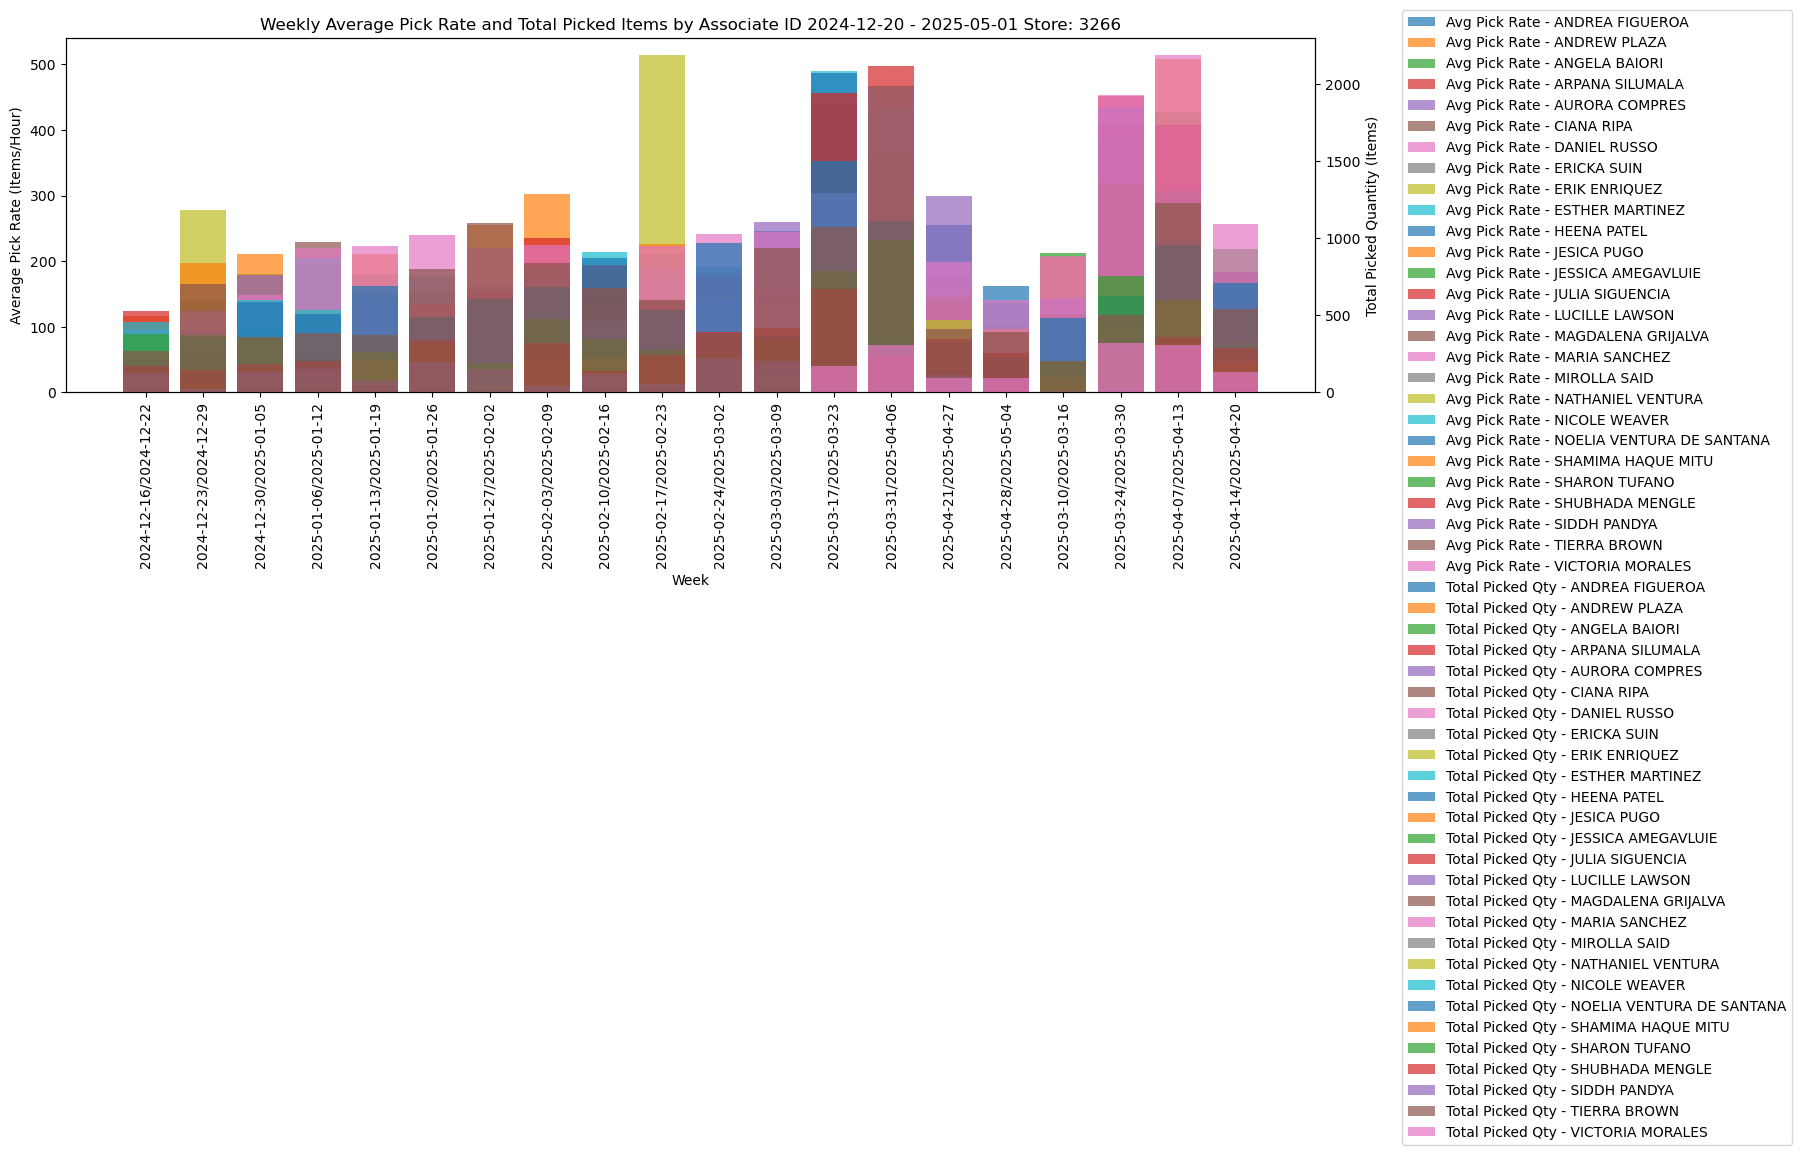

In [1299]:
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Pick Rate'] = pd.to_numeric(df['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN
# Ensure columns like 'Picked As Req Qty' and 'Pick Rate' are numeric and handle any missing data
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Pick Rate'] = pd.to_numeric(df_selected_store['Pick Rate'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'Pick Rate'])

# Grouping by Associate ID and week (using 'Day of Pick Date' for weekly grouping)
# We're using pd.Grouper to group by week and Associate ID
df_clean['Week'] = df_clean['Day of Pick Date'].dt.to_period('W')
if selected_store == 3266:
    df_clean = df_clean[df_clean['Associate'].apply(lambda x: x in associate_list_3266)]
df_clean = df_clean.drop_duplicates()

# Group by Week and Associate ID to calculate the sum of 'Picked As Req Qty' and average 'Pick Rate'
weekly_data = df_clean.groupby(['Week', 'Associate']).agg(
    avg_pick_rate=('Pick Rate', 'mean'),
    total_picked_qty=('Picked As Req Qty', 'sum')
).reset_index()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty by Week
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar plot for average Pick Rate (items per hour) by Week
for label, data in weekly_data.groupby('Associate'):
    ax1.bar(data['Week'].astype(str), data['avg_pick_rate'], label=f'Avg Pick Rate - {label}', alpha=0.7)

ax1.set_xlabel('Week')
ax1.set_ylabel('Average Pick Rate (Items/Hour)')
ax1.set_title(f'Weekly Average Pick Rate and Total Picked Items by Associate ID {oldest_pick_date} - {last_pick_date} Store: {selected_store}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()

# Bar plot for total Picked As Req Qty by Week
for label, data in weekly_data.groupby('Associate'):
    ax2.bar(data['Week'].astype(str), data['total_picked_qty'], label=f'Total Picked Qty - {label}', alpha=0.7)

ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Week
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


In [1300]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler

'''# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check class distribution in y_train
print("Class distribution in y_train:")
print(Counter(y_train))

# Check class distribution in y_test
print("\nClass distribution in y_test:")
print(Counter(y_test))

# Oversample the minority class
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Get probabilistic predictions (probabilities of the positive class)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score
threshold = 0.5  # You can adjust this threshold as needed
y_pred = (y_pred_proba >= threshold).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use probabilistic predictions here

print(f"\nAccuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")'''

'# Assuming X and y are your features and target variable\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\n# Check class distribution in y_train\nprint("Class distribution in y_train:")\nprint(Counter(y_train))\n\n# Check class distribution in y_test\nprint("\nClass distribution in y_test:")\nprint(Counter(y_test))\n\n# Oversample the minority class\nros = RandomOverSampler(random_state=42)\nX_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)\n\n# Initialize and train the model\nmodel = RandomForestClassifier(random_state=42)\nmodel.fit(X_train_resampled, y_train_resampled)\n\n# Get probabilistic predictions (probabilities of the positive class)\ny_pred_proba = model.predict_proba(X_test)[:, 1]\n\n# Convert probabilities to binary predictions for accuracy, precision, recall, and f1 score\nthreshold = 0.5  # You can adjust this threshold as needed\ny_pred = (y_pred_proba >= threshold).astype(int)\n\n# Calculate metrics\n

In [1301]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Assuming df is the DataFrame containing your data
threshold_pick_rate = 50
threshold_ftpr = 97.5
'''df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) | 
                            (df['FTPR'] > threshold_ftpr)).astype(int)'''
df['Handled_Exceptions'] = (
    (df['Pick Rate'] < threshold_pick_rate) | 
    (df['FTPR'] > threshold_ftpr) | 
    (df['Exception Qty Req to Pick'] > 0) | 
    (df['Exception Nil Pick Qty'] > 0)
).astype(int)

print(df['Handled_Exceptions'].value_counts())

features = ['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']
target = 'Handled_Exceptions'
X = df[features]
y = df[target]

# Check if there are at least two classes in y
if len(np.unique(y)) < 2:
    print("Only one class present in the target variable. Cannot calculate ROC AUC score.")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Check if there are at least two classes in both y_train and y_test
    if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
        print("Only one class present in either the training or test set. Cannot calculate ROC AUC score.")
    else:
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Calculate ROC AUC score only if there are at least two classes in y_test
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"ROC AUC: {roc_auc}")

# Perform grid search
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

# Calculate cross-validation score
cross_val_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, n_jobs=-1)
print(f"Cross-Validation Scores: {cross_val_scores}")

Handled_Exceptions
0    7829
1    5060
Name: count, dtype: int64
Accuracy: 0.8572536850271528
Precision: 0.9156327543424317
Recall: 0.7109826589595376
F1 Score: 0.8004338394793926
ROC AUC: 0.8829642419237794
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Best Score: 0.8519061305068801
Cross-Validation Scores: [0.84779447 0.85160039 0.84772066 0.85257032 0.85984481]


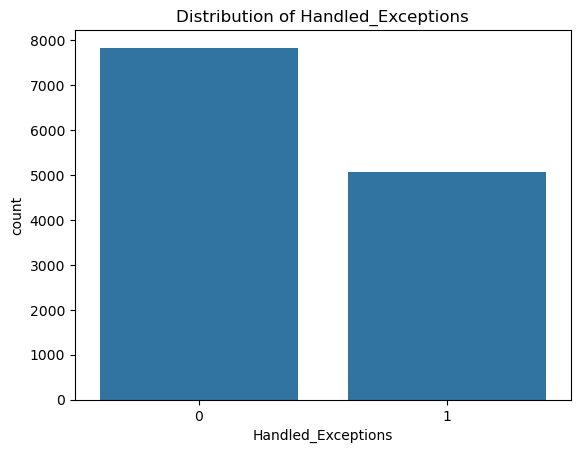

In [1302]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Handled_Exceptions', data=df)
plt.title('Distribution of Handled_Exceptions')
plt.show()


In [1303]:
start_time = time.time()
# Threshold ranges to test
threshold_pick_rate_values = np.linspace(5, 500, 8)  # Adjusted range, 100 
#print(threshold_pick_rate_values)
threshold_ftpr_values = np.linspace(70, 105, 12)       # Adjusted range, 300

# Variables to store the best thresholds and corresponding F1 score
best_thresholds = None
best_f1_score = -np.inf  # Initialize to a very low value
results = []  # Store results for each threshold combination

# Debugging: Check initial conditions
#print("Initial Threshold Values:")
#print(f"Pick Rate Thresholds: {threshold_pick_rate_values}")
#print(f"FTPR Thresholds: {threshold_ftpr_values}")

# Iterate through threshold combinations
for threshold_pick_rate in threshold_pick_rate_values:
    for threshold_ftpr in threshold_ftpr_values:
        # Create target variable based on thresholds
        df['Handled_Exceptions'] = ((df['Pick Rate'] < threshold_pick_rate) |
                                    (df['FTPR'] > threshold_ftpr)).astype(int)
        y = df['Handled_Exceptions']
        X = df[['FTPR', 'Pick Rate', 'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty']]

        # Debugging: Check class distribution
        #print(f"Testing thresholds: Pick Rate={threshold_pick_rate}, FTPR={threshold_ftpr}")
        #print(f"Class distribution in 'y': {np.unique(y, return_counts=True)}")
        
        # Skip if there is only one class in the target variable
        if len(np.unique(y)) < 2:
            #print("Skipping: Only one class present in target variable")
            continue

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Skip if train/test split results in a single class
        if len(np.unique(y_train)) < 2 or len(np.unique(y_test)) < 2:
            #print("Skipping: Only one class present in train/test sets")
            continue

        # Train a Random Forest model
        model = RandomForestClassifier(random_state=42) ############### n_jobs
        model.fit(X_train, y_train)

        # Make predictions and calculate F1 score
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred)

        # Debugging: Print F1 score for the current thresholds
        #print(f"F1 Score for thresholds {threshold_pick_rate}, {threshold_ftpr}: {f1}")

        # Update the best thresholds if current F1 is higher
        if f1 > best_f1_score:
            best_f1_score = f1
            best_thresholds = (threshold_pick_rate, threshold_ftpr)
            #print(f"Updated Best Thresholds: {best_thresholds} with F1={best_f1_score}")

        # Store the results for analysis
        results.append({
            'Pick Rate Threshold': threshold_pick_rate,
            'FTPR Threshold': threshold_ftpr,
            'F1 Score': f1
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Display the best thresholds and their corresponding F1 score
if best_thresholds is None:
    print("No valid threshold combination was found. Adjust thresholds or data distribution.")
else:
    print(f"Best Thresholds: Pick Rate={best_thresholds[0]}, FTPR={best_thresholds[1]}")
    print(f"Best F1 Score: {best_f1_score}")

# Optional: Summarize all tested threshold combinations
if not results_df.empty:
    print("Summary of Top Threshold Combinations:")
    print(results_df.sort_values(by='F1 Score', ascending=False).head())
else:
    print("No valid results were generated.")
end_time = time.time()
print(f'time to run model for {threshold_pick_rate_values.size * threshold_ftpr_values.size} combinations: {end_time - start_time}')

Best Thresholds: Pick Rate=5.0, FTPR=70.0
Best F1 Score: 1.0
Summary of Top Threshold Combinations:
    Pick Rate Threshold  FTPR Threshold  F1 Score
0              5.000000       70.000000       1.0
28           146.428571       82.727273       1.0
30           146.428571       89.090909       1.0
31           146.428571       92.272727       1.0
37           217.142857       79.545455       1.0
time to run model for 96 combinations: 15.795581817626953


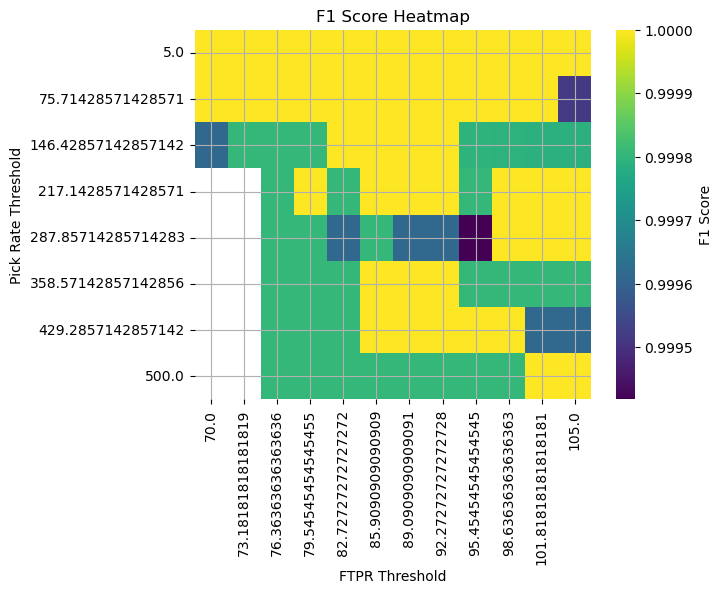

In [1304]:
# Ensure results_df is not empty
if not results_df.empty:
    # Rename columns for compatibility with pivot (optional, just for consistency)
    results_df.rename(columns={
        'Pick Rate Threshold': 'pick_rate',
        'FTPR Threshold': 'ftpr',
        'F1 Score': 'f1'
    }, inplace=True)

    # Create pivot table
    pivot_table = results_df.pivot(index='pick_rate', columns='ftpr', values='f1')

    # Generate heatmap
    sns.heatmap(pivot_table, annot=False, fmt=".3f", cmap="viridis", cbar_kws={'label': 'F1 Score'})
    plt.title("F1 Score Heatmap")
    plt.xlabel("FTPR Threshold")
    plt.ylabel("Pick Rate Threshold")
    plt.grid()
    plt.show()
else:
    print("No data to plot. Ensure valid results are generated before creating a heatmap.")

In [1305]:
print(df['Pick Rate'].describe())
print(df['FTPR'].describe())
print(df['Handled_Exceptions'].value_counts())
feature_importances = model.feature_importances_
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")


count    12889.000000
mean        90.104515
std         48.442356
min          0.000000
25%         59.400000
50%         85.800000
75%        112.700000
max        736.400000
Name: Pick Rate, dtype: float64
count    12889.000000
mean        89.958284
std          9.543825
min          0.000000
25%         87.640000
50%         91.640000
75%         94.780000
max        157.140000
Name: FTPR, dtype: float64
Handled_Exceptions
1    12867
0       22
Name: count, dtype: int64
FTPR: 0.005697862664926737
Pick Rate: 0.8922042414787271
Pick Hours: 0.056956852440223894
Qty Req to Pick: 0.020253628808425364
Picked As Req Qty: 0.024887414607696827


<h2>Composite Scoring Starts Here</h2>
<h4>Composite Scoring Modifiers for standardized evaluation throughtout notebook</h4>
<ul>pickrate_modifier</ul>
<ul>ftpr_modifier</ul>
<ul>picked_as_req_modifier</ul>
<ul>pick_hours_modifier

<h1>Composite Score Modifiers</h1>

In [1306]:
pickrate_modifier = 0.4
ftpr_modifier = 0.2
picked_as_req_modifier = 0.2
pick_hours_modifier = 0.5
picked_as_req_composite_threshold = 50

<h3>Weekly Averages (WTD)</h3>

In [1307]:
import datetime as dt
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")
week_of_interest = df["Week"].max() #defaults to most recent week

df['Pick Hours'] = df['Pick Hours'].astype(float)
# Filter the data for the specified week
df_week = df[df['Week'] == week_of_interest]
df_week = df_week.loc[df_week['Store #'] == selected_store, :]
df_week = df_week.drop_duplicates()

this_week_df = df_week
avdf = this_week_df.groupby(['Associate ID', 'Associate']).mean(numeric_only=True)
avdf['Week'] = week_of_interest
avdf['Custom Week Start'] = df_week['Custom Week Start'].max()
avdf['Custom Week End'] = df_week['Custom Week End'].max()
print(f'avdf columns: {avdf.columns}')
print(f'df columns: {df.columns}')
# Specify the week for analysis
#week_of_interest = '2025-01-18 to 2025-01-24' #manual range
#week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
#avdf_week = avdf[avdf['Week'] == week_of_interest]
print(f'avdf rows: {avdf.shape[0]}')
avdf.head(avdf.shape[0])

avdf columns: Index(['Store #', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Pick Hours', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'Qty Req to Pick', 'Day of Week #', 'Handled_Exceptions', 'Week', 'Custom Week Start', 'Custom Week End'], dtype='object')
df columns: Index(['Associate ID', 'Associate Name', 'Store #', 'Day of Pick Date', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Pick Hours', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Pick Assgn Qty', 'First Disp Pick Qty', 'Qty Req to Pick', 'Associate', 'Day of Week #', 'Day of Week', 'Custom Week Start', 'Custom Week End', 'Week', 'Handled_Exceptions'], dtype='object')
avdf rows: 27


,,Store #,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,Qty Req to Pick,Day of Week #,Handled_Exceptions,Week,Custom Week Start,Custom Week End
Associate ID,Associate,,,,,,,,,,,,,,,,,,,,
a0b0ad9,ANGELA BAIORI,3266.0,92.503333,230.333333,210.666667,53.900000,4.323333,217.000000,7.000000,0.0,8.666667,2.333333,1.000000,0.000000,1.333333,230.333333,3.666667,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
a0c02mv,AURORA COMPRES,3266.0,85.120000,86.000000,81.500000,22.550000,2.415000,81.500000,0.000000,0.0,2.500000,0.000000,0.000000,0.000000,0.000000,86.000000,4.500000,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
a0f0grp,ANDREA FIGUEROA,3266.0,93.336667,132.333333,124.000000,32.666667,3.733333,123.666667,2.333333,0.0,5.333333,0.000000,0.000000,0.000000,0.000000,132.333333,2.000000,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
a0p0fc6,ANDREW PLAZA,3266.0,79.010000,243.000000,192.000000,40.800000,5.570000,224.000000,3.000000,0.0,11.000000,2.000000,1.000000,0.000000,1.000000,243.000000,6.000000,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
a0s1jgx,ARPANA SILUMALA,3266.0,90.910000,77.000000,70.000000,24.100000,2.940000,70.000000,1.000000,0.0,8.000000,0.000000,0.000000,0.000000,0.000000,77.000000,0.000000,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
c0c116s,CHRISTINA CUCITRO,3266.0,100.000000,2.000000,2.000000,80.850000,0.030000,2.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.500000,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
c0r0k4h,CIANA RIPA,3266.0,94.050000,106.000000,99.500000,101.350000,1.045000,100.500000,5.500000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,106.000000,1.000000,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
d0c0as3,DANIELLE CASIANO,3266.0,100.000000,32.000000,32.000000,43.300000,0.740000,32.000000,0.000000,0.0,0.000000,18.000000,6.000000,0.000000,12.000000,32.000000,6.000000,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02
d0r0khi,DANIEL RUSSO,3266.0,94.973333,105.666667,98.000000,72.766667,1.413333,98.000000,1.000000,0.0,7.333333,0.000000,0.000000,0.000000,0.000000,105.666667,4.666667,1.0,2025-04-26 to 2025-05-02,2025-04-26,2025-05-02


<h3>Weekly Averages (LW)</h3>

In [1308]:
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d")

df_selected_store = df.loc[df['Store #'] == selected_store, :]
# Find the last full week's end date (before today)
last_full_week_end = df['Custom Week End'][df['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df['Custom Week Start'][df['Custom Week End'] == last_full_week_end].max()

df_lw = df[(df['Custom Week End'] == last_full_week_end) | (df['Custom Week Start'] == last_full_week_start)] #All stores in market 178
df_lw = df_selected_store[(df_selected_store['Custom Week End'] == last_full_week_end) | (df_selected_store['Custom Week Start'] == last_full_week_start)]

avdf = df_lw.groupby(['Associate ID', 'Associate']).mean(numeric_only=True)
avdf['Week'] = last_full_week_start.strftime('%Y-%m-%d') + " to " + last_full_week_end.strftime('%Y-%m-%d')
avdf['Custom Week Start'] = last_full_week_start
avdf['Custom Week End'] = last_full_week_end
print(f'avdf row count: {avdf.shape[0]}')
avdf.head(avdf.shape[0])


avdf row count: 28


,,Store #,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,Substitution Qty,Ovrd Qty,Nil Pick Qty,Exception Qty Req to Pick,Exception Picked As Req Qty,Exception Substitution Qty,Exception Nil Pick Qty,Qty Req to Pick,Day of Week #,Handled_Exceptions,Week,Custom Week Start,Custom Week End
Associate ID,Associate,,,,,,,,,,,,,,,,,,,,
a0b0ad9,ANGELA BAIORI,3266.0,94.422500,171.250000,160.250000,52.525000,4.190000,161.250000,5.000000,0.0,6.000000,1.750000,0.000000,0.25,1.500000,171.250000,3.750000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
a0c02mv,AURORA COMPRES,3266.0,87.645000,97.500000,85.500000,42.700000,2.085000,85.500000,1.500000,0.0,17.000000,0.000000,0.000000,0.00,0.000000,97.500000,4.500000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
a0f0grp,ANDREA FIGUEROA,3266.0,93.313333,32.666667,31.666667,30.866667,1.056667,31.666667,0.666667,0.0,1.000000,0.000000,0.000000,0.00,0.000000,32.666667,3.000000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
a0p0fc6,ANDREW PLAZA,3266.0,81.990000,161.000000,132.000000,41.000000,3.480000,134.000000,9.000000,0.0,18.000000,0.000000,0.000000,0.00,0.000000,161.000000,5.000000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
a0s1jgx,ARPANA SILUMALA,3266.0,90.962500,77.500000,68.750000,37.975000,1.910000,72.750000,2.250000,0.0,3.250000,0.000000,0.000000,0.00,0.000000,77.500000,2.000000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
c0c116s,CHRISTINA CUCITRO,3266.0,83.333333,4.500000,4.166667,134.966667,0.035000,4.166667,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,4.500000,2.166667,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
c0r0k4h,CIANA RIPA,3266.0,94.935000,84.500000,79.250000,93.300000,1.155000,80.000000,1.750000,0.0,1.000000,2.250000,1.250000,0.00,1.000000,84.500000,4.250000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
d0c0as3,DANIELLE CASIANO,3266.0,100.000000,18.000000,18.000000,70.900000,0.250000,18.000000,0.000000,0.0,0.000000,6.000000,0.000000,0.00,6.000000,18.000000,0.000000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25
d0r0khi,DANIEL RUSSO,3266.0,88.653333,62.666667,56.666667,50.966667,1.143333,56.666667,2.333333,0.0,2.000000,0.000000,0.000000,0.00,0.000000,62.666667,2.000000,1.0,2025-04-19 to 2025-04-25,2025-04-19,2025-04-25


In [1309]:
# Define a composite score for each row (or use one metric like 'Pick Rate' directly)
df['Composite Score'] = (
    picked_as_req_modifier * df['Picked As Req Qty'] +  # Weight for Items Picked
    pickrate_modifier * df['Pick Rate'] +       # Weight for Pick Rate
    ftpr_modifier * df['FTPR'] +              # Weight for FTPR
    pick_hours_modifier * df['Pick Hours'].astype(float)  # Weight for Pick Hours
)

# Find the best day for each associate
#best_days = df.loc[df.groupby('Associate Name')['Composite Score'].idxmax()] #all stores in market 178
df_selected_store = df.loc[df['Store #'] == selected_store, :]
best_days = df_selected_store.loc[df_selected_store.groupby('Associate')['Composite Score'].idxmax()]

# Sort associates by their best day's composite score unfiltered
top_associates = best_days.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])
if selected_store == 3266:
    top_associates = top_associates[top_associates['Associate'].apply(lambda x: x in associate_list_3266)]


# Display the top associates and their best day
print(top_associates[['Associate', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

# Filter out associates with fewer than a certain number of items picked
best_days_filtered = best_days[best_days['Picked As Req Qty'] > picked_as_req_composite_threshold]

# Sort associates by their best day's composite score filtered
top_associates_filtered = best_days_filtered.sort_values(by=['Composite Score', 'Day of Pick Date'], ascending=[False, False])

# Display the top associates and their best day after pick qty filtered
print(f'\nAfter filtering out Associates with < 50 Picked As Req Qty')
print(top_associates_filtered[['Associate', 'Day of Pick Date', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']].head(10))

                      Associate Day of Pick Date  Picked As Req Qty  Pick Rate    FTPR  Composite Score
3209          NATHANIEL VENTURA       2025-02-21                  1      514.0  100.00          225.800
177                  CIANA RIPA       2025-01-13                192      300.0   83.12          175.354
2974                HEENA PATEL       2025-03-15                522      102.3   97.56          167.417
810                TIERRA BROWN       2025-02-02                469      105.0   99.79          158.018
2874  NOELIA VENTURA DE SANTANA       2025-03-02                460       81.0   92.47          145.814
3073                JESICA PUGO       2025-02-08                407       88.0   92.43          137.466
3114              MARIA SANCHEZ       2025-02-28                373       90.0   95.29          131.733
1891            JULIA SIGUENCIA       2025-04-04                373       85.4   97.35          130.450
2959              ANGELA BAIORI       2025-03-16                

In [1310]:
#df.loc[df["Associate ID"] == 'n0v0359']

<h2>Top Composite Score of the Week</h2>

In [1311]:
#Top Associate Per Week
# Aggregate metrics for each associate per week
df_picked_as_req_qty_filter = df_selected_store[df_selected_store['Picked As Req Qty'] > picked_as_req_composite_threshold].copy()
cols_to_convert = ['Picked As Req Qty', 'Pick Rate', 'FTPR', 'Pick Hours']
df_picked_as_req_qty_filter[cols_to_convert] = df_picked_as_req_qty_filter[cols_to_convert].apply(pd.to_numeric, errors='coerce').copy()
weekly_performance = df_picked_as_req_qty_filter.groupby(['Custom Week Start', 'Associate'], as_index=False).agg({
    'Picked As Req Qty': 'sum',  # Total items picked in the week
    'Pick Rate': 'mean',       # Average pick rate for the week
    'FTPR': 'mean',            # Average FTPR for the week
    'Pick Hours': 'sum'        # Total hours worked in the week (optional)
})

# Add a composite score to rank performance in each week
weekly_performance['Composite Score'] = (
    picked_as_req_modifier * weekly_performance['Picked As Req Qty'] +
    pickrate_modifier * weekly_performance['Pick Rate'] +
    ftpr_modifier * weekly_performance['FTPR'] +
    pick_hours_modifier * weekly_performance['Pick Hours']
)

# Sort associates within each week by Composite Score
weekly_performance = weekly_performance.sort_values(by=['Custom Week Start', 'Composite Score'], ascending=[True, False])

# Add a rank column within each week
weekly_performance['Rank'] = weekly_performance.groupby('Custom Week Start')['Composite Score'].rank(method='dense', ascending=False)

# Get the top associate for each week
top_associates_per_week = weekly_performance[weekly_performance['Rank'] == 1]

# Display the results
#print(top_associates_per_week[['Custom Week Start', 'Associate Name', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Composite Score']])
print(f'\nTop Associate Per Week (Composite Score)')
top_associates_per_week[['Custom Week Start', 'Associate', 'Picked As Req Qty', 'Pick Rate', 'FTPR', 'Pick Hours', 'Composite Score']]



Top Associate Per Week (Composite Score)


,Custom Week Start,Associate,Picked As Req Qty,Pick Rate,FTPR,Pick Hours,Composite Score
2,2024-12-14,JULIA SIGUENCIA,336,68.000000,92.020000,4.99,115.299000
19,2024-12-21,JESICA PUGO,771,62.200000,92.556000,14.34,204.761200
45,2024-12-28,JESICA PUGO,921,85.000000,93.254000,13.54,243.620800
69,2025-01-04,MARIA SANCHEZ,896,62.500000,95.310000,14.58,230.552000
91,2025-01-11,MARIA SANCHEZ,883,50.400000,93.936000,17.82,224.457200
110,2025-01-18,MARIA SANCHEZ,1048,72.000000,96.088000,16.13,265.682600
128,2025-01-25,MARIA SANCHEZ,916,65.250000,97.060000,14.19,235.807000
144,2025-02-01,JESICA PUGO,1216,81.000000,95.465000,15.44,302.413000
163,2025-02-08,JESICA PUGO,936,79.000000,93.292500,11.85,243.383500
188,2025-02-15,MARIA SANCHEZ,990,66.600000,95.292000,16.23,251.813400


<h2>WTD Composite Score Rankings</h2>

In [1312]:
# Calculate Composite Score (can modify the weights here as needed)
df['Composite Score'] = (df['Pick Rate'] * pickrate_modifier) + (df['FTPR'] * ftpr_modifier) + (df['Picked As Req Qty'] * picked_as_req_modifier) + (df['Pick Hours'].astype(float) * pick_hours_modifier)

# Filter rows where Picked As Req Qty is less than num
df_selected_store = df.loc[df['Store #'] == selected_store, :]  # Updated to use selected_store
num = 1
df_filtered = df[df['Picked As Req Qty'] >= picked_as_req_composite_threshold] #all stores in market 178
df_filtered = df_selected_store[df_selected_store['Picked As Req Qty'] >= picked_as_req_composite_threshold]

# Specify the week for analysis
week_of_interest = '2025-01-18 to 2025-01-24' #manual range
week_of_interest = df["Week"].max() #defaults to most recent week

# Filter the data for the specified week
df_week = df_filtered[df_filtered['Week'] == week_of_interest]

# Get the best day per associate within the week based on Composite Score
best_day_of_week = df_week.loc[df_week.groupby('Associate')['Composite Score'].idxmax()]
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
if selected_store == 3266:
    best_day_of_week = best_day_of_week[best_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]

# Rank the associates based on Composite Score within the week
best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

# Sort by rank (ascending gives top performer first)
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display the results
print('WTD Composite Scores')
print(f'Week: {week_of_interest}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']])
best_day_of_week_printdf = best_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']]
best_day_of_week_printdf.head(30)

WTD Composite Scores
Week: 2025-04-26 to 2025-05-02


,Associate,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Pick Hours,Composite Score,Rank
1973,HEENA PATEL,2025-04-29,72.5,86.92,355,5.02,119.894,1.0
1725,MARIA SANCHEZ,2025-05-01,57.1,95.92,285,5.02,101.534,2.0
1993,ANGELA BAIORI,2025-04-27,49.6,88.42,286,5.99,97.719,3.0
1921,ESTHER MARTINEZ,2025-04-30,66.8,96.54,226,3.41,92.933,4.0
1999,ERIK ENRIQUEZ,2025-04-27,46.4,88.74,262,5.76,91.588,5.0
2012,LUCILLE LAWSON,2025-04-26,55.0,97.03,229,4.18,89.296,6.0
1986,JESICA PUGO,2025-04-28,56.3,91.46,229,4.07,88.647,7.0
1996,DANIEL RUSSO,2025-04-27,79.4,93.05,174,2.21,86.275,8.0
1982,CIANA RIPA,2025-04-28,110.2,92.31,108,1.06,84.672,9.0
2013,MAGDALENA GRIJALVA,2025-04-26,40.9,94.26,231,5.70,84.262,10.0


<h2>Composite Score Rankings LW</h2>

In [1313]:
# Calculate Composite Score
df['Composite Score'] = (
    (df['Pick Rate'] * pickrate_modifier) + 
    (df['FTPR'] * ftpr_modifier) + 
    (df['Picked As Req Qty'] * picked_as_req_modifier) +
    (df['Pick Hours'] * pick_hours_modifier)
)

df_selected_store = df.loc[df['Store #'] == selected_store, :]
# Set today’s date
today = datetime.now()

'''# Find the last full week's end date (before today)
last_full_week_end = df_selected_store['Custom Week End'][df_selected_store['Custom Week End'] < today].max()

# Get the corresponding start date for that week
last_full_week_start = df_selected_store['Custom Week Start'][df_selected_store['Custom Week End'] == last_full_week_end].max()
'''
# Set today's date and get the current week start (assuming weeks start on Monday)
current_week_start = today - timedelta(days=today.weekday())

# Get unique week ranges (start and end), and sort by end date
weeks = df_selected_store[['Custom Week Start', 'Custom Week End']].drop_duplicates()
weeks = weeks.sort_values(by='Custom Week End')

# Filter to only weeks that ended before the current week
full_weeks = weeks[weeks['Custom Week End'] < current_week_start]

# Get the last full week
if not full_weeks.empty:
    last_full_week_end = full_weeks['Custom Week End'].max()
    last_full_week_start = full_weeks.loc[full_weeks['Custom Week End'] == last_full_week_end, 'Custom Week Start'].iloc[0]
else:
    raise ValueError("No full weeks found before current week.")

# Filter data for the last full week
df_week = df_selected_store[(df_selected_store['Custom Week Start'] == last_full_week_start) & (df_selected_store['Custom Week End'] == last_full_week_end)]

# Get the best day per associate within the last full week based on Composite Score
best_day_of_week = df_week.loc[df_week.groupby('Associate')['Composite Score'].idxmax()].copy()

# Filter out associates with fewer than the composite threshold
best_day_of_week = best_day_of_week.loc[best_day_of_week['Picked As Req Qty'] >= picked_as_req_composite_threshold]
if selected_store == 3266:
    best_day_of_week = best_day_of_week[best_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]
# Rank associates by Composite Score (descending order)
best_day_of_week['Rank'] = best_day_of_week['Composite Score'].rank(ascending=False, method='min')

# Sort by rank
best_day_of_week_sorted = best_day_of_week.sort_values(by='Rank')

# Display results
print('LW Composite Scores')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
best_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(30)

LW Composite Scores
Week: 2025-04-19 - 2025-04-25


,Associate,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite Score,Rank
2067,HEENA PATEL,2025-04-23,80.6,96.21,334,120.382,1.0
2044,NATHANIEL VENTURA,2025-04-25,111.6,95.41,212,107.077,2.0
2165,ESTHER MARTINEZ,2025-04-19,64.3,96.92,283,103.944,3.0
2168,MARIA SANCHEZ,2025-04-19,51.1,94.46,290,100.237,4.0
2129,NOELIA VENTURA DE SANTANA,2025-04-20,61.1,91.94,253,95.598,5.0
2037,JULIA SIGUENCIA,2025-04-25,60.4,90.60,251,94.580,6.0
2065,ERIK ENRIQUEZ,2025-04-23,77.3,95.14,179,86.938,7.0
2130,TIERRA BROWN,2025-04-20,72.3,92.75,181,85.020,8.0
2060,ANGELA BAIORI,2025-04-23,43.4,93.85,229,84.640,9.0
2068,MAGDALENA GRIJALVA,2025-04-23,51.4,93.51,216,84.632,10.0


<h2>Lowest Performing Associates by Day LW (Composite Score)</h2>

In [1314]:
# Get the best day per associate within the last full week based on Composite Score
worst_day_of_week = df_week.loc[df_week.groupby('Associate')['Composite Score'].idxmin()].copy()
if selected_store == 3266:
    worst_day_of_week = worst_day_of_week[worst_day_of_week['Associate'].apply(lambda x: x in associate_list_3266)]

# Rank associates by Composite Score (descending order)
worst_day_of_week['Rank'] = worst_day_of_week['Composite Score'].rank(ascending=True, method='min')

# Sort by rank
worst_day_of_week_sorted = worst_day_of_week.sort_values(by='Rank', ascending=True)

# Display results
print('Lowest Performing Associates by Day LW (Composite Score)')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
worst_day_of_week_sorted[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']].head(15)

Lowest Performing Associates by Day LW (Composite Score)
Week: 2025-04-19 - 2025-04-25


,Associate,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Pick Hours,Composite Score,Rank
2045,ANDREA FIGUEROA,2025-04-24,6.4,83.33,5,0.78,20.616,1.0
2042,VICTORIA MORALES,2025-04-25,9.0,84.21,16,1.78,24.532,2.0
2085,SIDDH PANDYA,2025-04-22,20.9,88.89,8,0.38,27.928,3.0
2125,ERICKA SUIN,2025-04-20,41.4,64.29,9,0.22,31.328,4.0
2121,ARPANA SILUMALA,2025-04-20,32.1,100.00,21,0.65,37.365,5.0
2170,NOELIA VENTURA DE SANTANA,2025-04-19,47.9,72.00,21,0.48,38.000,6.0
2084,SHAMIMA HAQUE MITU,2025-04-22,41.3,94.44,17,0.41,39.013,7.0
2126,ERIK ENRIQUEZ,2025-04-20,34.1,92.16,47,1.38,42.162,8.0
2118,SHUBHADA MENGLE,2025-04-21,22.6,93.06,68,3.06,42.782,9.0
2074,DANIEL RUSSO,2025-04-22,49.8,85.11,40,0.86,45.372,10.0


In [1315]:
df.loc[(df['Associate'] == 'MAGDALENA GRIJALVA') & (df['Week'] == '2025-04-12 to 2025-04-18')]

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,First Disp Pick Qty,Qty Req to Pick,Associate,Day of Week #,Day of Week,Custom Week Start,Custom Week End,Week,Handled_Exceptions,Composite Score
2181,m0g065v,MAGDALENA GRIJALVA,3266,2025-04-18,94.44,198,187,62.8,3.15,187,...,0,198,MAGDALENA GRIJALVA,4,Friday,2025-04-12,2025-04-18,2025-04-12 to 2025-04-18,1,82.983
2196,m0g065v,MAGDALENA GRIJALVA,3266,2025-04-17,89.76,205,184,47.7,3.98,184,...,0,205,MAGDALENA GRIJALVA,3,Thursday,2025-04-12,2025-04-18,2025-04-12 to 2025-04-18,1,75.822
2210,m0g065v,MAGDALENA GRIJALVA,3266,2025-04-16,92.89,197,183,59.4,3.13,183,...,0,197,MAGDALENA GRIJALVA,2,Wednesday,2025-04-12,2025-04-18,2025-04-12 to 2025-04-18,1,80.503
2224,m0g065v,MAGDALENA GRIJALVA,3266,2025-04-15,100.00,17,17,53.8,0.32,17,...,0,17,MAGDALENA GRIJALVA,1,Tuesday,2025-04-12,2025-04-18,2025-04-12 to 2025-04-18,1,45.080


<h2>Lowest FTPR Associates for LW</h2>

In [1316]:
lowest_ftpr = df_week.loc[df_week.groupby('Associate')['FTPR'].idxmin()].copy()
#lowest_ftpr = df_week.loc[df_week.groupby('Associate Name')['FTPR'] <= 90.0].copy()

lowest_ftpr = lowest_ftpr.loc[lowest_ftpr['FTPR'] <= 90.5]
lowest_ftpr = lowest_ftpr.drop_duplicates()
if selected_store == 3266:
    lowest_ftpr = lowest_ftpr[lowest_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
# Rank associates by Composite Score (descending order)
lowest_ftpr['Rank'] = lowest_ftpr['FTPR'].rank(ascending=True, method='min')
lowest_ftpr = lowest_ftpr.sort_values(by='FTPR', ascending=True)
# Display results
print('Lowest FTPR LW <= 90.5%')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
#print(best_day_of_week_sorted[['Associate Name', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']].head(15))
lowest_ftpr[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']]


Lowest FTPR LW <= 90.5%
Week: 2025-04-19 - 2025-04-25


,Associate,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Pick Hours,Composite Score,Rank
2125,ERICKA SUIN,2025-04-20,41.4,64.29,9,0.22,31.328,1.0
2170,NOELIA VENTURA DE SANTANA,2025-04-19,47.9,72.00,21,0.48,38.000,2.0
2172,VICTORIA MORALES,2025-04-19,14.1,78.57,33,2.35,29.129,3.0
2160,ANDREW PLAZA,2025-04-19,41.0,81.99,134,3.48,61.338,4.0
2045,ANDREA FIGUEROA,2025-04-24,6.4,83.33,5,0.78,20.616,5.0
2074,DANIEL RUSSO,2025-04-22,49.8,85.11,40,0.86,45.372,6.0
2080,LUCILLE LAWSON,2025-04-22,43.5,85.71,126,2.99,61.237,7.0
2128,JESICA PUGO,2025-04-20,37.1,85.92,123,3.48,58.364,8.0
2056,NATHANIEL VENTURA,2025-04-24,69.0,86.27,45,0.70,54.204,9.0
2075,ERIK ENRIQUEZ,2025-04-22,38.9,86.44,53,1.47,44.183,10.0


<h1>All FTPR <= 90.0% LW</h1>

In [1317]:
# Filter rows where FTPR is <= 90
total_below_90 = df_week.loc[df_week['FTPR'] <= 90.0, :].copy()

# Add a 'Rank' column based on FTPR, lower FTPR gets higher rank
if selected_store == 3266:
    total_below_90 = total_below_90[total_below_90['Associate'].apply(lambda x: x in associate_list_3266)]
total_below_90['Rank'] = total_below_90['FTPR'].rank(ascending=True, method='min')
total_below_90 = total_below_90.sort_values(by='Rank', ascending=True)
total_below_90 = total_below_90.drop_duplicates()
print(f'All FTPR <= 90.0 % for LW')
print(f'Week: {last_full_week_start.date()} - {last_full_week_end.date()}')
total_below_90[['Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Pick Hours', 'Composite Score', 'Rank']]


All FTPR <= 90.0 % for LW
Week: 2025-04-19 - 2025-04-25


,Associate,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Pick Hours,Composite Score,Rank
2125,ERICKA SUIN,2025-04-20,41.4,64.29,9,0.22,31.328,1.0
2170,NOELIA VENTURA DE SANTANA,2025-04-19,47.9,72.00,21,0.48,38.000,2.0
2172,VICTORIA MORALES,2025-04-19,14.1,78.57,33,2.35,29.129,3.0
2160,ANDREW PLAZA,2025-04-19,41.0,81.99,134,3.48,61.338,4.0
2058,VICTORIA MORALES,2025-04-24,16.3,82.61,19,1.16,27.422,5.0
2045,ANDREA FIGUEROA,2025-04-24,6.4,83.33,5,0.78,20.616,6.0
2042,VICTORIA MORALES,2025-04-25,9.0,84.21,16,1.78,24.532,7.0
2090,DANIEL RUSSO,2025-04-22,49.8,85.11,40,0.86,45.372,8.0
2080,LUCILLE LAWSON,2025-04-22,43.5,85.71,126,2.99,61.237,10.0
2128,JESICA PUGO,2025-04-20,37.1,85.92,123,3.48,58.364,12.0


<h1>All FTPR <= 90.0% WTD</h1>

In [1318]:
week_of_interest = df["Week"].max() #defaults to most recent week

df_wtd = df.loc[df['Week'] == week_of_interest, :]
df_wtd = df_wtd.loc[df_wtd['Store #'] == selected_store, :]
df_wtd = df_wtd[df_wtd['FTPR'] <= 90.0]
df_wtd = df_wtd.drop_duplicates()
if selected_store == 3266:
    df_wtd = df_wtd[df_wtd['Associate'].apply(lambda x: x in associate_list_3266)]

df_wtd['Rank'] = df_wtd['FTPR'].rank(ascending=True, method='min')
df_wtd = df_wtd.sort_values(by='Rank', ascending=True)
print(f'All FTPR <= 90.0 % for WTD')
print(f'Week: {week_of_interest}')
df_wtd[['Associate ID', 'Associate', 'Day of Pick Date', 'Pick Rate', 'FTPR', 'Picked As Req Qty', 'Composite Score', 'Rank']]

All FTPR <= 90.0 % for WTD
Week: 2025-04-26 to 2025-05-02


,Associate ID,Associate,Day of Pick Date,Pick Rate,FTPR,Picked As Req Qty,Composite Score,Rank
1718,a0c02mv,AURORA COMPRES,2025-05-01,9.7,75.00,3,19.635,1.0
1974,jrsigue,JULIA SIGUENCIA,2025-04-29,48.4,77.95,108,57.665,2.0
1992,a0p0fc6,ANDREW PLAZA,2025-04-27,40.8,79.01,224,79.707,3.0
1729,v0m07r6,VICTORIA MORALES,2025-05-01,16.5,80.00,40,31.810,4.0
1991,s0m11qg,SHUBHADA MENGLE,2025-04-28,39.1,81.43,114,56.221,5.0
2002,n0v03hh,NOELIA VENTURA DE SANTANA,2025-04-27,32.7,81.82,10,31.599,6.0
1928,v0m07r6,VICTORIA MORALES,2025-04-30,15.7,83.87,26,29.079,7.0
1977,v0m07r6,VICTORIA MORALES,2025-04-29,17.2,83.87,26,29.614,7.0
1722,h0p01q8,HEENA PATEL,2025-05-01,68.4,86.79,48,54.668,9.0
1990,n0v03hh,NOELIA VENTURA DE SANTANA,2025-04-28,47.0,86.81,161,70.137,10.0


<h1>Lowest FTPR for most recent day (day < today)

In [1319]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_low_ftpr = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTPR'] <= 90.5), :].copy()
if selected_store == 3266:
    df_low_ftpr = df_low_ftpr[df_low_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
df_low_ftpr = df_low_ftpr[df_low_ftpr['Pick Rate'] > 0]
df_low_ftpr['Rank'] = df_low_ftpr['FTPR'].rank(ascending=True, method='min')
df_low_ftpr = df_low_ftpr.sort_values(by='Rank', ascending=True)
print(f'Lowest FTPR for {convert_weekday_number_to_day(date_chosen)}, {date_chosen.date()}')
print(f'Week: {week_of_interest}')
df_low_ftpr[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Lowest FTPR for Thursday, 2025-05-01
Week: 2025-04-26 to 2025-05-02


,Store #,Associate ID,Associate,FTP Actual,FTPR,Pick Rate,Pick Hours,Rank
1718,3266,a0c02mv,AURORA COMPRES,3,75.00,9.7,0.31,1.0
1729,3266,v0m07r6,VICTORIA MORALES,40,80.00,16.5,2.42,2.0
1722,3266,h0p01q8,HEENA PATEL,46,86.79,68.4,0.70,3.0
1723,3266,j0p0vpl,JESICA PUGO,170,88.54,52.9,3.44,4.0


<h1>Lowest Pick Rate for most recent day (day < today, Pick Rate <= 70)</h1>

In [1320]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_low_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] <= 70.0), :].copy()
if selected_store == 3266:
    df_low_pickrate = df_low_pickrate[df_low_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_low_pickrate['Rank'] = df_low_pickrate['Pick Rate'].rank(ascending=True, method='min')
df_low_pickrate = df_low_pickrate.sort_values(by='Rank', ascending=True)
print(f'Pick Rate <= 70.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen.date()}')
print(f'Week: {week_of_interest}')
df_low_pickrate[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Pick Rate <= 70.0 for: Thursday, 2025-05-01
Week: 2025-04-26 to 2025-05-02


,Store #,Associate ID,Associate,FTP Actual,FTPR,Pick Rate,Pick Hours,Rank
1718,3266,a0c02mv,AURORA COMPRES,3,75.00,9.7,0.31,1.0
1729,3266,v0m07r6,VICTORIA MORALES,40,80.00,16.5,2.42,2.0
1727,3266,s0m11qg,SHUBHADA MENGLE,39,92.86,23.8,1.64,3.0
1724,3266,m0g065v,MAGDALENA GRIJALVA,64,94.12,26.1,2.49,4.0
1716,3266,a0f0grp,ANDREA FIGUEROA,85,91.40,29.7,2.90,5.0
1726,3266,n0v03hh,NOELIA VENTURA DE SANTANA,70,93.33,48.5,1.44,6.0
1723,3266,j0p0vpl,JESICA PUGO,170,88.54,52.9,3.44,7.0
1728,3266,t0b0hm5,TIERRA BROWN,200,99.01,56.5,3.54,8.0
1725,3266,mgs004k,MARIA SANCHEZ,282,95.92,57.1,5.02,9.0
1717,3266,a0b0ad9,ANGELA BAIORI,155,98.10,64.2,2.49,10.0


<h1>Lowest Pick Rate for most recent day (day < today, Pick Rate < 100)</h1>

In [1321]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_low_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['Pick Rate'] < 100.0), :].copy()
if selected_store == 3266:
    df_low_pickrate = df_low_pickrate[df_low_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_low_pickrate['Rank'] = df_low_pickrate['Pick Rate'].rank(ascending=True, method='min')
df_low_pickrate = df_low_pickrate.sort_values(by='Rank', ascending=True)
print(f'Pick Rate < 100.0 for: {convert_weekday_number_to_day(date_chosen)}, {date_chosen.date()}')
print(f'Week: {week_of_interest}')
df_low_pickrate[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Pick Rate < 100.0 for: Thursday, 2025-05-01
Week: 2025-04-26 to 2025-05-02


,Store #,Associate ID,Associate,FTP Actual,FTPR,Pick Rate,Pick Hours,Rank
1718,3266,a0c02mv,AURORA COMPRES,3,75.00,9.7,0.31,1.0
1729,3266,v0m07r6,VICTORIA MORALES,40,80.00,16.5,2.42,2.0
1727,3266,s0m11qg,SHUBHADA MENGLE,39,92.86,23.8,1.64,3.0
1724,3266,m0g065v,MAGDALENA GRIJALVA,64,94.12,26.1,2.49,4.0
1716,3266,a0f0grp,ANDREA FIGUEROA,85,91.40,29.7,2.90,5.0
1726,3266,n0v03hh,NOELIA VENTURA DE SANTANA,70,93.33,48.5,1.44,6.0
1723,3266,j0p0vpl,JESICA PUGO,170,88.54,52.9,3.44,7.0
1728,3266,t0b0hm5,TIERRA BROWN,200,99.01,56.5,3.54,8.0
1725,3266,mgs004k,MARIA SANCHEZ,282,95.92,57.1,5.02,9.0
1717,3266,a0b0ad9,ANGELA BAIORI,155,98.10,64.2,2.49,10.0


<h1>Rank FTPR for most recent day (day  < today, FTP Actual >= picked_as_req_composite_threshold)</h1>

In [1322]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_ftpr = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if selected_store == 3266:
    df_top_ftpr = df_top_ftpr[df_top_ftpr['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_ftpr['Rank'] = df_top_ftpr['FTPR'].rank(ascending=False, method='min')
df_top_ftpr = df_top_ftpr.sort_values(by='Rank', ascending=True)
print(f'Top FTPR for {convert_weekday_number_to_day(date_chosen)}, {date_chosen.date()}')
print(f'Week: {week_of_interest}')
df_top_ftpr[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Top FTPR for Thursday, 2025-05-01
Week: 2025-04-26 to 2025-05-02


,Store #,Associate ID,Associate,FTP Actual,FTPR,Pick Rate,Pick Hours,Rank
1728,3266,t0b0hm5,TIERRA BROWN,200,99.01,56.5,3.54,1.0
1717,3266,a0b0ad9,ANGELA BAIORI,155,98.10,64.2,2.49,2.0
1725,3266,mgs004k,MARIA SANCHEZ,282,95.92,57.1,5.02,3.0
1724,3266,m0g065v,MAGDALENA GRIJALVA,64,94.12,26.1,2.49,4.0
1726,3266,n0v03hh,NOELIA VENTURA DE SANTANA,70,93.33,48.5,1.44,5.0
1716,3266,a0f0grp,ANDREA FIGUEROA,85,91.40,29.7,2.90,6.0
1723,3266,j0p0vpl,JESICA PUGO,170,88.54,52.9,3.44,7.0


<h1>Rank Pick Rate most recent day (day < today, FTP Actual >= picked_as_req_composite_threshold)</h1>

In [1323]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_pickrate = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
df_top_pickrate = df_top_pickrate[df_top_pickrate['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_pickrate['Rank'] = df_top_pickrate['Pick Rate'].rank(ascending=False, method='min')
df_top_pickrate = df_top_pickrate.sort_values(by='Rank', ascending=True)
print(f'Top Pick Rate for {convert_weekday_number_to_day(date_chosen)}, {date_chosen.date()}')
print(f'Week: {week_of_interest}')
df_top_pickrate[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Rate', 'Pick Hours','Rank']]

Top Pick Rate for Thursday, 2025-05-01
Week: 2025-04-26 to 2025-05-02


,Store #,Associate ID,Associate,FTP Actual,FTPR,Pick Rate,Pick Rate,Pick Hours,Rank
1717,3266,a0b0ad9,ANGELA BAIORI,155,98.10,64.2,64.2,2.49,1.0
1725,3266,mgs004k,MARIA SANCHEZ,282,95.92,57.1,57.1,5.02,2.0
1728,3266,t0b0hm5,TIERRA BROWN,200,99.01,56.5,56.5,3.54,3.0
1723,3266,j0p0vpl,JESICA PUGO,170,88.54,52.9,52.9,3.44,4.0
1726,3266,n0v03hh,NOELIA VENTURA DE SANTANA,70,93.33,48.5,48.5,1.44,5.0
1716,3266,a0f0grp,ANDREA FIGUEROA,85,91.40,29.7,29.7,2.90,6.0
1724,3266,m0g065v,MAGDALENA GRIJALVA,64,94.12,26.1,26.1,2.49,7.0


<h1>Rank Picked As Req Qty/ FTP Actual most recent day (day < today)</h1>

In [1324]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_top_picks = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen), :].copy()
if selected_store == 3266:
    df_top_picks = df_top_picks[df_top_picks['Associate'].apply(lambda x: x in associate_list_3266)]
df_top_picks['Rank'] = df_top_picks['FTP Actual'].rank(ascending=False, method='min')
df_top_picks = df_top_picks.sort_values(by='Rank', ascending=True)
print(f'Top Picks for {convert_weekday_number_to_day(date_chosen)}, {date_chosen.date()}')
print(f'Week: {week_of_interest}')
df_top_picks[['Store #', 'Associate ID', 'Associate', 'FTP Actual', 'FTPR', 'Pick Rate', 'Pick Hours', 'Rank']]

Top Picks for Thursday, 2025-05-01
Week: 2025-04-26 to 2025-05-02


,Store #,Associate ID,Associate,FTP Actual,FTPR,Pick Rate,Pick Hours,Rank
1725,3266,mgs004k,MARIA SANCHEZ,282,95.92,57.1,5.02,1.0
1728,3266,t0b0hm5,TIERRA BROWN,200,99.01,56.5,3.54,2.0
1723,3266,j0p0vpl,JESICA PUGO,170,88.54,52.9,3.44,3.0
1717,3266,a0b0ad9,ANGELA BAIORI,155,98.10,64.2,2.49,4.0
1716,3266,a0f0grp,ANDREA FIGUEROA,85,91.40,29.7,2.90,5.0
1726,3266,n0v03hh,NOELIA VENTURA DE SANTANA,70,93.33,48.5,1.44,6.0
1724,3266,m0g065v,MAGDALENA GRIJALVA,64,94.12,26.1,2.49,7.0
1722,3266,h0p01q8,HEENA PATEL,46,86.79,68.4,0.70,8.0
1729,3266,v0m07r6,VICTORIA MORALES,40,80.00,16.5,2.42,9.0
1727,3266,s0m11qg,SHUBHADA MENGLE,39,92.86,23.8,1.64,10.0


<h1>Rank Most Pick Hours for most recent day (day < today, FTP Actual >= picked_as_req_composite_threshold)

In [1325]:
date_chosen = df[df['Day of Pick Date'] < today]['Day of Pick Date'].max()
df_most_pick_hours = df.loc[(df['Store #'] == selected_store) & (df['Day of Pick Date'] == date_chosen) & (df['FTP Actual'] >= picked_as_req_composite_threshold), :].copy()
if selected_store == 3266:
    df_most_pick_hours = df_most_pick_hours[df_most_pick_hours['Associate'].apply(lambda x: x in associate_list_3266)]
df_most_pick_hours['Rank'] = df_most_pick_hours['Pick Hours'].rank(ascending=False, method='min')
df_most_pick_hours = df_most_pick_hours.sort_values(by='Rank', ascending=True)
print(f'Most Pick Hours for {convert_weekday_number_to_day(date_chosen)}, {date_chosen.date()}')
print(f'Week: {week_of_interest}')
df_most_pick_hours[['Store #', 'Associate ID', 'Associate', 'Pick Hours', 'Pick Rate', 'FTP Actual', 'FTPR', 'Rank']]

Most Pick Hours for Thursday, 2025-05-01
Week: 2025-04-26 to 2025-05-02


,Store #,Associate ID,Associate,Pick Hours,Pick Rate,FTP Actual,FTPR,Rank
1725,3266,mgs004k,MARIA SANCHEZ,5.02,57.1,282,95.92,1.0
1728,3266,t0b0hm5,TIERRA BROWN,3.54,56.5,200,99.01,2.0
1723,3266,j0p0vpl,JESICA PUGO,3.44,52.9,170,88.54,3.0
1716,3266,a0f0grp,ANDREA FIGUEROA,2.90,29.7,85,91.40,4.0
1717,3266,a0b0ad9,ANGELA BAIORI,2.49,64.2,155,98.10,5.0
1724,3266,m0g065v,MAGDALENA GRIJALVA,2.49,26.1,64,94.12,5.0
1726,3266,n0v03hh,NOELIA VENTURA DE SANTANA,1.44,48.5,70,93.33,7.0


<h2>Model to Predict FTPR and Pick Rate</h2>

<h2>Predicts Team Average values based on all Historical Data</h2>

In [1326]:
df.head()

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,First Disp Pick Qty,Qty Req to Pick,Associate,Day of Week #,Day of Week,Custom Week Start,Custom Week End,Week,Handled_Exceptions,Composite Score
10,a0b0ad9,ANGELA BAIORI,3266,2025-02-05,97.01,233,227,60.0,3.86,227,...,0,233,ANGELA BAIORI,2,Wednesday,2025-02-01,2025-02-07,2025-02-01 to 2025-02-07,1,90.732
12,a0b0ad9,ANGELA BAIORI,3266,2025-02-02,97.03,268,254,59.0,4.36,254,...,0,268,ANGELA BAIORI,6,Sunday,2025-02-01,2025-02-07,2025-02-01 to 2025-02-07,1,95.986
13,a0b0ad9,ANGELA BAIORI,3266,2024-12-29,92.92,214,199,42.0,4.88,199,...,0,214,ANGELA BAIORI,6,Sunday,2024-12-28,2025-01-03,2024-12-28 to 2025-01-03,1,77.624
14,a0b0ad9,ANGELA BAIORI,3266,2024-12-27,100.00,47,47,79.0,0.60,47,...,0,47,ANGELA BAIORI,4,Friday,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27,1,61.300
15,a0b0ad9,ANGELA BAIORI,3266,2024-12-26,92.66,223,212,51.0,4.18,212,...,0,223,ANGELA BAIORI,3,Thursday,2024-12-21,2024-12-27,2024-12-21 to 2024-12-27,1,83.422


In [1327]:
df.columns

Index(['Associate ID', 'Associate Name', 'Store #', 'Day of Pick Date', 'FTPR', 'FTP Expected', 'FTP Actual', 'Pick Rate', 'Pick Hours', 'Picked As Req Qty', 'Substitution Qty', 'Ovrd Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Pick Assgn Qty', 'First Disp Pick Qty', 'Qty Req to Pick', 'Associate', 'Day of Week #', 'Day of Week', 'Custom Week Start', 'Custom Week End', 'Week', 'Handled_Exceptions', 'Composite Score'], dtype='object')

<h1>Xgboost Accurate Models</h1>

In [1328]:
df['Exception Rate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)
df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
df['Log FTPR'] = np.log1p(df['FTPR'])
feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'Exception Rate',
        'Day of Week #', 'Store #', 'Composite Score'
    ]
print(f'Feature Columns: {len(feature_cols)}')

Feature Columns: 18


<h1>Accurate PyTorch models using MPS</h1>

In [1329]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import os, time, joblib, warnings

warnings.filterwarnings("ignore")

use_cpu_models = True
if use_cpu_models == False:
    start_time = time.time()

    # Set device to MPS if available, fallback to CPU
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Preprocessed data (assumes df and feature_cols are already defined)
    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR'].values.astype(np.float32)
    y_pick_rate = df['Pick Rate'].values.astype(np.float32)
    y_picked_as_req_qty = df['Picked As Req Qty'].values.astype(np.float32)

    # Train/test split
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_all_scaled = scaler.transform(X)

    # Define improved model training function
    def train_model(X_train, y_train, X_test, y_test, label, epochs=200, lr=0.001, batch_size=64):
        # Validation split
        X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        def get_loader(X, y):
            dataset = TensorDataset(torch.tensor(X), torch.tensor(y).unsqueeze(1))
            return DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        train_loader = get_loader(X_train_split, y_train_split)

        class Regressor(nn.Module):
            def __init__(self, input_size):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(input_size, 64),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(32, 1)
                )
            def forward(self, x):
                return self.net(x)

        model = Regressor(X_train.shape[1]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation loss check
            model.eval()
            with torch.no_grad():
                val_preds = model(torch.tensor(X_val).to(device)).cpu()
                val_loss = criterion(val_preds, torch.tensor(y_val).unsqueeze(1))
            scheduler.step()

            if (epoch + 1) % 10 == 0:
                print(f"{label} | Epoch {epoch+1} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

        # Test performance
        model.eval()
        with torch.no_grad():
            test_preds = model(torch.tensor(X_test).to(device)).cpu().squeeze().numpy()
            print(f"{label} FINAL TEST MSE: {mean_squared_error(y_test, test_preds):.4f}")
            print(f"{label} FINAL TEST R2: {r2_score(y_test, test_preds):.4f}")
        return model


    # Train models
    best_model_ftpr = train_model(X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr, "FTPR")
    best_model_pick_rate = train_model(X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate, "Pick Rate")
    best_model_picked_as_req_qty = train_model(X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty, "Picked As Req Qty")

    # Predictions
    def predict(model, X):
        model.eval()
        with torch.no_grad():
            return model(torch.tensor(X).to(device)).cpu().squeeze().numpy()

    df['Predicted FTPR'] = predict(best_model_ftpr, X_all_scaled)
    df['Predicted Pick Rate'] = predict(best_model_pick_rate, X_all_scaled)
    df['Predicted Picked As Req Qty'] = predict(best_model_picked_as_req_qty, X_all_scaled)

    # Merge predictions
    df_selected_store = df_selected_store.merge(
        df[['Associate', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']],
        on='Associate',
        how='left'
    )

    # Print results
    for name in df_selected_store['Associate Name'].unique():
        adf = df_selected_store[df_selected_store['Associate Name'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()

    # Save models and scaler
    try:
        os.makedirs("Models", exist_ok=True)
        torch.save(best_model_ftpr.state_dict(), f'Models/best_model_ftpr.pt')
        torch.save(best_model_pick_rate.state_dict(), f'Models/best_model_pick_rate.pt')
        torch.save(best_model_picked_as_req_qty.state_dict(), f'Models/best_model_picked_as_req_qty.pt')
        joblib.dump(scaler, 'Models/scaler.pkl')
    except Exception as e:
        print(f"Error saving models: {e}")

    print(f'Total time: {time.time() - start_time:.2f} seconds')


In [1330]:
#if use_cpu_models == False:
#seems to be accuate
warnings.filterwarnings("ignore", message=".*XGBoost is not compiled with CUDA support.*")
warnings.filterwarnings("ignore", category=UserWarning)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib, time, os
import warnings

if use_cpu_models == True:
    start_time = time.time()

    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']]
    '''
    #df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    '''df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)'''

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''

    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    # Split and scale
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # GPU-friendly hyperparams
    param_grid = { #original values
        'n_estimators': [10, 50, 100, 500],
        'max_depth': [4, 6, 10, 15],
        'learning_rate': [0.05, 0.02],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0]
    }
    '''param_grid = { # testing values
        'n_estimators': [150, 250, 350],
        'max_depth': [3, 7, 10, 15],
        'learning_rate': [0.05, 0.02],
        'subsample': [0.7, 1.0],
        'colsample_bytree': [0.7, 1.0],
        'gamma': [0, 0.1, 0.5, 1],
        'reg_alpha': [0, 0.1, 0.5, 1],
        'reg_lambda': [0, 0.1, 0.5, 1]
    }'''

    # Set base model config with GPU
    base_params = {
        'tree_method': 'hist',  # For GPU (Metal) support on Apple Silicon
        'device': 'cpu',        # Only applies if Metal backend is detected
        'objective': 'reg:squarederror',
        'random_state': 42,
        'verbosity': 1
    }

    # Wrapper function for training
    def train_model(X_train, y_train, X_test, y_test, label):
        model = XGBRegressor(**base_params)
        grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        preds = best_model.predict(X_test)
        print(f"{label} MSE: {mean_squared_error(y_test, preds):.4f}")
        print(f"{label} R2: {r2_score(y_test, preds):.4f}")
        return best_model

    best_model_ftpr = train_model(X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr, "FTPR")
    best_model_pick_rate = train_model(X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate, "Pick Rate")
    best_model_picked_as_req_qty = train_model(X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty, "Picked As Req Qty")

    # Add predictions to df
    df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
    df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
    df['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

    # Merge into df_selected_store
    df_selected_store = df_selected_store.merge(
        df[['Associate', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']],
        on='Associate',
        how='left'
    )

    # Print results per associate
    for name in df_selected_store['Associate'].unique():
        adf = df_selected_store[df_selected_store['Associate'] == name]
        aid = adf['Associate ID'].iloc[0] if not adf['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {aid} | Associate Name: {name}")
        print(adf[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()

    # Create the directory
    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{"Models/"}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{"Models/"}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    print(f'Total time: {time.time() - start_time:.2f} seconds')


FTPR MSE: 1.0495
FTPR R2: 0.9891
Pick Rate MSE: 7.3214
Pick Rate R2: 0.9971
Picked As Req Qty MSE: 3.1916
Picked As Req Qty R2: 0.9999
Associate ID: a0b0ad9 | Associate Name: ANGELA BAIORI
         FTPR  Pick Rate  Picked As Req Qty  Predicted FTPR  Predicted Pick Rate  Predicted Picked As Req Qty
0       97.01       60.0                227       97.033936            60.028934                   227.619614
1       97.01       60.0                227       96.959183            59.003155                   254.871124
2       97.01       60.0                227       92.926712            41.997154                   198.514297
3       97.01       60.0                227      100.016556            79.129959                    47.485661
4       97.01       60.0                227       92.742264            51.001812                   211.940720
...       ...        ...                ...             ...                  ...                          ...
134012  98.15       50.0                2

<h2>Use these models to predict Metrics</h2>

In [1331]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import time
import joblib

#use_cpu_models = False
if use_cpu_models and test == True:
    start_time = time.time()
    
    added_features = ['First Disp Pick Qty', 'First Pick Assgn Qty']
    # Define features (X) and target variables (y)
    '''X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
            'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
            'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
            'First Disp Pick Qty', 'First Pick Assgn Qty']]
            '''
    #df['Day of Week'] = pd.to_datetime(df['Day of Pick Date']).dt.dayofweek
    df['IsWeekend'] = df['Day of Week #'].isin([5, 6]).astype(int)
    # Optional log transforms
    df['Log Pick Rate'] = np.log1p(df['Pick Rate'])
    df['Log FTPR'] = np.log1p(df['FTPR'])
    df['ExceptionRate'] = (
        df['Exception Qty Req to Pick'] + 
        df['Exception Picked As Req Qty'] + 
        df['Exception Substitution Qty'] + 
        df['Exception Nil Pick Qty']
    ) / (df['Qty Req to Pick'] + 1e-6)

    # -----------------------
    # Feature and Target Setup
    # -----------------------
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''
    features_list = feature_cols

    X = df[feature_cols].values.astype(np.float32)
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']  # New target variable

    #use model from above instead of training
    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define hyperparameter tuning space for GridSearchCV
    param_grid = {
        'n_estimators': [10, 50, 100, 500], #The number of decision trees in the forest. More trees = potentially better accuracy, but slower training.
        'max_depth': [None, 5, 10, 15], #means trees grow until all leaves are pure or contain fewer than min_samples_split. Smaller values prevent overfitting.
        'min_samples_split': [2, 5, 10, 15], # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4, 20, 50] #Minimum number of samples required in a leaf node (i.e., final nodes). Larger values create smoother, more generalized models
    }

    # Train a Random Forest Regressor model for FTPR prediction
    model_ftpr = RandomForestRegressor(random_state=42)
    grid_search_ftpr = GridSearchCV(model_ftpr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_ftpr.fit(X_train_scaled, y_train_ftpr)

    best_model_ftpr = grid_search_ftpr.best_estimator_
    y_pred_ftpr = best_model_ftpr.predict(X_test_scaled)
    ftpr_mse = mean_squared_error(y_test_ftpr, y_pred_ftpr)
    ftpr_r2 = r2_score(y_test_ftpr, y_pred_ftpr)

    print("FTPR Prediction Metrics:")
    print(f"MSE: {ftpr_mse}")
    print(f"R2 Score: {ftpr_r2}")

    # Train a Random Forest Regressor model for Pick Rate prediction
    model_pick_rate = RandomForestRegressor(random_state=42)
    grid_search_pick_rate = GridSearchCV(model_pick_rate, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_pick_rate.fit(X_train_scaled, y_train_pick_rate)

    best_model_pick_rate = grid_search_pick_rate.best_estimator_
    y_pred_pick_rate = best_model_pick_rate.predict(X_test_scaled)
    pick_rate_mse = mean_squared_error(y_test_pick_rate, y_pred_pick_rate)
    pick_rate_r2 = r2_score(y_test_pick_rate, y_pred_pick_rate)

    print("Pick Rate Prediction Metrics:")
    print(f"MSE: {pick_rate_mse}")
    print(f"R2 Score: {pick_rate_r2}")

    # Train a Random Forest Regressor model for Picked As Req Qty prediction
    model_picked_as_req_qty = RandomForestRegressor(random_state=42)
    grid_search_picked_as_req_qty = GridSearchCV(model_picked_as_req_qty, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_picked_as_req_qty.fit(X_train_scaled, y_train_picked_as_req_qty)

    best_model_picked_as_req_qty = grid_search_picked_as_req_qty.best_estimator_
    y_pred_picked_as_req_qty = best_model_picked_as_req_qty.predict(X_test_scaled)
    picked_as_req_qty_mse = mean_squared_error(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)
    picked_as_req_qty_r2 = r2_score(y_test_picked_as_req_qty, y_pred_picked_as_req_qty)

    print("Picked As Req Qty Prediction Metrics:")
    print(f"MSE: {picked_as_req_qty_mse}")
    print(f"R2 Score: {picked_as_req_qty_r2}")

    # Use the trained models to predict performance for each associate in df
    df['Predicted FTPR'] = best_model_ftpr.predict(scaler.transform(X))
    df['Predicted Pick Rate'] = best_model_pick_rate.predict(scaler.transform(X))
    df['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaler.transform(X))

    # Ensure df_selected_store includes the predicted columns by merging from df
    '''df_selected_store = df_selected_store.merge(
        df[['Associate ID', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']],
        on='Associate ID',
        how='left'
    )'''
    df_selected_store = df.loc[df['Store #'] == selected_store, :]

    # Print predicted metrics for each associate
    for associate_name in df_selected_store['Associate'].unique():
        associate_df = df_selected_store[df_selected_store['Associate'] == associate_name]
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 
                            'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()

    # Create the directory
    try:
        directory_name = "Models/"
        os.mkdir(directory_name)
        print(f"Directory '{"Models/"}' created successfully.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except FileExistsError:
        print(f"Directory '{"Models/"}' already exists.")
        joblib.dump(best_model_ftpr, f'Models/best_model_ftpr_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_pick_rate, f'Models/best_model_pick_rate_{oldest_pick_date}_{last_pick_date}.pkl')
        joblib.dump(best_model_picked_as_req_qty, f'Models/best_model_picked_as_req_qty_{oldest_pick_date}_{last_pick_date}.pkl')
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time}\n')

    ''''
    # Print predicted metrics for each associate
    for associate_name in df_selected_store['Associate Name'].unique():
        associate_df = df_selected_store[df_selected_store['Associate Name'] == associate_name]
        # Retrieve the Associate ID (assuming it's consistent across rows)
        associate_id = associate_df['Associate ID'].iloc[0] if not associate_df['Associate ID'].isna().all() else "Unknown"
        print(f"Associate ID: {associate_id} | Associate Name: {associate_name}")
        print("Predicted Metrics:")
        print(associate_df[['FTPR', 'Pick Rate', 'Picked As Req Qty', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
        print()
    '''

    #df.head(10)
else:
    print("Using GPU or CPU (with XGboost) models")


Using GPU or CPU (with XGboost) models


In [1332]:
#df.loc[df['Store #'] != 3266, :].head(10)

In [1333]:
'''if use_cpu_models == False:
    import pandas as pd
    import numpy as np
    import time
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    from xgboost import XGBRegressor

    start_time = time.time()

    # Step 1: Convert Date Column
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df = df.sort_values('Day of Pick Date')

    # Step 2: Add Temporal Features
    #df['Day of Week'] = df['Day of Pick Date'].dt.dayofweek
    df['Week of Year'] = df['Day of Pick Date'].dt.isocalendar().week
    df['Is Weekend'] = (df['Day of Week #'] >= 5).astype(int)
    numeric_features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Is Weekend']

    for col in numeric_features:
        df[col] = pd.to_numeric(df[col], errors='coerce')


    # Step 3: Time-Based Split (Train on Past, Predict Future)
    split_date = df['Day of Pick Date'].quantile(0.8)
    train_df = df[df['Day of Pick Date'] < split_date]
    test_df = df[df['Day of Pick Date'] >= split_date]

    # Step 4: Define Features
    X_train = train_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_train_ftpr = train_df['FTPR']
    X_test = test_df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Day of Week', 'Is Weekend']]
    y_test_ftpr = test_df['FTPR']

    # Step 5: Train XGBoost Model
    model_xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
    model_xgb.fit(X_train, y_train_ftpr)
    y_pred_xgb = model_xgb.predict(X_test)

    # Step 6: Evaluate Performance
    print(f"XGBoost R2 Score: {r2_score(y_test_ftpr, y_pred_xgb)}")

    end_time = time.time()
    print(f'Total time: {end_time - start_time:.2f} seconds')
'''

'if use_cpu_models == False:\n    import pandas as pd\n    import numpy as np\n    import time\n    from sklearn.model_selection import train_test_split, GridSearchCV\n    from sklearn.ensemble import RandomForestRegressor\n    from sklearn.preprocessing import StandardScaler\n    from sklearn.metrics import mean_squared_error, r2_score\n    from xgboost import XGBRegressor\n\n    start_time = time.time()\n\n    # Step 1: Convert Date Column\n    df[\'Day of Pick Date\'] = pd.to_datetime(df[\'Day of Pick Date\'])\n    df = df.sort_values(\'Day of Pick Date\')\n\n    # Step 2: Add Temporal Features\n    #df[\'Day of Week\'] = df[\'Day of Pick Date\'].dt.dayofweek\n    df[\'Week of Year\'] = df[\'Day of Pick Date\'].dt.isocalendar().week\n    df[\'Is Weekend\'] = (df[\'Day of Week #\'] >= 5).astype(int)\n    numeric_features = [\'Pick Hours\', \'Qty Req to Pick\', \'Picked As Req Qty\', \'Is Weekend\']\n\n    for col in numeric_features:\n        df[col] = pd.to_numeric(df[col], errors=\

<h2>Predict Team's Entire Performance Based on Historical Averages</h2>

In [1334]:
if use_cpu_models:
        # Calculate historical averages for feature inputs
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                        'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()
        '''
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with historical averages for a "typical" day
        example_data = {
        'Pick Hours': [average_features['Pick Hours']],
        'Qty Req to Pick': [average_features['Qty Req to Pick']],
        'Picked As Req Qty': [average_features['Picked As Req Qty']],
        'Substitution Qty': [average_features['Substitution Qty']],
        'Nil Pick Qty': [average_features['Nil Pick Qty']],
        'Exception Qty Req to Pick': [average_features['Exception Qty Req to Pick']],
        'Exception Picked As Req Qty': [average_features['Exception Picked As Req Qty']],
        'Exception Substitution Qty': [average_features['Exception Substitution Qty']],
        'Exception Nil Pick Qty': [average_features['Exception Nil Pick Qty']],
        'First Disp Pick Qty': [average_features['First Disp Pick Qty']],
        'First Pick Assgn Qty': [average_features['First Pick Assgn Qty']]
        }

        # Convert to DataFrame
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
        '''
        #feature_columns = feature_cols
        features_list = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']
        feature_columns = feature_cols

        # Calculate historical averages for feature inputs
        '''average_features = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']].apply(pd.to_numeric, errors='coerce').mean()'''
        df_selected_store = df[df['Store #'] == selected_store]
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean() 

        # Define the feature list in the exact order used during training
        '''feature_columns = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty', 'Nil Pick Qty',
                'First Disp Pick Qty', 'First Pick Assgn Qty']'''

        # Get the feature names from the scaler (ensures perfect match)
        '''feature_columns = scaler.feature_names_in_

        # Calculate historical averages for feature inputs
        average_features = df[feature_columns].apply(pd.to_numeric, errors='coerce').mean() #all stores in market 178
        average_features = df_selected_store[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create a DataFrame with the correct feature names and order
        example_data = {col: [average_features[col]] for col in feature_columns}
        example_df = pd.DataFrame(example_data)

        # Scale the features using the previously fitted scaler
        example_scaled = scaler.transform(example_df)

        # Use the trained models to predict performance
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Display the results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")'''
        # Historical averages — all stores or single store
        #average_features = df_selected_store[feature_columns].apply(pd.to_numeric, errors='coerce').mean()

        # Create DataFrame for prediction
        example_df = pd.DataFrame({col: [average_features[col]] for col in feature_columns})

        # Scale and predict
        example_scaled = scaler.transform(example_df)
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Show results
        print("Predicted Performance for a Typical Day (Based on Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

else:
        '''df_selected_store = df[df['Store #'] == 3266]
        # Get historical averages (entire dataset or a specific market like 3266)
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

        # Build a single-row DataFrame with averages
        example_data = {col: [average_features[col]] for col in feature_cols}
        example_df = pd.DataFrame(example_data)

        # Scale using the same scaler used during training
        example_scaled = scaler.transform(example_df)

        # Make predictions
        predicted_ftpr = best_model_ftpr.predict(example_scaled)[0]
        predicted_pick_rate = best_model_pick_rate.predict(example_scaled)[0]
        predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(example_scaled)[0]

        # Output results
        print("\nPredicted Performance for a Typical Day (Historical Averages):")
        print(f"Predicted FTPR: {predicted_ftpr:.2f}")
        print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
        print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")
        '''

        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        df_selected_store = df[df['Store #'] == selected_store]

        # Get average feature values
        average_features = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce').mean()
        example_data = {col: [average_features[col]] for col in feature_cols}
        example_df = pd.DataFrame(example_data)

        # Scale
        example_scaled = scaler.transform(example_df)

        # Convert to PyTorch tensor and move to device
        example_tensor = torch.tensor(example_scaled, dtype=torch.float32).to(device)

        # Set models to eval mode
        best_model_ftpr.eval()
        best_model_pick_rate.eval()
        best_model_picked_as_req_qty.eval()

        # Predict
        with torch.no_grad():
                predicted_ftpr = best_model_ftpr(example_tensor).cpu().item()
                predicted_pick_rate = best_model_pick_rate(example_tensor).cpu().item()
                predicted_picked_as_req_qty = best_model_picked_as_req_qty(example_tensor).cpu().item()

                # Output
                print("\nPredicted Performance for a Typical Day (Historical Averages):")
                print(f"Predicted FTPR: {predicted_ftpr:.2f}")
                print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
                print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")


Predicted Performance for a Typical Day (Based on Historical Averages):
Predicted FTPR: 91.84
Predicted Pick Rate: 53.47
Predicted Picked As Req Qty: 113.56


In [1335]:
df.head()

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Week,Handled_Exceptions,Composite Score,Exception Rate,IsWeekend,Log Pick Rate,Log FTPR,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
10,a0b0ad9,ANGELA BAIORI,3266,2025-02-05,97.01,233,227,60.0,3.86,227,...,2025-02-01 to 2025-02-07,1,90.732,0.000000,0,4.110874,4.585070,97.033936,60.028934,227.619614
12,a0b0ad9,ANGELA BAIORI,3266,2025-02-02,97.03,268,254,59.0,4.36,254,...,2025-02-01 to 2025-02-07,1,95.986,0.000000,1,4.094345,4.585274,96.959183,59.003155,254.871124
13,a0b0ad9,ANGELA BAIORI,3266,2024-12-29,92.92,214,199,42.0,4.88,199,...,2024-12-28 to 2025-01-03,1,77.624,0.000000,1,3.761200,4.542443,92.926712,41.997154,198.514297
14,a0b0ad9,ANGELA BAIORI,3266,2024-12-27,100.00,47,47,79.0,0.60,47,...,2024-12-21 to 2024-12-27,1,61.300,0.000000,0,4.382027,4.615121,100.016556,79.129959,47.485661
15,a0b0ad9,ANGELA BAIORI,3266,2024-12-26,92.66,223,212,51.0,4.18,212,...,2024-12-21 to 2024-12-27,1,83.422,0.017937,0,3.951244,4.539671,92.742264,51.001812,211.940720


<h2>Predict Team's Entire Performance Based on Last Week's Averages</h2>

In [1336]:
import pandas as pd
import numpy as np
from datetime import datetime

# Step 1: Sort the DataFrame by date (Day of Pick Date) to ensure chronological order
df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure correct datetime format
df = df.sort_values('Day of Pick Date')

# Step 2: Define the is_full_week function
def is_full_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end)) and (week_end.date() < today)

# Step 3: Filter for full weeks
df_selected_store = df[df['Store #'] == selected_store].copy()
full_weeks = df_selected_store.groupby('Week').filter(is_full_week)  # Filter for store selected_store

# Step 4: Identify the last full week
if full_weeks.empty:
    print("No full weeks found. Cannot proceed with analysis.")
else:
    last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete
    last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

    # Step 5: Recalculate new features for the last full week
    last_week_data['Day of Week'] = last_week_data['Day of Pick Date'].dt.dayofweek  # Monday=0, Sunday=6
    last_week_data['IsWeekend'] = last_week_data['Day of Week'].apply(lambda x: 1 if x >= 5 else 0)
    last_week_data['Log Pick Rate'] = np.log1p(last_week_data['Pick Rate'])
    last_week_data['Log FTPR'] = np.log1p(last_week_data['FTPR'])
    last_week_data['ExceptionRate'] = (
        last_week_data['Exception Qty Req to Pick'] + 
        last_week_data['Exception Picked As Req Qty'] + 
        last_week_data['Exception Substitution Qty'] + 
        last_week_data['Exception Nil Pick Qty']
    ) / (last_week_data['Qty Req to Pick'] + 1e-6)

    # Step 6: Calculate average feature values for the last full week
    '''feature_cols = [
        'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
        'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
        'Exception Picked As Req Qty', 'Exception Substitution Qty', 
        'Exception Nil Pick Qty', 'First Disp Pick Qty', 'First Pick Assgn Qty',
        'Day of Week', 'IsWeekend', 'Log Pick Rate', 'Log FTPR', 'ExceptionRate'
    ]'''
    
    # Check for missing columns in feature_cols
    missing_cols = [col for col in feature_cols if col not in last_week_data.columns]
    if missing_cols:
        print(f"Missing columns: {missing_cols}")
        feature_cols = [col for col in feature_cols if col in last_week_data.columns]

    average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()

    # Step 7: Create input data for prediction based on these averages
    input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

    # Convert to DataFrame
    input_df_last_week = pd.DataFrame(input_data_last_week)

    # Step 8: Scale the features using the previously fitted scaler
    input_scaled_last_week = scaler.transform(input_df_last_week)

    # Step 9: Use the trained models to predict performance
    predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
    predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
    predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

    # Step 10: Display the results
    print(f"Predicted Performance Based on the Last Full Week: {last_full_week}")
    print(f"Predicted FTPR: {predicted_ftpr:.2f}")
    print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
    print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")


Predicted Performance Based on the Last Full Week: 2025-04-19 to 2025-04-25
Predicted FTPR: 86.88
Predicted Pick Rate: 47.65
Predicted Picked As Req Qty: 106.54


<h2>Predict Team's Performance based on WTD Data</h2>

In [1337]:
def is_this_week(week_group):
    """
    Check if all dates in the group fall within the specified custom week range
    and ensure the last day of the week is earlier than today.
    """
    week_start = week_group['Custom Week Start'].iloc[0]
    week_end = week_group['Custom Week End'].iloc[0]
    today = datetime.now().date()
    
    # Convert week_end to a date object for comparison
    return all((week_group['Day of Pick Date'] >= week_start) & 
               (week_group['Day of Pick Date'] <= week_end))

In [1338]:
full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_selected_store.groupby('Week').filter(is_this_week) #store 3266

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent week where data is complete

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Fill NaN values in 'Composite Score' for the last week data
last_week_data['Composite Score'] = last_week_data['Composite Score'].fillna(0)

# Step 5: Continue with analysis and visualization

# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_this_week) #all stores in market 178
full_weeks = df_selected_store.groupby('Week').filter(is_this_week) #store 3266

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Current Week (WTD): {last_full_week}")

# Step 3: Calculate average feature values for the last full week
'''average_features_last_week = last_week_data[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
                                             'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
                                             'Exception Picked As Req Qty', 'Exception Substitution Qty', 
                                             'Exception Nil Pick Qty']].mean()
'''
average_features_last_week = last_week_data[feature_cols].apply(pd.to_numeric, errors='coerce').mean()
# Step 4: Create input data for prediction based on these averages
'''input_data_last_week = {
    'Pick Hours': [average_features_last_week['Pick Hours']],
    'Qty Req to Pick': [average_features_last_week['Qty Req to Pick']],
    'Picked As Req Qty': [average_features_last_week['Picked As Req Qty']],
    'Substitution Qty': [average_features_last_week['Substitution Qty']],
    'Nil Pick Qty': [average_features_last_week['Nil Pick Qty']],
    'Exception Qty Req to Pick': [average_features_last_week['Exception Qty Req to Pick']],
    'Exception Picked As Req Qty': [average_features_last_week['Exception Picked As Req Qty']],
    'Exception Substitution Qty': [average_features_last_week['Exception Substitution Qty']],
    'Exception Nil Pick Qty': [average_features_last_week['Exception Nil Pick Qty']]
}'''
input_data_last_week = {col: [average_features_last_week[col]] for col in feature_cols}

# Convert to DataFrame
input_df_last_week = pd.DataFrame(input_data_last_week)

# Step 5: Scale the features using the previously fitted scaler
input_scaled_last_week = scaler.transform(input_df_last_week)

# Step 6: Use the trained models to predict performance
predicted_ftpr = best_model_ftpr.predict(input_scaled_last_week)[0]
predicted_pick_rate = best_model_pick_rate.predict(input_scaled_last_week)[0]
predicted_picked_as_req_qty = best_model_picked_as_req_qty.predict(input_scaled_last_week)[0]

# Step 7: Display the results
print("Predicted Performance Based on the Current Week (WTD):")
print(f"Predicted FTPR: {predicted_ftpr:.2f}")
print(f"Predicted Pick Rate: {predicted_pick_rate:.2f}")
print(f"Predicted Picked As Req Qty: {predicted_picked_as_req_qty:.2f}")

Current Week (WTD): 2025-04-26 to 2025-05-02
Predicted Performance Based on the Current Week (WTD):
Predicted FTPR: 91.60
Predicted Pick Rate: 47.02
Predicted Picked As Req Qty: 126.40


<h2>cell</h2>

In [1339]:
df.loc[(df['Associate ID'] == 'mgs004k') & (df['Day of Pick Date'].astype('datetime64[ns]') == '2025-01-18')]


,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Week,Handled_Exceptions,Composite Score,Exception Rate,IsWeekend,Log Pick Rate,Log FTPR,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
598,mgs004k,MARIA SANCHEZ,3266,2025-01-18,94.65,356,336,66.0,5.27,336,...,2025-01-18 to 2025-01-24,1,115.165,0.0,1,4.204693,4.560696,94.597939,66.003685,335.959015


<h2>Predict Each Associate's Performance Based on All Historical Data</h2>

In [1340]:
# Step 1: Compute historical averages for each associate
df[feature_cols] = df[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()
df_selected_store = df[df['Store #'] == selected_store].copy()

df_selected_store[feature_cols] = df_selected_store[feature_cols].apply(pd.to_numeric, errors='coerce')
associate_averages = df_selected_store.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()

# Step 2: Create input data for each associate
# Add a future date column for clarity (optional)
future_date = "2025-06-01"  # Example future date
associate_averages['Future Date'] = future_date

# Step 3: Scale the features using the previously fitted scaler
scaled_features = scaler.transform(associate_averages.drop(columns=['Associate ID', 'Associate', 'Future Date']))

# Step 4: Predict performance for each associate
associate_averages['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)
if selected_store == 3266:
    associate_averages = associate_averages[associate_averages['Associate'].apply(lambda x: x in associate_list_3266)]

# Step 5: Display the results
print(f"Predicted Performance for Each Associate for a Future Date: {future_date}")
#print(associate_averages[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
associate_averages[['Associate ID', 'Associate', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']]


Predicted Performance for Each Associate for a Future Date: 2025-06-01


,Associate ID,Associate,Future Date,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
0,a0b0ad9,ANGELA BAIORI,2025-06-01,96.026611,51.972279,179.688110
1,a0c02mv,AURORA COMPRES,2025-06-01,92.910255,38.326385,77.469757
2,a0f0grp,ANDREA FIGUEROA,2025-06-01,95.973274,48.958862,101.576096
3,a0p0fc6,ANDREW PLAZA,2025-06-01,90.256462,42.450256,58.516201
4,a0s1jgx,ARPANA SILUMALA,2025-06-01,94.373314,41.814777,144.379074
8,c0r0k4h,CIANA RIPA,2025-06-01,94.912392,93.978729,133.584091
10,d0r0khi,DANIEL RUSSO,2025-06-01,93.593445,56.122696,46.010006
12,e0e04sh,ERIK ENRIQUEZ,2025-06-01,93.577255,51.478554,80.344955
13,e0m0abw,ESTHER MARTINEZ,2025-06-01,93.753098,62.621628,173.755554
14,e0s0frj,ERICKA SUIN,2025-06-01,88.909882,44.170055,73.974403


<h2>Predict Associate Performance for Each Associate for Future Based on Last Full Week</h2>

In [1341]:
# Group by Week and filter for full weeks
full_weeks = df.groupby('Week').filter(is_full_week)
full_weeks = df_selected_store.groupby('Week').filter(is_full_week)

# Get the last full week
last_full_week = full_weeks['Week'].iloc[-1]
last_week_data = full_weeks[full_weeks['Week'] == last_full_week]
print(f"Last Full Week: {last_full_week}")

# Calculate averages for the features from the last full week
associate_averages_lw = last_week_data.groupby(['Associate ID', 'Associate'])[feature_cols].mean().reset_index()

# Add a future date column for clarity (optional)
future_date = "2025-06-24"  # Example future date
associate_averages_lw['Future Date'] = future_date

# Scale the features using only the original feature columns
'''feature_columns = [
    'Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 
    'Substitution Qty', 'Nil Pick Qty', 'Exception Qty Req to Pick', 
    'Exception Picked As Req Qty', 'Exception Substitution Qty', 
    'Exception Nil Pick Qty'
]
'''

scaled_features = scaler.transform(associate_averages_lw[feature_cols])

# Predict performance for each associate based on the last full week
associate_averages_lw['Predicted FTPR'] = best_model_ftpr.predict(scaled_features)
associate_averages_lw['Predicted Pick Rate'] = best_model_pick_rate.predict(scaled_features)
associate_averages_lw['Predicted Picked As Req Qty'] = best_model_picked_as_req_qty.predict(scaled_features)
if selected_store == 3266:
    associate_averages_lw = associate_averages_lw[associate_averages_lw['Associate'].apply(lambda x: x in associate_list_3266)]

# Display the results
print(f"Predicted Performance Based on the Last Full Week ({last_full_week}):")
#print(associate_averages_lw[['Associate ID', 'Associate Name', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']])
associate_averages_lw[['Associate ID', 'Associate', 'Future Date', 'Predicted FTPR', 'Predicted Pick Rate', 'Predicted Picked As Req Qty']]

Last Full Week: 2025-04-19 to 2025-04-25
Predicted Performance Based on the Last Full Week (2025-04-19 to 2025-04-25):


,Associate ID,Associate,Future Date,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
0,a0b0ad9,ANGELA BAIORI,2025-06-24,94.276581,47.466820,160.999619
1,a0c02mv,AURORA COMPRES,2025-06-24,87.469246,42.357529,85.469872
2,a0f0grp,ANDREA FIGUEROA,2025-06-24,92.779846,23.054438,31.582443
3,a0p0fc6,ANDREW PLAZA,2025-06-24,82.094963,40.653839,133.660583
4,a0s1jgx,ARPANA SILUMALA,2025-06-24,90.968956,37.564144,72.435722
6,c0r0k4h,CIANA RIPA,2025-06-24,94.949364,85.818390,80.443901
8,d0r0khi,DANIEL RUSSO,2025-06-24,88.595779,50.972210,56.508896
10,e0e04sh,ERIK ENRIQUEZ,2025-06-24,89.686691,45.248840,99.374626
11,e0m0abw,ESTHER MARTINEZ,2025-06-24,91.755013,48.110626,164.486282
12,e0s0frj,ERICKA SUIN,2025-06-24,76.295906,41.043198,58.514221


<h2>Rank Associate Performance Based on Computed Composite Score for Historical Average</h2>

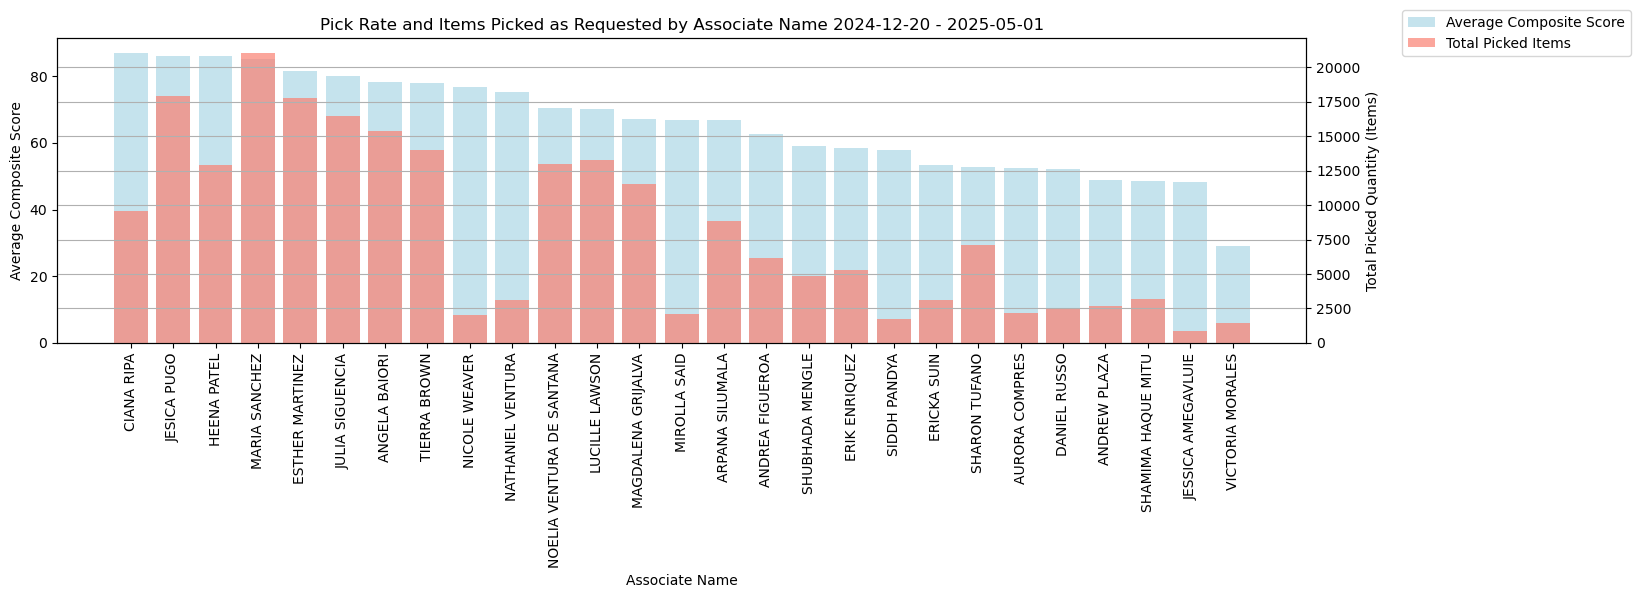

In [1342]:

# Plotting side-by-side bar plot for average Composite Score and total Picked As Req Qty
# Ensure columns like 'Picked As Req Qty' are numeric and handle any missing data
df['Picked As Req Qty'] = pd.to_numeric(df['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df['Composite Score'] = pd.to_numeric(df['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Picked As Req Qty'] = pd.to_numeric(df_selected_store['Picked As Req Qty'], errors='coerce')  # Convert to numeric, coerce errors to NaN
df_selected_store['Composite Score'] = pd.to_numeric(df_selected_store['Composite Score'], errors='coerce')  # Convert to numeric, coerce errors to NaN

# Drop rows where the 'Picked As Req Qty' is NaN since we can't sum them
#df_clean = df.dropna(subset=['Picked As Req Qty', 'Composite Score'])
df_clean = df_selected_store.dropna(subset=['Picked As Req Qty', 'Composite Score']).copy()
if selected_store == 3266:
    df_clean = df_clean[df_clean['Associate'].apply(lambda x: x in associate_list_3266)]

# Grouping by Associate ID and calculating the average Pick Rate and total Picked As Req Qty
avg_composite_score = df_clean.groupby('Associate')['Composite Score'].mean().sort_values(ascending=False)
total_picked_qty = df_clean.groupby('Associate')['Picked As Req Qty'].sum()

# Plotting side-by-side bar plot for average Pick Rate and total Picked As Req Qty
fig, ax1 = plt.subplots(figsize=(14, 6))

# Convert Associate ID index to string for plotting
avg_composite_score.index = avg_composite_score.index.astype(str)
total_picked_qty.index = total_picked_qty.index.astype(str)

# Bar plot for average Pick Rate (items per hour)
ax1.bar(avg_composite_score.index, avg_composite_score, color='lightblue', alpha=0.7, label='Average Composite Score')
ax1.set_xlabel('Associate Name')
ax1.set_ylabel('Average Composite Score')
ax1.set_title(f'Pick Rate and Items Picked as Requested by Associate Name {oldest_pick_date} - {last_pick_date}')

# Creating a second y-axis for total picked quantity (Items)
ax2 = ax1.twinx()
ax2.bar(total_picked_qty.index, total_picked_qty, color='salmon', alpha=0.7, label='Total Picked Items')
ax2.set_ylabel('Total Picked Quantity (Items)')

# Rotate x-tick labels for Associate ID on ax1
ax1.tick_params(axis='x', rotation=90)

# Adjust layout to prevent overlap
fig.tight_layout()

# Adding a legend for both bars
fig.legend(loc='upper left', bbox_to_anchor=(1, 1))

#Display grid over plot
plt.grid()
# Display the plot
plt.show()


<h2>Compare Associate Composite Score WTD to Average</h2>

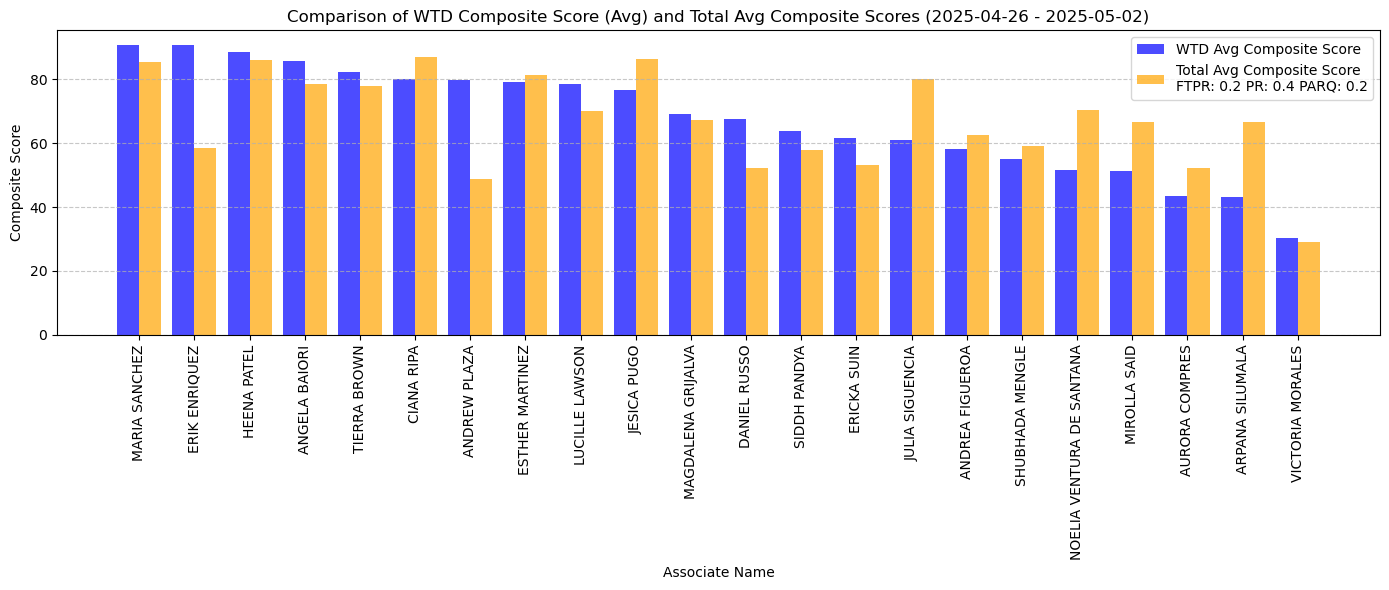

In [1343]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Define function to find the most recent full week
def get_last_full_week(df):
    """Returns the dataframe filtered for the most recent full week along with the week range."""
    last_full_week_start = df['Custom Week Start'].max()  # Start of the most recent full week
    last_full_week_end = df['Custom Week End'].max()  # End of the most recent full week

    # Filter for the most recent full week
    filtered_df = df[
        (df['Day of Pick Date'] >= last_full_week_start) &
        (df['Day of Pick Date'] <= last_full_week_end)
    ].copy()

    return filtered_df, last_full_week_start, last_full_week_end

# Step 2: Filter data for the most recent full week and get the week range
most_recent_week_data, last_full_week_start, last_full_week_end = get_last_full_week(df_clean)

# Fill NaN values in Composite Score and filter out associates with a score of 0
most_recent_week_data.loc[:, 'Composite Score'] = most_recent_week_data['Composite Score'].fillna(0)
most_recent_week_data = most_recent_week_data[most_recent_week_data['Composite Score'] > 0]

# Step 3: Calculate last week's and total average Composite Score (only for associates present last week)
last_week_avg_composite_score = (
    most_recent_week_data.groupby(['Associate'])['Composite Score']
    .mean()
)

# Filter df_clean to include only associates who had a score last week
df_clean_filtered = df_clean[df_clean['Associate'].isin(last_week_avg_composite_score.index)]

# Compute total average Composite Score (only for associates in last_week_avg_composite_score)
total_avg_composite_score = (
    df_clean_filtered.groupby(['Associate'])['Composite Score']
    .mean()
)

# Step 4: Merge both metrics into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': last_week_avg_composite_score,
    'Total Avg Composite Score': total_avg_composite_score
})
comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 5: Plot comparison of last week's and total average Composite Scores
fig, ax = plt.subplots(figsize=(14, 6))

# Create side-by-side bar plot
width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x],
    comparison_df['Last Week Avg Composite Score'],
    width=width,
    label='WTD Avg Composite Score',
    color='blue',
    alpha=0.7
)
ax.bar(
    [pos + width / 2 for pos in x],
    comparison_df['Total Avg Composite Score'],
    width=width,
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}',
    color='orange',
    alpha=0.7
)

# Add labels and title
ax.set_xlabel('Associate Name')
ax.set_ylabel('Composite Score')
ax.set_title(f'Comparison of WTD Composite Score (Avg) and Total Avg Composite Scores ({last_full_week_start.date()} - {last_full_week_end.date()})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<h2></h2>

<h2>Composite Score Comparison LW (full week) to Average</h2>

associate_ids_last_week: ['ANDREW PLAZA' 'CIANA RIPA' 'DANILO PANALES' 'ERICKA SUIN'
 'ESTHER MARTINEZ' 'GABRIEL NYDICK' 'MAGDALENA GRIJALVA' 'MARIA SANCHEZ'
 'NATHANIEL VENTURA' 'NOELIA VENTURA DE SANTANA' 'SHAMIMA HAQUE MITU'
 'VICTORIA MORALES' 'TIERRA BROWN' 'JESICA PUGO' 'ERIK ENRIQUEZ'
 'CHRISTINA CUCITRO' 'AURORA COMPRES' 'ARPANA SILUMALA' 'ANGELA BAIORI'
 'SHUBHADA MENGLE' 'DANIELLE CASIANO' 'JULIA SIGUENCIA' 'LUCILLE LAWSON'
 'MIROLLA SAID' 'DANIEL RUSSO' 'SIDDH PANDYA' 'HEENA PATEL'
 'ANDREA FIGUEROA']


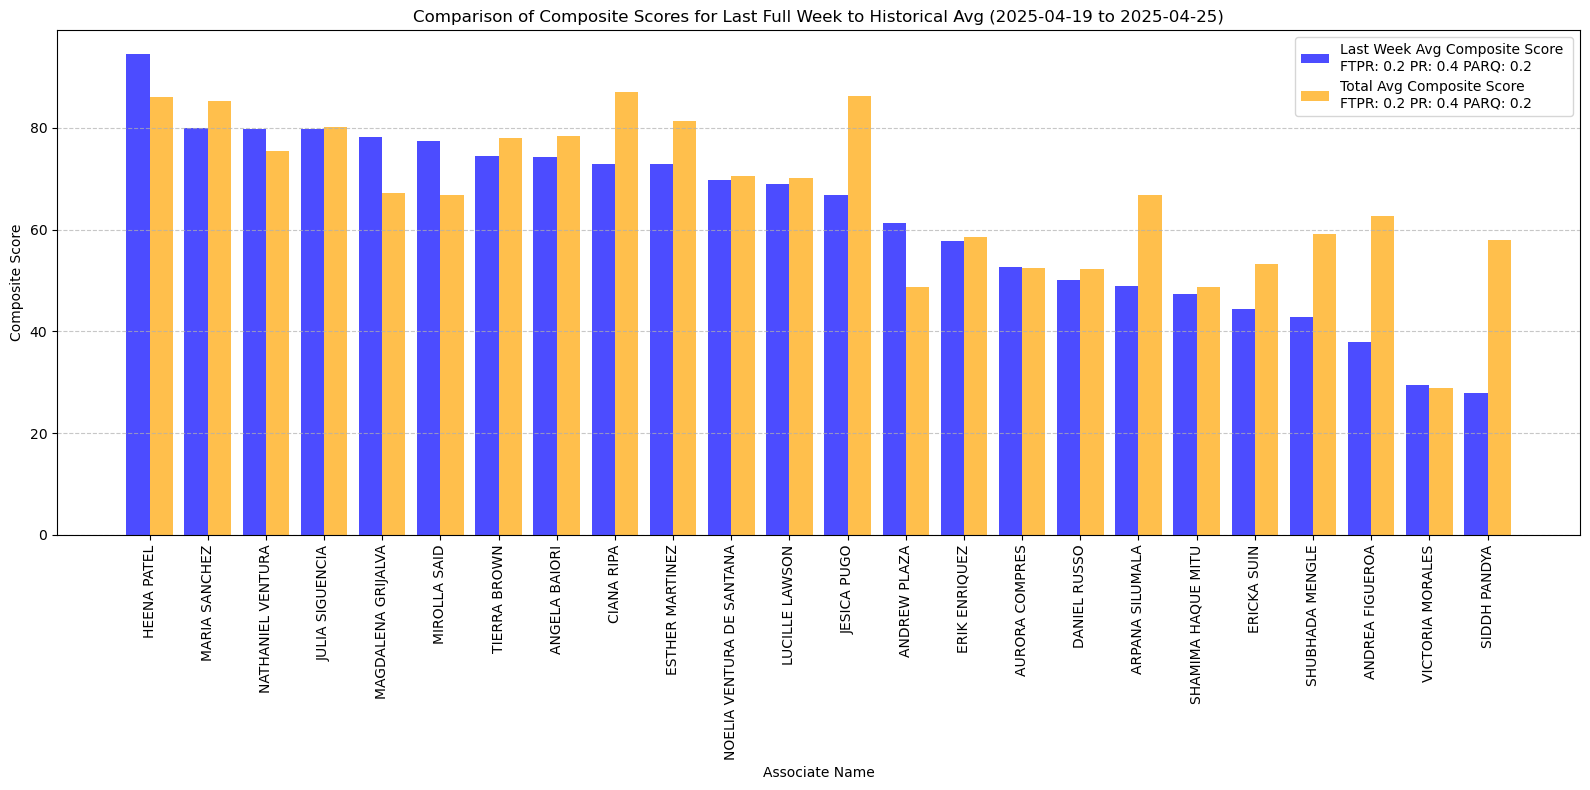

In [1344]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 2: Filter for full weeks
full_weeks = df_selected_store.groupby('Week').filter(is_full_week)

# Step 3: Identify the last full week
last_full_week = full_weeks['Week'].max()  # Get the most recent full week

# Step 4: Extract data for the last full week
last_week_data = full_weeks[full_weeks['Week'] == last_full_week].copy()

# Step 5: Filter associates with Composite Score > 0
last_week_data = last_week_data[last_week_data['Composite Score'] > 0]

# Fill NaN values in 'Composite Score' (if any)
last_week_data['Composite Score'] = last_week_data['Composite Score'].fillna(0)

# Step 6: Group by Associate ID and calculate average Composite Score for the last week
avg_composite_score_last_week = (
    last_week_data.groupby('Associate')['Composite Score']
    .mean()
    .sort_values(ascending=False)
)

# Step 7: Filter total average Composite Score to include only Names in last_week_data
associate_ids_last_week = last_week_data['Associate'].unique()  # Get unique Associate Names from last_week_data 
total_avg_composite_score = (
    df_selected_store[df_selected_store['Composite Score'] > 0]
    .groupby('Associate')['Composite Score']
    .mean()
    .loc[associate_ids_last_week]  # Filter to include only Associate Names from last_week_data
)
print(f'associate_ids_last_week: {associate_ids_last_week}')
if selected_store == 3266:
    total_avg_composite_score = total_avg_composite_score[total_avg_composite_score.index.isin(associate_list_3266)]

# Step 8: Merge both scores into a single DataFrame for proper alignment
comparison_df = pd.DataFrame({
    'Last Week Avg Composite Score': avg_composite_score_last_week,
    'Total Avg Composite Score': total_avg_composite_score
}).fillna(0)
if selected_store == 3266:
    comparison_df = comparison_df[comparison_df.index.isin(associate_list_3266)]

comparison_df = comparison_df.sort_values(by="Last Week Avg Composite Score", ascending=False)

# Step 9: Visualization - Side-by-side bar chart
fig, ax = plt.subplots(figsize=(16, 8))

width = 0.4  # Bar width
x = range(len(comparison_df.index))  # X-axis positions

ax.bar(
    [pos - width / 2 for pos in x], 
    comparison_df['Last Week Avg Composite Score'], 
    width=width, 
    label=f'Last Week Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='blue', 
    alpha=0.7
)

ax.bar(
    [pos + width / 2 for pos in x], 
    comparison_df['Total Avg Composite Score'], 
    width=width, 
    label=f'Total Avg Composite Score \nFTPR: {ftpr_modifier} PR: {pickrate_modifier} PARQ: {picked_as_req_modifier}', 
    color='orange', 
    alpha=0.7
)

# Set labels and title
ax.set_xlabel('Associate Name')
ax.set_ylabel(f'Composite Score')
ax.set_title(f'Comparison of Composite Scores for Last Full Week to Historical Avg ({last_full_week})')

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=90)

# Add a legend
ax.legend()

# Display grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


<h2>Comparison of Composite Score MTD compared to Last Month</h2>

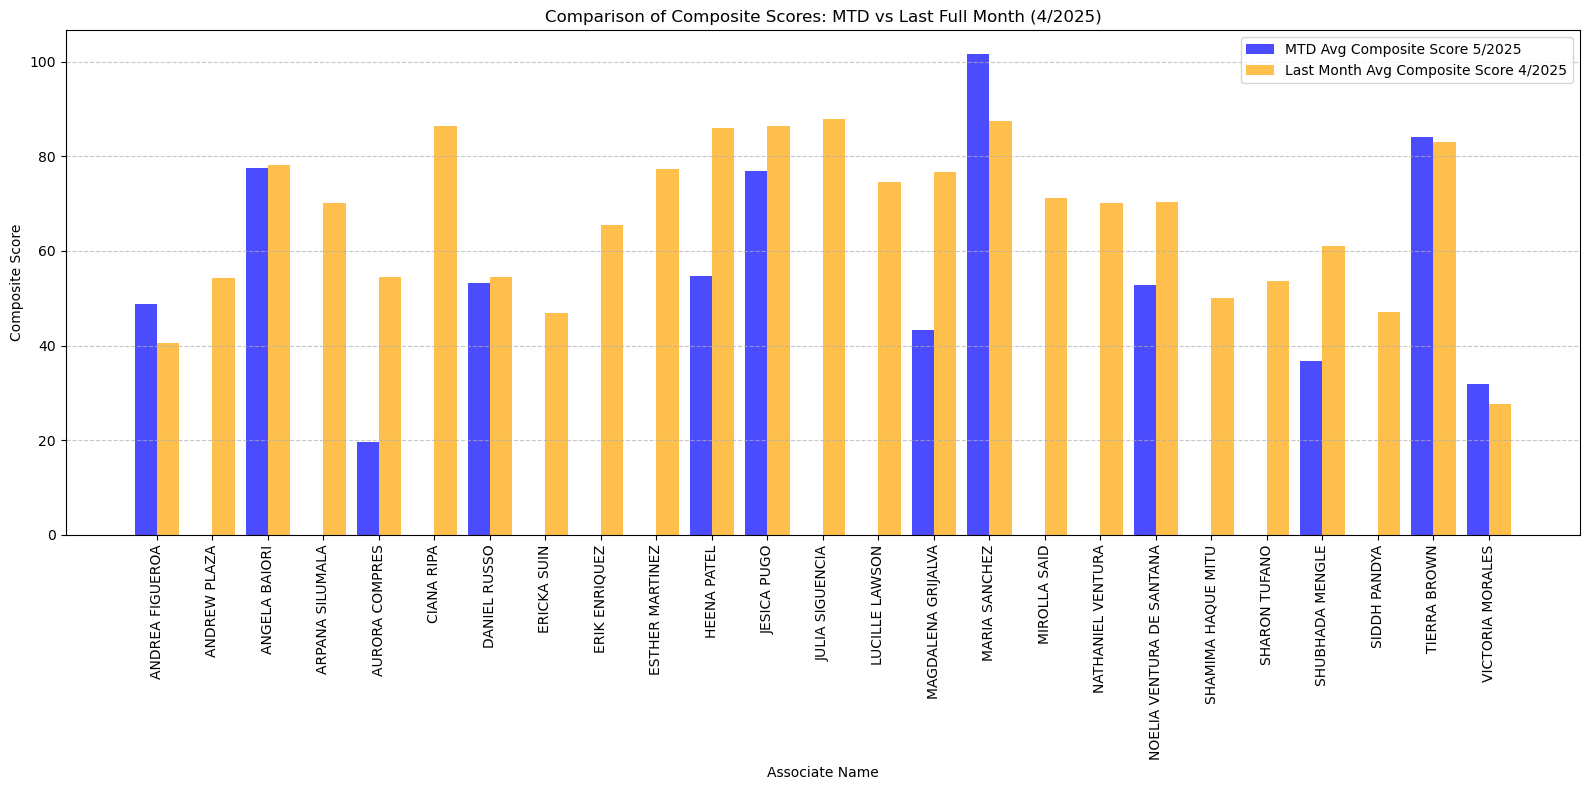

In [1345]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Get the current date and define month-to-date (MTD) and last full month
#today = pd.to_datetime("2025-01-31")
today = pd.to_datetime("today")
current_month = today.month
current_year = today.year

# Define last full month
if current_month == 1:
    last_month = 12
    last_month_year = current_year - 1
else:
    last_month = current_month - 1
    last_month_year = current_year

# Step 2: Filter data for MTD and last full month
df_selected_store['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])  # Ensure Date column is in datetime format

# Month-to-Date (MTD) data
mtd_data = df_selected_store[
    (df_selected_store['Day of Pick Date'].dt.year == current_year) & 
    (df_selected_store['Day of Pick Date'].dt.month == current_month) & 
    (df_selected_store['Composite Score'] > 0)
]

# Last full month data
last_month_data = df_selected_store[
    (df_selected_store['Day of Pick Date'].dt.year == last_month_year) & 
    (df_selected_store['Day of Pick Date'].dt.month == last_month) & 
    (df_selected_store['Composite Score'] > 0)
]

# Step 3: Compute average composite scores for each Associate
avg_composite_score_mtd = mtd_data.groupby('Associate')['Composite Score'].mean()
if selected_store == 3266:
    avg_composite_score_mtd = avg_composite_score_mtd[avg_composite_score_mtd.index.isin(associate_list_3266)]
avg_composite_score_last_month = last_month_data.groupby('Associate')['Composite Score'].mean()
if selected_store == 3266:
    avg_composite_score_last_month = avg_composite_score_last_month[avg_composite_score_last_month.index.isin(associate_list_3266)]
is_empty = mtd_data['Composite Score'].count() == 0
# Step 4: Merge both scores into a single DataFrame for alignment
comparison_df = pd.DataFrame({
    'MTD Avg Composite Score': avg_composite_score_mtd,
    'Last Month Avg Composite Score': avg_composite_score_last_month
}).fillna(0)

if is_empty == True:
    print(f'No data for {current_month}/{current_year}')
else:
    # Step 5: Visualization - Side-by-side bar chart
    fig, ax = plt.subplots(figsize=(16, 8))
    
    width = 0.4  # Bar width
    x = range(len(comparison_df.index))  # X-axis positions
    
    ax.bar(
        [pos - width / 2 for pos in x], 
        comparison_df['MTD Avg Composite Score'], 
        width=width, 
        label=(f'MTD Avg Composite Score {current_month}/{current_year}'), 
        color='blue', 
        alpha=0.7
    )
    
    ax.bar(
        [pos + width / 2 for pos in x], 
        comparison_df['Last Month Avg Composite Score'], 
        width=width, 
        label=(f'Last Month Avg Composite Score {last_month}/{last_month_year}'), 
        color='orange', 
        alpha=0.7
    )
    
    # Set labels and title
    ax.set_xlabel('Associate Name')
    ax.set_ylabel('Composite Score')
    ax.set_title(f'Comparison of Composite Scores: MTD vs Last Full Month ({last_month}/{last_month_year})')
    
    # Set x-ticks and labels
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df.index, rotation=90)
    
    # Add a legend
    ax.legend()
    
    # Display grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


<h2>Total Performance By Selected Month by Associate</h2>

In [1346]:
'''# Extract Year, Month
df['Year'] = df['Day of Pick Date'].dt.year
df['Month'] = df['Day of Pick Date'].dt.month

# Compute the first day of the month for each row
df['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))

# Compute the week number of the first day of the month
df['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week

# Compute the actual week of the month
df['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1

# Define the metrics and their aggregation type
metrics_agg = {
    'FTPR': 'mean',  # Average
    'Pick Rate': 'mean',  
    'Pick Hours': 'mean',  
    'Qty Req to Pick': 'sum',  # Sum
    'Picked As Req Qty': 'sum',
    'Substitution Qty': 'sum',
    'Nil Pick Qty': 'sum',
    'Exception Qty Req to Pick': 'sum'
}

# Group by Associate ID, Year, Month, and Week of Month, applying aggregation functions
weekly_aggregated = df.groupby(['Associate ID', 'Year', 'Month', 'Week of Month'], as_index=False).agg(metrics_agg)

# Filter to ensure no previous month’s data spills over
weekly_aggregated = weekly_aggregated[weekly_aggregated['Week of Month'] > 0]

# Sort for proper plotting
weekly_aggregated = weekly_aggregated.sort_values(by=['Associate ID', 'Year', 'Month', 'Week of Month'])

# Debugging Step: Check if the grouping is correct
print(weekly_aggregated.head(10))  # Print first 10 rows to verify correctness

# Generate individual plots for each Associate
for associate in weekly_aggregated['Associate ID'].unique():
    associate_data = weekly_aggregated[weekly_aggregated['Associate ID'] == associate]

    plt.figure(figsize=(12, 6))

    # Plot each metric as a separate line
    for metric in metrics_agg.keys():
        plt.plot(associate_data['Week of Month'], associate_data[metric], marker='o', linestyle='-', label=metric)

    plt.xlabel('Week of Month')
    plt.ylabel('Value')
    plt.title(f'Weekly Metrics for Associate {associate}')
    plt.legend(loc='best', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(associate_data['Week of Month'].unique())  # Ensure proper x-axis labels
    plt.tight_layout()
    
    plt.show()
    '''


"# Extract Year, Month\ndf['Year'] = df['Day of Pick Date'].dt.year\ndf['Month'] = df['Day of Pick Date'].dt.month\n\n# Compute the first day of the month for each row\ndf['First Day of Month'] = df['Day of Pick Date'].apply(lambda x: x.replace(day=1))\n\n# Compute the week number of the first day of the month\ndf['First Week of Month'] = df['First Day of Month'].dt.isocalendar().week\n\n# Compute the actual week of the month\ndf['Week of Month'] = df['Day of Pick Date'].dt.isocalendar().week - df['First Week of Month'] + 1\n\n# Define the metrics and their aggregation type\nmetrics_agg = {\n    'FTPR': 'mean',  # Average\n    'Pick Rate': 'mean',  \n    'Pick Hours': 'mean',  \n    'Qty Req to Pick': 'sum',  # Sum\n    'Picked As Req Qty': 'sum',\n    'Substitution Qty': 'sum',\n    'Nil Pick Qty': 'sum',\n    'Exception Qty Req to Pick': 'sum'\n}\n\n# Group by Associate ID, Year, Month, and Week of Month, applying aggregation functions\nweekly_aggregated = df.groupby(['Associate ID',

In [1347]:
run_test_models = False

<h1>disregard the models below for now as of 4/18/2025</h1>

<h2>Using PyTorch (mps) to make a model that predicts FTPR, Pick Rate, Picked As Req Qty</h2>

In [1348]:
if run_test_models:
    # Load and preprocess data
    # Assuming 'df' is the provided DataFrame
    #df = df.copy()
    features = ['Pick Hours', 'Qty Req to Pick', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 
                'Exception Picked As Req Qty', 'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate', 'Picked As Req Qty']

    X = df[features].values
    y = df[targets].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the neural network
    class MultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(MultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 64)
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
            return x

    # Initialize the model, loss function, and optimizer
    input_dim = len(features)
    output_dim = len(targets)
    model = MultiOutputRegression(input_dim, output_dim)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_train_tensor)
        loss = criterion(predictions, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor)
        y_pred_test = model(X_test_tensor)

        train_mse = mean_squared_error(y_train, y_pred_train.numpy())
        test_mse = mean_squared_error(y_test, y_pred_test.numpy())

        train_r2 = r2_score(y_train, y_pred_train.numpy())
        test_r2 = r2_score(y_test, y_pred_test.numpy())

    print("Training Metrics:")
    print(f"MSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print("Testing Metrics:")
    print(f"MSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")


In [1349]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    start_time = time.time()
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)
            self.fc2 = nn.Linear(128, 256)
            self.fc3 = nn.Linear(256, 128)
            self.fc4 = nn.Linear(128, output_dim)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(0.2)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.dropout(self.relu(self.fc2(x)))
            x = self.relu(self.fc3(x))
            x = self.fc4(x)
            return x

    # Assume df is your dataframe and contains the necessary columns
    # Features and targets
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Training the model
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Evaluating the model
    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).numpy()
        y_pred_test = model(X_test_tensor).numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()
    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f'Total time: {end_time - start_time}')


In [1350]:
if run_test_models:
    # Check device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    device = 'cpu'
    print(f"Using device: {device}")
    #device = 'cpu'
    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


In [1351]:
if run_test_models:
    # Check device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define the model architecture with dropout for regularization
    class EnhancedMultiOutputRegression(nn.Module):
        def __init__(self, input_dim, output_dim):
            super(EnhancedMultiOutputRegression, self).__init__()
            self.fc1 = nn.Linear(input_dim, 128)        # First hidden layer
            self.fc2 = nn.Linear(128, 256)              # Second hidden layer
            self.fc3 = nn.Linear(256, 128)              # Third hidden layer
            self.fc4 = nn.Linear(128, 64)               # Fourth hidden layer (new)
            self.fc5 = nn.Linear(64, output_dim)        # Output layer
            self.relu = nn.ReLU()                       # ReLU activation
            self.dropout = nn.Dropout(0.3)              # Dropout for regularization

        def forward(self, x):
            x = self.relu(self.fc1(x))                  # Pass through first layer
            x = self.dropout(self.relu(self.fc2(x)))    # Pass through second layer
            x = self.relu(self.fc3(x))                  # Pass through third layer
            x = self.relu(self.fc4(x))                  # Pass through fourth layer (new)
            x = self.fc5(x)                             # Output layer
            return x

    # Features and target columns
    features = ['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 
                'Nil Pick Qty', 'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 
                'Exception Substitution Qty', 'Exception Nil Pick Qty']
    targets = ['FTPR', 'Pick Rate']

    # Prepare data
    X = df[features].values
    y = df[targets].values

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()

    X_train = feature_scaler.fit_transform(X_train)
    X_test = feature_scaler.transform(X_test)

    y_train = target_scaler.fit_transform(y_train)
    y_test = target_scaler.transform(y_test)

    # Convert data to PyTorch tensors and move to the specified device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Create DataLoader for mini-batch training
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Model, Loss Function, Optimizer, and Scheduler
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]

    model = EnhancedMultiOutputRegression(input_dim, output_dim).to(device)  # Move model to device
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)  # Learning rate scheduler

    # Training the model with validation loss and early stopping
    num_epochs = 100
    patience, early_stop_counter = 10, 0  # Early stopping patience
    best_val_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        scheduler.step()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                predictions = model(batch_X)
                loss = criterion(predictions, batch_y)
                val_loss += loss.item()
        val_loss /= len(test_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')  # Save the best model
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model for evaluation
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))
    model.eval()

    # Evaluate on training and testing sets
    with torch.no_grad():
        y_pred_train = model(X_train_tensor).cpu().numpy()
        y_pred_test = model(X_test_tensor).cpu().numpy()

    # Reverse scaling to compute metrics
    y_pred_train_rescaled = target_scaler.inverse_transform(y_pred_train)
    y_pred_test_rescaled = target_scaler.inverse_transform(y_pred_test)

    y_train_rescaled = target_scaler.inverse_transform(y_train)
    y_test_rescaled = target_scaler.inverse_transform(y_test)

    train_mse = mean_squared_error(y_train_rescaled, y_pred_train_rescaled)
    train_r2 = r2_score(y_train_rescaled, y_pred_train_rescaled)

    test_mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
    test_r2 = r2_score(y_test_rescaled, y_pred_test_rescaled)

    end_time = time.time()

    # Print metrics
    print(f"Training Metrics:\nMSE: {train_mse:.4f}, R2 Score: {train_r2:.4f}")
    print(f"Testing Metrics:\nMSE: {test_mse:.4f}, R2 Score: {test_r2:.4f}")
    print(f"Total time with {device}: {end_time - start_time:.2f} seconds")


<h2>Attempt to make PyTorch model better</h2>

In [1352]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation (include interaction features or domain-specific knowledge)
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")


In [1353]:
if run_test_models:
    # Feature importance using Random Forest for FTPR
    from sklearn.ensemble import RandomForestRegressor

    # Train a Random Forest model on FTPR to find important features
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train_scaled, y_train_ftpr)
    importances = rf.feature_importances_

    # Display feature importance
    feature_importance = sorted(zip(importances, X.columns), reverse=True)
    print("Feature Importance for FTPR:")
    for importance, feature in feature_importance:
        print(f"{feature}: {importance:.4f}")

    # Select top features based on importance
    top_features = [feature for importance, feature in feature_importance if importance > 0.05]
    X_train_ftpr = X_train_scaled[:, [X.columns.get_loc(f) for f in top_features]]
    X_test_ftpr = X_test_scaled[:, [X.columns.get_loc(f) for f in top_features]]

    # Use only these features in the FTPR model
    ftpr_model = EnhancedModel(len(top_features))


In [1354]:
if run_test_models:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import time

    # Define Models with More Complexity
    class EnhancedModel(nn.Module):
        def __init__(self, input_size):
            super(EnhancedModel, self).__init__()
            self.model = nn.Sequential(
                nn.Linear(input_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.model(x)

    # Data Preparation based on Feature Importance
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    # Selecting features based on importance
    X = df[['Picked As Req Qty', 'Pick Hours per Qty Req', 'Nil Pick Qty', 'Qty Req to Pick', 
            'Substitution Qty', 'Pick Hours', 'Total Exceptions']]  # Focus on important features

    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Training Function with Learning Rate Scheduling
    def train_model_with_scheduler(model, optimizer, scheduler, criterion, X_train, y_train, X_test, y_test, epochs=500):
        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            outputs = model(torch.tensor(X_train, dtype=torch.float32))
            loss = criterion(outputs.flatten(), torch.tensor(y_train.values, dtype=torch.float32))
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Adjust learning rate based on validation loss
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_test, dtype=torch.float32)).flatten().numpy()
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        return mse, r2, predictions

    # Train and Evaluate Models
    start_time = time.time()
    input_size = X_train_scaled.shape[1]

    # FTPR Model
    ftpr_model = EnhancedModel(input_size)
    optimizer_ftpr = optim.Adam(ftpr_model.parameters(), lr=0.01)
    scheduler_ftpr = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ftpr, patience=10, factor=0.5, verbose=True)
    criterion = nn.MSELoss()
    ftpr_mse, ftpr_r2, ftpr_preds = train_model_with_scheduler(ftpr_model, optimizer_ftpr, scheduler_ftpr, criterion, X_train_scaled, y_train_ftpr, X_test_scaled, y_test_ftpr)

    # Pick Rate Model
    pick_rate_model = EnhancedModel(input_size)
    optimizer_pick_rate = optim.Adam(pick_rate_model.parameters(), lr=0.01)
    scheduler_pick_rate = optim.lr_scheduler.ReduceLROnPlateau(optimizer_pick_rate, patience=10, factor=0.5, verbose=True)
    pick_rate_mse, pick_rate_r2, pick_rate_preds = train_model_with_scheduler(pick_rate_model, optimizer_pick_rate, scheduler_pick_rate, criterion, X_train_scaled, y_train_pick_rate, X_test_scaled, y_test_pick_rate)

    # Picked As Req Qty Model
    picked_as_req_qty_model = EnhancedModel(input_size)
    optimizer_picked_as_req_qty = optim.Adam(picked_as_req_qty_model.parameters(), lr=0.01)
    scheduler_picked_as_req_qty = optim.lr_scheduler.ReduceLROnPlateau(optimizer_picked_as_req_qty, patience=10, factor=0.5, verbose=True)
    picked_as_req_qty_mse, picked_as_req_qty_r2, picked_as_req_qty_preds = train_model_with_scheduler(
        picked_as_req_qty_model, optimizer_picked_as_req_qty, scheduler_picked_as_req_qty, criterion, X_train_scaled, y_train_picked_as_req_qty, X_test_scaled, y_test_picked_as_req_qty
    )

    end_time = time.time()

    # Results
    print(f"FTPR Prediction Metrics:\nMSE: {ftpr_mse:.4f}, R2 Score: {ftpr_r2:.4f}")
    print(f"Pick Rate Prediction Metrics:\nMSE: {pick_rate_mse:.4f}, R2 Score: {pick_rate_r2:.4f}")
    print(f"Picked As Req Qty Prediction Metrics:\nMSE: {picked_as_req_qty_mse:.4f}, R2 Score: {picked_as_req_qty_r2:.4f}")
    print(f"Total time: {end_time - start_time:.2f} seconds")

    # Feature Importance based on your provided data
    # These are the feature importance scores for FTPR as an example
    feature_importance = {
        'Picked As Req Qty': 0.2553,
        'Pick Hours per Qty Req': 0.1751,
        'Nil Pick Qty': 0.1545,
        'Qty Req to Pick': 0.1504,
        'Substitution Qty': 0.1096,
        'Pick Hours': 0.0977,
        'Exception Nil Pick Qty': 0.0210,
        'Total Exceptions': 0.0146,
        'Exception Substitution Qty': 0.0128,
        'Exception Qty Req to Pick': 0.0079,
        'Exception Picked As Req Qty': 0.0010
    }

    print("\nFeature Importance for FTPR:")
    for feature, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature}: {importance:.4f}")


In [1355]:
if run_test_models:
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import matplotlib.pyplot as plt
    from sklearn.ensemble import RandomForestRegressor

    # Data Preprocessing
    X = df[['Day of Pick Date', 'Qty Req to Pick', 'Pick Hours']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Convert date column to datetime format and extract day, month, year features
    df['Day of Pick Date'] = pd.to_datetime(df['Day of Pick Date'])
    df['day_of_month'] = df['Day of Pick Date'].dt.day
    df['month'] = df['Day of Pick Date'].dt.month

    X = df[['Qty Req to Pick', 'Pick Hours', 'day_of_month', 'month']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']

    # Split data into training and testing sets
    X_train, X_test, y_ftpr_train, y_ftpr_test = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_pick_rate_train, y_pick_rate_test = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train models
    model_ftpr = RandomForestRegressor(n_estimators=100)
    model_ftpr.fit(X_train_scaled, y_ftpr_train)

    y_ftpr_pred = model_ftpr.predict(X_test_scaled)
    print("FTPR Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_ftpr_test, y_ftpr_pred)}")
    print(f"R2 Score: {r2_score(y_ftpr_test, y_ftpr_pred)}")

    model_pick_rate = RandomForestRegressor(n_estimators=100)
    model_pick_rate.fit(X_train_scaled, y_pick_rate_train)

    y_pick_rate_pred = model_pick_rate.predict(X_test_scaled)
    print("Pick Rate Model Evaluation:")
    print(f"MSE: {mean_squared_error(y_pick_rate_test, y_pick_rate_pred)}")
    print(f"R2 Score: {r2_score(y_pick_rate_test, y_pick_rate_pred)}")

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_ftpr_test, y_ftpr_pred)
    plt.xlabel("Actual FTPR")
    plt.ylabel("Predicted FTPR")
    plt.title("FTPR Model Predictions")

    plt.subplot(1, 2, 2)
    plt.scatter(y_pick_rate_test, y_pick_rate_pred)
    plt.xlabel("Actual Pick Rate")
    plt.ylabel("Predicted Pick Rate")
    plt.title("Pick Rate Model Predictions")

    plt.tight_layout()
    plt.show()


<h2>Attempt to try different models to improve accuracy</h2>

In [1356]:
if run_test_models:
    from sklearn.model_selection import GridSearchCV

    # Define hyperparameter grids for FTPR and Pick Rate models
    ftpr_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    pick_rate_param_grid = {
        'n_estimators': [10, 50, 100, 200, 300],
        'max_depth': [None, 5, 10, 15, 20]
    }

    # Perform grid search for FTPR model
    ftpr_gs = GridSearchCV(RandomForestRegressor(), ftpr_param_grid, cv=5, n_jobs=-1)
    ftpr_gs.fit(X_train_scaled, y_ftpr_train)

    print("FTPR Model Best Parameters:", ftpr_gs.best_params_)
    print("FTPR Model Best Score:", ftpr_gs.best_score_)

    # Perform grid search for Pick Rate model
    pick_rate_gs = GridSearchCV(RandomForestRegressor(), pick_rate_param_grid, cv=5, n_jobs=-1)
    pick_rate_gs.fit(X_train_scaled, y_pick_rate_train)

    print("Pick Rate Model Best Parameters:", pick_rate_gs.best_params_)
    print("Pick Rate Model Best Score:", pick_rate_gs.best_score_)

    # Train models with best parameters and evaluate
    ftpr_best_model = ftpr_gs.best_estimator_
    pick_rate_best_model = pick_rate_gs.best_estimator_

    y_ftpr_pred = ftpr_best_model.predict(X_test_scaled)
    y_pick_rate_pred = pick_rate_best_model.predict(X_test_scaled)

    print("FTPR Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_ftpr_test, y_ftpr_pred))
    print("R2 Score:", r2_score(y_ftpr_test, y_ftpr_pred))

    print("Pick Rate Model Evaluation (Best Parameters):")
    print("MSE:", mean_squared_error(y_pick_rate_test, y_pick_rate_pred))
    print("R2 Score:", r2_score(y_pick_rate_test, y_pick_rate_pred))

compare pick times to pick rate

In [1357]:
df.head()

,Associate ID,Associate Name,Store #,Day of Pick Date,FTPR,FTP Expected,FTP Actual,Pick Rate,Pick Hours,Picked As Req Qty,...,Week,Handled_Exceptions,Composite Score,Exception Rate,IsWeekend,Log Pick Rate,Log FTPR,Predicted FTPR,Predicted Pick Rate,Predicted Picked As Req Qty
151,c0c116s,CHRISTINA CUCITRO,3266,2024-12-20,100.00,4,4,46.0,0.09,4,...,2024-12-14 to 2024-12-20,1,39.245,0.000000,0,3.850148,4.615121,100.092781,46.025711,4.036479
422,j0p0vpl,JESICA PUGO,3266,2024-12-20,94.17,244,236,66.0,3.63,236,...,2024-12-14 to 2024-12-20,1,94.249,0.000000,0,4.204693,4.555665,94.268822,66.012138,235.503479
266,e0e04sh,ERIK ENRIQUEZ,3266,2024-12-20,100.00,5,5,16.0,0.32,5,...,2024-12-14 to 2024-12-20,1,27.560,0.000000,0,2.833213,4.615121,99.865494,15.994343,5.041198
463,jrsigue,JULIA SIGUENCIA,3266,2024-12-20,92.02,347,336,68.0,4.99,336,...,2024-12-14 to 2024-12-20,1,115.299,0.005764,0,4.234107,4.532815,91.960434,68.004631,335.991089
694,s0m0uve,SHAMIMA HAQUE MITU,3266,2024-12-20,100.00,13,12,21.0,0.59,12,...,2024-12-14 to 2024-12-20,1,31.095,0.000000,0,3.091042,4.615121,99.747917,20.981625,12.027572


In [1358]:
if run_test_models:
    import xgboost as xgb
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np

    # Data Preparation
    df['Pick Hours per Qty Req'] = df['Pick Hours'] / (df['Qty Req to Pick'] + 1e-5)
    df['Total Exceptions'] = (
        df['Exception Qty Req to Pick'] + df['Exception Picked As Req Qty'] +
        df['Exception Substitution Qty'] + df['Exception Nil Pick Qty']
    )

    X = df[['Pick Hours', 'Qty Req to Pick', 'Picked As Req Qty', 'Substitution Qty', 'Nil Pick Qty',
            'Exception Qty Req to Pick', 'Exception Picked As Req Qty', 'Exception Substitution Qty',
            'Exception Nil Pick Qty', 'Pick Hours per Qty Req', 'Total Exceptions']]
    y_ftpr = df['FTPR']
    y_pick_rate = df['Pick Rate']
    y_picked_as_req_qty = df['Picked As Req Qty']

    # Train-Test Split
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X, y_pick_rate, test_size=0.2, random_state=42)
    _, _, y_train_picked_as_req_qty, y_test_picked_as_req_qty = train_test_split(X, y_picked_as_req_qty, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model Training for FTPR
    ftpr_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    ftpr_model.fit(X_train_scaled, y_train_ftpr)

    # Model Training for Pick Rate
    pick_rate_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    pick_rate_model.fit(X_train_scaled, y_train_pick_rate)

    # Model Training for Picked As Req Qty
    picked_as_req_qty_model = xgb.XGBRegressor(tree_method="hist", n_estimators=1000, learning_rate=0.05, max_depth=6)
    picked_as_req_qty_model.fit(X_train_scaled, y_train_picked_as_req_qty)

    # Predictions
    ftpr_preds = ftpr_model.predict(X_test_scaled)
    pick_rate_preds = pick_rate_model.predict(X_test_scaled)
    picked_as_req_qty_preds = picked_as_req_qty_model.predict(X_test_scaled)

    # Evaluation
    print("FTPR Metrics")
    print(f"MSE: {mean_squared_error(y_test_ftpr, ftpr_preds):.4f}")
    print(f"R2: {r2_score(y_test_ftpr, ftpr_preds):.4f}")

    print("\nPick Rate Metrics")
    print(f"MSE: {mean_squared_error(y_test_pick_rate, pick_rate_preds):.4f}")
    print(f"R2: {r2_score(y_test_pick_rate, pick_rate_preds):.4f}")

    print("\nPicked As Req Qty Metrics")
    print(f"MSE: {mean_squared_error(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")
    print(f"R2: {r2_score(y_test_picked_as_req_qty, picked_as_req_qty_preds):.4f}")


In [1359]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score

    # ===========================================
    # Load and Preprocess Data
    # ===========================================

    # Example DataFrame (replace with actual data loading)
    # df = pd.read_csv('your_dataset.csv')

    # Convert 'Day of Pick Date' and other datetime columns to numeric features (e.g., day of the week)
    if "Day of Pick Date" in df.columns:
        df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
        df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
        df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month

    # Drop irrelevant columns
    X = df.drop(columns=[
        "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
        "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
        "Composite Score", "Associate ID"
    ])

    # Target variables
    y_ftpr = df["FTPR"]
    y_pick_rate = df["Pick Rate"]

    # Convert categorical features to numeric using one-hot encoding
    X_numeric = pd.get_dummies(X, drop_first=True)

    # Ensure all columns are numeric
    X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)

    # Split data into training and testing sets
    X_train, X_test, y_train_ftpr, y_test_ftpr = train_test_split(X_numeric, y_ftpr, test_size=0.2, random_state=42)
    _, _, y_train_pick_rate, y_test_pick_rate = train_test_split(X_numeric, y_pick_rate, test_size=0.2, random_state=42)

    # Scale numeric features for better performance
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ===========================================
    # Train and Evaluate Models
    # ===========================================

    # Define a function to train and evaluate models
    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        return model

    # Train Random Forest Regressor for FTPR
    ftpr_model = RandomForestRegressor(n_estimators=500, random_state=42)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    # Train Random Forest Regressor for Pick Rate
    pick_rate_model = RandomForestRegressor(n_estimators=500, random_state=42)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

    # ===========================================
    # Notes
    # ===========================================
    # - Handled datetime columns by extracting numeric features.
    # - Dropped irrelevant columns to avoid data leakage.
    # - Converted categorical features to numeric using `pd.get_dummies`.
    # - Ensured all columns are numeric with `pd.to_numeric` and replaced NaN values with 0.
    # - Scaled features using `StandardScaler` for improved model performance.


In [1360]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model

    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

In [1361]:
if run_test_models:
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Define constants
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    N_ESTIMATORS = 500

    def load_data(file_path):
        try:
            df = pd.read_csv(file_path)
            return df
        except FileNotFoundError:
            print("File not found.")
            return None

    def preprocess_data(df):
        if "Day of Pick Date" in df.columns:
            df["Day_of_Week"] = pd.to_datetime(df["Day of Pick Date"]).dt.dayofweek
            df["Day_of_Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.day
            df["Month"] = pd.to_datetime(df["Day of Pick Date"]).dt.month
        
        X = df.drop(columns=[
            "FTPR", "Pick Rate", "Predicted FTPR", "Predicted Pick Rate",
            "Predicted Picked As Req Qty", "Day of Pick Date", "Week",
            "Composite Score", "Associate ID"
        ])
        
        y_ftpr = df["FTPR"]
        y_pick_rate = df["Pick Rate"]
        
        X_numeric = pd.get_dummies(X, drop_first=True)
        X_numeric = X_numeric.apply(pd.to_numeric, errors="coerce").fillna(0)
        
        return X_numeric, y_ftpr, y_pick_rate

    def split_data(X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
        return X_train, X_test, y_train, y_test

    def scale_features(X_train, X_test):
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        return X_train_scaled, X_test_scaled

    def train_and_evaluate(model, X_train, X_test, y_train, y_test, label):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        
        print(f"{label} Metrics:")
        print(f"MSE: {mse:.4f}")
        print(f"R2: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        
        return model


    # Preprocess data
    X, y_ftpr, y_pick_rate = preprocess_data(df)

    # Split data
    X_train, X_test, y_train_ftpr, y_test_ftpr = split_data(X, y_ftpr)
    _, _, y_train_pick_rate, y_test_pick_rate = split_data(X, y_pick_rate)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    ftpr_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    ftpr_model = train_and_evaluate(ftpr_model, X_train_scaled, X_test_scaled, y_train_ftpr, y_test_ftpr, "FTPR")

    pick_rate_model = RandomForestRegressor(n_estimators=N_ESTIMATORS, random_state=RANDOM_STATE, n_jobs=-1)
    pick_rate_model = train_and_evaluate(pick_rate_model, X_train_scaled, X_test_scaled, y_train_pick_rate, y_test_pick_rate, "Pick Rate")

<h1>Put dataframe df into a single .csv</h1>

In [1362]:
combine_data_to_csv()

Directory 'Data/Comnined/' already exists.


In [1363]:
print(f'Platform: {platform.platform()}')
print(f'Platform processor: {platform.processor()}')
print(cpu_info())
notebook_end_time = time.time()
print(f"Total time taken: {notebook_end_time - notebook_start_time:.2f} seconds. Last run date: {datetime.now().date() } at {datetime.now().time()}")

Platform: macOS-15.5-arm64-arm-64bit
Platform processor: arm
Apple M4 Max
Total time taken: 134.12 seconds. Last run date: 2025-05-02 at 15:13:52.799803
